In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install qrcode[pil] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
#@title Modular QR Watermark Generator (SIMPLE + UNIQUE modes)

import secrets, hashlib, colorsys
from typing import Optional, Tuple, Sequence
import numpy as np
import qrcode
from qrcode.constants import ERROR_CORRECT_L, ERROR_CORRECT_M, ERROR_CORRECT_Q, ERROR_CORRECT_H
from PIL import Image, ImageDraw, ImageFont


# ============================================================
# ====================== CONFIG (EDIT) =======================
# ============================================================

MODE                  = "SIMPLE"   # "SIMPLE" or "UNIQUE"

OUT_PATH              = "watermark.png"

# --- payload ---
PAYLOAD_TEXT          = "User Generated Content"
ADD_SALT              = True
SALT_BYTES            = 4
PAYLOAD_FMT           = ""

# --- QR size ---
VERSION               = 10         # 1..40 (ignored if AUTO_VERSION=True)
AUTO_VERSION          = False      # if True, auto-fit smallest version holding payload
BOX_SIZE              = 10         # px per module
BORDER                = 4          # quiet zone

# --- error correction ---
ERROR_CORR_LEVEL      = "H"        # L/M/Q/H

# --- SIMPLE mode settings ---
SIMPLE_DARK_COLOR     = (0,0,0)
SIMPLE_LIGHT_COLOR    = (255,255,255)
SIMPLE_TRANSPARENT_LIGHT = True    # alpha 0 background?
SIMPLE_LABEL_TEXT     = None       # e.g., "AI-GEN" or None
SIMPLE_LABEL_COLOR    = (255,255,255)
SIMPLE_LABEL_OUTLINE  = (0,0,0)
SIMPLE_LABEL_SCALE    = 0.2        # fraction width (placement only; default font not scaled)

# --- UNIQUE mode settings (per-module different colors) ---
UNIQUE_DARK_LUMA      = 40
UNIQUE_LIGHT_LUMA     = 225
UNIQUE_DARK_SAT       = 0.95
UNIQUE_LIGHT_SAT      = 0.6
UNIQUE_TRANSPARENT_LIGHT = True
UNIQUE_LABEL_TEXT     = ""
UNIQUE_LABEL_COLOR    = (255,255,255)
UNIQUE_LABEL_OUTLINE  = (0,0,0)
UNIQUE_LABEL_SCALE    = 0.15

# --- final output scaling ---
EXACT_SIZE            = None       # e.g., 1024 (square). None = natural.

# --- reproducibility ---
SEED                  = None       # int or None


# ============================================================
# ====================== UTILITIES ===========================
# ============================================================

def _err_corr(level: str):
    return {
        "L": ERROR_CORRECT_L,
        "M": ERROR_CORRECT_M,
        "Q": ERROR_CORRECT_Q,
        "H": ERROR_CORRECT_H,
    }[level.upper()]

def _hash_rng(seed_bytes: bytes):
    seed_int = int.from_bytes(hashlib.sha256(seed_bytes).digest()[:16], "big")
    return np.random.default_rng(seed_int)

def _hsv_to_rgb8(h, s, v):
    r,g,b = colorsys.hsv_to_rgb(float(h), float(s), float(v))
    return int(round(r*255)), int(round(g*255)), int(round(b*255))

def _luma_bt709(rgb):
    r,g,b = rgb
    return 0.2126*r + 0.7152*g + 0.0722*b

def _scale_to_luma(rgb, target):
    r,g,b = rgb
    cur = _luma_bt709((r,g,b))
    if cur == 0:
        return (int(target), int(target), int(target))
    s = target / cur
    r = np.clip(r*s, 0, 255)
    g = np.clip(g*s, 0, 255)
    b = np.clip(b*s, 0, 255)
    return int(r), int(g), int(b)

def _unique_color_sequence(n, rng, sat=0.9, val=1.0):
    hues = np.linspace(0, 1, n, endpoint=False)
    rng.shuffle(hues)
    return [_hsv_to_rgb8(h, sat, val) for h in hues]

def _build_payload(base: str, add_salt: bool, salt_bytes: int, fmt: str, seed: Optional[int]):
    if add_salt:
        if seed is None:
            salt = secrets.token_bytes(salt_bytes)
        else:
            salt_rng = np.random.default_rng(seed)
            salt = salt_rng.integers(0,256,size=salt_bytes,dtype=np.uint8).tobytes()
        hexsalt = salt.hex()
        return fmt.format(base=base, hexsalt=hexsalt)
    return base


# ============================================================
# ===================== CORE QR BUILD ========================
# ============================================================

def _build_qr_matrix(data: str,
                     version: int,
                     auto_version: bool,
                     error_correction,
                     border: int) -> np.ndarray:
    qr = qrcode.QRCode(
        version=None if auto_version else version,
        error_correction=error_correction,
        box_size=1,
        border=0,
    )
    qr.add_data(data)
    qr.make(fit=auto_version)
    m = np.array(qr.get_matrix(), dtype=bool)
    if border > 0:
        m = np.pad(m, border, constant_values=False)
    return m


# ============================================================
# ===================== SIMPLE COLORING ======================
# ============================================================

def _render_simple(matrix: np.ndarray,
                   dark_color: Tuple[int,int,int],
                   light_color: Tuple[int,int,int],
                   transparent_light: bool,
                   box_size: int,
                   label_text: Optional[str],
                   label_color: Tuple[int,int,int],
                   label_outline: Tuple[int,int,int],
                   label_scale: float,
                   exact_size: Optional[int]) -> Image.Image:

    h,w = matrix.shape
    rgba = np.zeros((h,w,4), dtype=np.uint8)

    # dark modules
    dark_mask = matrix
    rgba[dark_mask,:3] = dark_color
    rgba[dark_mask,3] = 255

    # light modules
    if not transparent_light:
        rgba[~dark_mask,:3] = light_color
        rgba[~dark_mask,3] = 255
    # else leave alpha 0

    img = Image.fromarray(rgba, mode="RGBA").resize((w*box_size, h*box_size), Image.NEAREST)

    if label_text:
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.load_default()
        except Exception:
            font = None
        W,H = img.size
        bbox = draw.textbbox((0,0), label_text, font=font)
        tw,th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x = (W - tw)//2
        y = (H - th)//2
        if label_outline:
            for ox,oy in ((-1,0),(1,0),(0,-1),(0,1)):
                draw.text((x+ox,y+oy), label_text, fill=label_outline, font=font)
        draw.text((x,y), label_text, fill=label_color, font=font)

    if exact_size is not None and img.size[0] != exact_size:
        img = img.resize((exact_size, exact_size), Image.NEAREST)

    return img


# ============================================================
# ===================== UNIQUE COLORING ======================
# ============================================================
# ============================================================
# =============== UNIQUE COLORING  (no black/white) ==========
# ============================================================

def _nudge_from_extremes(rgb: Tuple[int,int,int],
                         min_thresh: int = 10,
                         max_thresh: int = 245) -> Tuple[int,int,int]:
    """Push colours that are too close to black or white toward mid‑range."""
    r,g,b = rgb
    mx = max(r,g,b)
    mn = min(r,g,b)
    # Too close to black →
    if mx <= min_thresh:
        return (min_thresh, min_thresh, min_thresh)
    # Too close to white →
    if mn >= max_thresh:
        return (max_thresh, max_thresh, max_thresh)
    return (r,g,b)

def _render_unique(matrix: np.ndarray,
                   box_size: int,
                   transparent_light: bool,
                   dark_luma: float,
                   light_luma: float,
                   dark_sat: float,
                   light_sat: float,
                   seed_bytes: bytes,
                   label_text: Optional[str],
                   label_color: Tuple[int,int,int],
                   label_outline: Tuple[int,int,int],
                   label_scale: float,
                   exact_size: Optional[int]) -> Image.Image:

    # --- force all modules to have a colour (override transparent flag) ---
    transparent_light = False   # ensure no alpha‑0 modules

    h,w = matrix.shape
    dark_mask = matrix
    light_mask = ~matrix

    rng = _hash_rng(seed_bytes)

    n_dark  = int(dark_mask.sum())
    n_light = int(light_mask.sum())

    # ----- DARK COLOURS (unique) -----
    dark_cols = _unique_color_sequence(n_dark, rng, sat=dark_sat, val=1.0)
    dark_cols = [_scale_to_luma(c, dark_luma) for c in dark_cols]
    dark_cols = [_nudge_from_extremes(c)       for c in dark_cols]

    # ----- LIGHT COLOURS (unique) -----
    light_cols = _unique_color_sequence(n_light, rng, sat=light_sat, val=1.0)
    light_cols = [_scale_to_luma(c, light_luma) for c in light_cols]
    light_cols = [_nudge_from_extremes(c)        for c in light_cols]

    # ----- Paint module grid -----
    rgba = np.zeros((h,w,4), dtype=np.uint8)

    # dark fill
    for (yy,xx), col in zip(np.argwhere(dark_mask), dark_cols):
        rgba[yy,xx,:3] = col
        rgba[yy,xx,3]  = 255

    # light fill
    for (yy,xx), col in zip(np.argwhere(light_mask), light_cols):
        rgba[yy,xx,:3] = col
        rgba[yy,xx,3]  = 255

    # scale to pixel size
    img = Image.fromarray(rgba, mode="RGBA").resize((w*box_size, h*box_size), Image.NEAREST)

    # optional label
    if label_text:
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.load_default()
        except Exception:
            font = None
        W,H = img.size
        bbox = draw.textbbox((0,0), label_text, font=font)
        tw,th = bbox[2]-bbox[0], bbox[3]-bbox[1]
        x = (W - tw)//2
        y = (H - th)//2
        if label_outline:
            for ox,oy in ((-1,0),(1,0),(0,-1),(0,1)):
                draw.text((x+ox,y+oy), label_text, fill=label_outline, font=font)
        draw.text((x,y), label_text, fill=label_color, font=font)

    if exact_size is not None and img.size[0] != exact_size:
        img = img.resize((exact_size, exact_size), Image.NEAREST)

    return img


# ============================================================
# ===================== DRIVER / MAIN ========================
# ============================================================

def generate_qr_modular():
    # payload
    payload = _build_payload(PAYLOAD_TEXT, ADD_SALT, SALT_BYTES, PAYLOAD_FMT, SEED)

    # error correction
    ec = _err_corr(ERROR_CORR_LEVEL)

    # build matrix
    m = _build_qr_matrix(payload, VERSION, AUTO_VERSION, ec, BORDER)

    # choose render mode
    mode = MODE.upper()
    if mode == "SIMPLE":
        img = _render_simple(
            m,
            SIMPLE_DARK_COLOR,
            SIMPLE_LIGHT_COLOR,
            SIMPLE_TRANSPARENT_LIGHT,
            BOX_SIZE,
            SIMPLE_LABEL_TEXT,
            SIMPLE_LABEL_COLOR,
            SIMPLE_LABEL_OUTLINE,
            SIMPLE_LABEL_SCALE,
            EXACT_SIZE,
        )
    elif mode == "UNIQUE":
        # seed bytes (for deterministic colors)
        if SEED is None:
            seed_bytes = payload.encode("utf-8")
        else:
            seed_bytes = SEED.to_bytes(8,"little",signed=False)
        img = _render_unique(
            m,
            BOX_SIZE,
            UNIQUE_TRANSPARENT_LIGHT,
            UNIQUE_DARK_LUMA,
            UNIQUE_LIGHT_LUMA,
            UNIQUE_DARK_SAT,
            UNIQUE_LIGHT_SAT,
            seed_bytes,
            UNIQUE_LABEL_TEXT,
            UNIQUE_LABEL_COLOR,
            UNIQUE_LABEL_OUTLINE,
            UNIQUE_LABEL_SCALE,
            EXACT_SIZE,
        )
    else:
        raise ValueError(f"Unknown MODE '{MODE}' (use SIMPLE or UNIQUE).")

    img.save(OUT_PATH)
    return payload, OUT_PATH


MODE = "UNIQUE"
BOX_SIZE = 20
UNIQUE_TRANSPARENT_LIGHT = True
OUT_PATH = "watermark.png"
# Run immediately in notebook
payload_used, path = generate_qr_modular()
print("Payload:", payload_used)
print("Saved:", path)


Payload: 
Saved: watermark.png


/tmp/ipython-input-2837337360.py:261: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgba, mode="RGBA").resize((w*box_size, h*box_size), Image.NEAREST)


In [ ]:
pip install pillow ffmpeg-python numpy qiskit qiskit-aer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
#@title Bootstrap Watermarking
%%writefile bootstrap_image_samples.py
"""
Smart Quantum Video Watermark – Bootstrapped / Direct-Blend (⚙️ FIXED 2025-07-18-A)
=======================================================================
Latest fixes (Playback-Health edition)
-------------------------------------
* **Default output is now guaranteed-compatible 4:2:0 (yuv420p)** – most
  consumer players (especially on Windows, Android and low-end hardware) do
  *not* support 4:4:4 streams.  The encoder now defaults to `yuv420p` even in
  *high* mode; pass `--pix-fmt yuv444p` if you explicitly need 4:4:4.
* **Quality tiers retuned** – new CRF values (23 / 18 / 14 / lossless) provide
  clearer meaning: *std* ≈ YouTube, *high* ≈ archive-grade 4:2:0, *film* ≈ near-
  mezzanine 4:2:0, *lossless* ≈ production master 4:4:4.
* **Playback-probe post-encode** – after ffmpeg exits we run a quick ffprobe to
  verify that the resulting file has at least one video stream and non-zero
  frames; if not, we abort with an error instead of silently shipping a bad
  file.
* **Better error surfacing** – any ffmpeg failure now prints the *full* stderr
  to aid debugging (use `--quiet` to restore the previous behaviour).
* The public CLI and key/manifest format are **unchanged** – drop-in upgrade.
"""

from __future__ import annotations
from pathlib import Path
import argparse, json, subprocess, hashlib, shutil, sys, textwrap
from typing import List, Sequence, Tuple, Optional
import numpy as np
from PIL import Image

# ─────────────────────────── Quantum RNG (optional) ──────────────────────────
_QISKIT_AVAILABLE = False
_AER_AVAILABLE   = False
_AER_MODE        = "none"
try:
    import qiskit                                   # type: ignore
    _QISKIT_AVAILABLE = True
    try:
        from qiskit_aer import AerSimulator         # type: ignore
        _AER_AVAILABLE = True; _AER_MODE = "AerSimulator"
    except Exception:
        from qiskit.providers import aer            # type: ignore
        _AER_AVAILABLE = True; _AER_MODE = "Aer"
except Exception:
    pass


def _quantum_bits_chunk(n: int) -> List[int]:
    if not (_QISKIT_AVAILABLE and _AER_AVAILABLE):
        return list(np.random.default_rng().integers(0, 2, n))
    from qiskit import QuantumCircuit               # type: ignore
    qc = QuantumCircuit(n, n); qc.h(range(n)); qc.measure(range(n), range(n))
    if _AER_MODE == "AerSimulator":
        job = AerSimulator().run(qc, shots=1, memory=True)       # type: ignore
        bits = job.result().get_memory()[0]
    else:                                                       # legacy Aer
        job = aer.Aer.get_backend("qasm_simulator").run(qc, shots=1, memory=True)  # type: ignore
        bits = job.result().get_memory()[0]
    return [int(b) for b in reversed(bits)]


def quantum_seed(bytes_: int = 16) -> int:
    bits: List[int] = []
    while len(bits) < bytes_ * 8:
        bits.extend(_quantum_bits_chunk(min(32, bytes_ * 8 - len(bits))))
    return int("".join(map(str, bits[: bytes_ * 8])), 2)

# ─────────────────────────── Shell helper ──────────────────────────

def run(cmd: Sequence[str], quiet: bool = True) -> None:
    """Run a command, raising on non-zero exit.  With *quiet* disabled we pass
    through stdout/stderr for diagnostic clarity."""
    try:
        if quiet:
            subprocess.run(cmd, check=True,
                           stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        else:
            subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as e:
        if quiet:
            # rerun to capture stderr for the user
            err = subprocess.run(cmd, stderr=subprocess.PIPE, text=True)
            sys.exit(textwrap.dedent(f"""
                [ffmpeg ⚠] command failed with exit {e.returncode}
                ─── stderr ───
                {err.stderr}
                ──────────────
            """))
        raise

# ─────────────────────────── ffprobe helpers ───────────────────────

def _parse_fps(raw) -> float:
    if isinstance(raw, (int, float)):
        return float(raw)
    s = str(raw)
    return float(s.split("/")[0]) / float(s.split("/")[1]) if "/" in s else float(s)


def video_info(path: Path):
    meta = subprocess.check_output(
        ["ffprobe", "-v", "error", "-select_streams", "v:0",
         "-show_entries", "stream=width,height,avg_frame_rate,duration,nb_frames",
         "-of", "json", str(path)], text=True)
    return json.loads(meta)["streams"][0]


def probe_frame_count(path: Path) -> int:
    try:
        out = subprocess.check_output(
            ["ffprobe", "-v", "error", "-count_frames",
             "-select_streams", "v:0",
             "-show_entries", "stream=nb_read_frames",
             "-of", "default=nokey=1:noprint_wrappers=1", str(path)],
            text=True)
        return int(out.strip())
    except Exception:
        return -1

# ─────────────────────────── Hash helper ───────────────────────────

def sha256_file(path: Path, chunk: int = 1 << 20) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for blk in iter(lambda: f.read(chunk), b""):
            h.update(blk)
    return h.hexdigest()

# ─────────── Raw-RGB iterator (for --store-src-rgb) ────────────────

def iter_frames_rgb(video: Path, w: int, h: int, n: int):
    proc = subprocess.Popen(
        ["ffmpeg", "-v", "error", "-i", str(video),
         "-f", "rawvideo", "-pix_fmt", "rgb24", "-"],
        stdout=subprocess.PIPE)
    bytes_per = w * h * 3
    try:
        for _ in range(n):
            buf = proc.stdout.read(bytes_per)
            if len(buf) < bytes_per:
                break
            yield np.frombuffer(buf, np.uint8).reshape(h, w, 3).copy()
    finally:
        proc.stdout.close(); proc.wait()

# ────────────────────── Pixel distribution helper ──────────────────

def bootstrap_indices(n_pix: int, n_frames: int,
                      rng: np.random.Generator, repeat: int) -> List[np.ndarray]:
    groups: List[List[np.ndarray]] = [[] for _ in range(n_frames)]
    for _ in range(repeat):
        perm = rng.permutation(n_pix)
        for i, chunk in enumerate(np.array_split(perm, n_frames)):
            if chunk.size:
                groups[i].append(chunk.astype(np.int64))
    return [np.concatenate(grp).astype(np.int64) if grp else
            np.empty(0, np.int64) for grp in groups]

# ───── Overlay writer (ensures every PNG has ≥1 opaque pixel) ──────

def write_overlays(idx_sets: Sequence[np.ndarray], logo_rgba: np.ndarray,
                   w: int, h: int, dest: Path) -> int:
    dest.mkdir(parents=True, exist_ok=True)
    logo_flat = logo_rgba.reshape(-1, 4)
    blanks = 0
    for f, idx in enumerate(idx_sets):
        frame = np.zeros((h, w, 4), np.uint8)
        if idx.size:
            frame.reshape(-1, 4)[idx] = logo_flat[idx]
        else:  # guarantee encoder keeps it
            frame[0, 0, 3] = 1; blanks += 1
        Image.fromarray(frame).save(dest / f"ov_{f:06d}.png")
    return blanks

# ────────────────────── Head-room scaling helper ───────────────────

def apply_headroom(logo_rgba: np.ndarray, head: int) -> Tuple[np.ndarray, float]:
    if head <= 0:
        return logo_rgba, 1.0
    rgb = logo_rgba[..., :3].astype(np.float32)
    mx = float(rgb.max())
    if mx <= 255 - head:
        return logo_rgba, 1.0
    scale = (255 - head) / mx
    out = logo_rgba.copy()
    out[..., :3] = np.clip(rgb * scale, 0, 255).astype(np.uint8)
    return out, scale

# ────────────────────── Encode-preset helper ───────────────────────

def x264_preset_args(quality: str, crf_o: Optional[float],
                     pre_o: Optional[str], pix_o: Optional[str]) -> Tuple[List[str], str]:
    """Translate *quality* string + overrides into ffmpeg x264 arguments.

    **2025-07-18**: we now default to *yuv420p* for *high* quality; pass
    `--pix-fmt yuv444p` if you explicitly need 4:4:4.
    """
    quality = quality.lower()
    presets = {
        "std"     : ("yuv420p", 23, "veryfast"),  # fast & Youtube-grade
        "hq"      : ("yuv420p", 18, "medium"),    # old alias; kept for compat
        "high"    : ("yuv420p", 14, "slow"),      # new default *high* tier
        "film"    : ("yuv420p", 10, "slow"),      # near-mezzanine 4:2:0
        "lossless": ("yuv444p", 0,  "slow")
    }
    if quality not in presets:
        raise SystemExit(f"Unknown --encode-quality '{quality}'. Choices: {', '.join(presets)}")
    pix, crf, pre = presets[quality]
    if crf_o is not None:
        crf = crf_o
    if pre_o is not None:
        pre = pre_o
    if pix_o is not None:
        pix = pix_o
    enc = ["-c:v", "libx264", "-pix_fmt", pix,
           "-crf", str(crf), "-preset", pre]
    if crf == 0:
        enc += ["-qp", "0"]
    return enc, pix

# ──────────────────────────── MAIN ────────────────────────────────

def main() -> None:
    pa = argparse.ArgumentParser("Smart Quantum Bootstrapped Watermark (fixed)")
    pa.add_argument("--video", type=Path, required=True)
    pa.add_argument("--logo", type=Path, required=True)
    pa.add_argument("--outdir", type=Path, default=Path("watermarking"))
    pa.add_argument("--epsilon", type=float, default=0.1)
    pa.add_argument("--repeat", type=int, default=1)
    pa.add_argument("--seed", type=int, default=42)
    pa.add_argument("--use-quantum", action="store_true")
    pa.add_argument("--store-src-rgb", action="store_true")
    pa.add_argument("--headroom", type=int, default=0)
    pa.add_argument("--encode-quality", choices=["std", "hq", "high", "film", "lossless"],
                    default="high")
    pa.add_argument("--crf")
    pa.add_argument("--x264-preset")
    pa.add_argument("--pix-fmt")
    pa.add_argument("--proof-frame", type=int, default=0)
    pa.add_argument("--proof-mult", type=float, default=10)
    pa.add_argument("--no-gifs", action="store_true")
    pa.add_argument("--clean-tmp", action="store_true")
    pa.add_argument("--save-quantum-seed", action="store_true")
    pa.add_argument("--quiet", action="store_true", help="suppress ffmpeg stdout/stderr")
    args = pa.parse_args()

    out = args.outdir
    tmp = out / "__tmp__"
    out.mkdir(parents=True, exist_ok=True)
    tmp.mkdir(parents=True, exist_ok=True)
    vid_out = out / "output_boot.mp4"
    keys_npz = out / "output_boot.bho_idx.npz"
    manifest = out / "output_boot.bho.json"
    q_seed_file = out / "quantum_seed.txt"

    try:
        # ── probe video ──
        st = video_info(args.video)
        fps = _parse_fps(st["avg_frame_rate"])

        # Try to get the *real* frame count.
        n_frames = probe_frame_count(args.video)
        if n_frames <= 0:
            n_frames = int(round(float(st["duration"]) * fps))
        w, h = int(st["width"]), int(st["height"])
        print(f"[probe] {w}×{h}  {fps:.3f} fps  {n_frames} frames")

        # ── logo ──
        logo0 = np.asarray(Image.open(args.logo).convert("RGBA").resize((w, h), Image.LANCZOS))
        logo, scale_fac = apply_headroom(logo0, args.headroom)
        if scale_fac != 1.0:
            print(f"[logo ] head-room scale × {scale_fac:.4f}")

        # ── RNG ──
        if args.use_quantum and _QISKIT_AVAILABLE and _AER_AVAILABLE:
            seed_used = quantum_seed()
            print(f"[rng  ] quantum seed {seed_used}")
        else:
            seed_used = args.seed
        rng = np.random.default_rng(seed_used)

        # ── pixel assignment ──
        idx_sets = bootstrap_indices(w * h, n_frames, rng, args.repeat)
        total_idx = sum(len(s) for s in idx_sets)
        print(f"[boot ] assigned {total_idx} pixels (avg {total_idx / n_frames:.1f} / frame)")

        # ── overlays ──
        blanks = write_overlays(idx_sets, logo, w, h, tmp)
        if blanks:
            print(f"[overlay] inserted 1-alpha poke in {blanks} blank frames")

        # ── encode final video ──
        enc_args, pix_fmt = x264_preset_args(args.encode_quality, args.crf,
                                             args.x264_preset, args.pix_fmt)
        if pix_fmt != "yuv420p":
            print("⚠️  Non-420 output – some players may refuse playback; consider --pix-fmt yuv420p.")
        else:
            print("[enc  ] using yuv420p for maximum compatibility")
        print("[ffmpeg] blending & encoding …")

        # Build filter-complex with explicit format step.
        blend = f"[0:v][1:v]blend=all_mode=addition:all_opacity={args.epsilon},format={pix_fmt}[v]"

        run(["ffmpeg", "-y",
             "-i", str(args.video),
             "-framerate", f"{fps}", "-i", str(tmp / "ov_%06d.png"),
             "-filter_complex", blend,
             "-map", "[v]", "-map", "0:a?", "-shortest",
             *enc_args, "-c:a", "copy", "-movflags", "+faststart",
             str(vid_out)], quiet=args.quiet)
        print("[ffmpeg] done ✓")

        # ── post-encode sanity check ──
        try:
            meta = video_info(vid_out)
            if int(meta.get("nb_frames", 0)) == 0:
                raise RuntimeError("ffprobe reports zero frames")
        except Exception as e:
            raise SystemExit(f"[health] encoded file appears corrupt: {e}\n        → check encoder logs above.")

        # ── optional: src RGB capture ──
        src_rgb_flat = np.empty((0, 3), np.uint8)
        if args.store_src_rgb:
            print("[keys ] capturing src RGB …")
            src_rgb_flat = np.empty((total_idx, 3), np.uint8)
            p = 0
            for f, frm in enumerate(iter_frames_rgb(args.video, w, h, n_frames)):
                idx = idx_sets[f]
                n = len(idx)
                if n:
                    src_rgb_flat[p:p + n] = frm.reshape(-1, 3)[idx]
                    p += n
            if p != total_idx:
                print(f"[warn ] captured {p}/{total_idx} pixels; truncating array")
                src_rgb_flat = src_rgb_flat[:p]

        # ── save keys ──
        lengths = np.array([len(s) for s in idx_sets], np.uint32)
        flat_idx = np.concatenate(idx_sets).astype(np.uint32)
        frame_off = np.concatenate(([0], np.cumsum(lengths, dtype=np.uint64)))
        np.savez_compressed(keys_npz,
                            idx_flat=flat_idx,
                            lengths=lengths,
                            frame_offsets=frame_off,
                            logo_rgb_flat=logo.reshape(-1, 4)[:, :3].astype(np.uint8),
                            src_rgb_flat=src_rgb_flat)

        # ── manifest ──
        with open(manifest, "w") as f:
            json.dump({
                "width": w, "height": h, "n_frames": n_frames,
                "fps": fps, "epsilon": args.epsilon,
                "expected_slope": args.epsilon * scale_fac,
                "repeat": args.repeat,
                "seed_used": int(seed_used),
                "logo_sha256": sha256_file(args.logo),
                "video_sha256": sha256_file(args.video),
                "pix_fmt_out": pix_fmt,
                "encode_quality": args.encode_quality
            }, f, indent=2)

        if args.save_quantum_seed and args.use_quantum:
            q_seed_file.write_text(str(seed_used))

        # ── summary ──
        print(f"[done ] expected slope ≈ {args.epsilon * scale_fac:.4f}")
        print("        →", vid_out.resolve())
    finally:
        if args.clean_tmp:
            shutil.rmtree(tmp, ignore_errors=True)


if __name__ == "__main__":
    main()


In [ ]:
#@title Watermarking Run
!python bootstrap_image_samples.py \
  --video vid.mp4 \
  --logo watermark.png \
  --outdir watermarking \
  --epsilon 0.07 \
  --repeat 1 \
  --store-src-rgb\
  --encode-quality high

In [ ]:
#@title npz_healthcheck
%%writefile npz_healthcheck.py
"""
npz_healthcheck.py  –  sanity‑check a Smart‑Quantum bootstrap bundle
--------------------------------------------------------------------
* Verifies that every array in the NPZ has the right length & dtype.
* Confirms that frame_offsets, lengths and idx_flat agree.
* Optionally cross‑checks against:
    – the overlay PNGs  (ov_000000.png …)      OR
    – the original video (to verify src_rgb)
* Prints a coloured PASS / WARN / FAIL report.

Usage examples
--------------
# structural checks only
python npz_healthcheck.py --npz output_boot.bho_idx.npz --json output_boot.bho.json

# also verify overlays (requires __tmp__/ov_*.png)
python npz_healthcheck.py --npz ... --json ... --overlay-dir watermarking/__tmp__

# also verify stored src RGB against the clean video
python npz_healthcheck.py --npz ... --json ... --original clean.mp4
"""
from __future__ import annotations
import argparse, json, sys, subprocess, hashlib
from pathlib import Path
from typing import Sequence
import numpy as np
from PIL import Image

# -------------------------------------------------------------------
#  Helpers
# -------------------------------------------------------------------
GREEN = "\033[92m"; YELLOW = "\033[93m"; RED = "\033[91m"; END = "\033[0m"
def ok(msg:str):   print(f"{GREEN}✔ {msg}{END}")
def warn(msg:str): print(f"{YELLOW}⚠ {msg}{END}")
def fail(msg:str): print(f"{RED}✖ {msg}{END}")

def load_manifest(j: Path) -> dict:
    with open(j,"r",encoding="utf-8") as f:
        return json.load(f)

def ffprobe_frame0(video: Path, w:int, h:int) -> np.ndarray:
    # returns RGB array of frame‑0 scaled to w×h
    import tempfile, subprocess
    with tempfile.TemporaryDirectory() as td:
        tmp = Path(td)/"f0.png"
        subprocess.run(["ffmpeg","-v","error","-y","-i",str(video),
                        "-frames:v","1","-vf",f"scale={w}:{h}",str(tmp)],
                       check=True)
        return np.asarray(Image.open(tmp).convert("RGB"),np.uint8)

# -------------------------------------------------------------------
#  Main checker
# -------------------------------------------------------------------
def healthcheck(npz_path: Path,
                json_path: Path,
                overlay_dir: Path|None = None,
                original_vid: Path|None = None) -> None:

    man = load_manifest(json_path)
    data = np.load(npz_path)

    W   = int(man["width"]);      H    = int(man["height"])
    N   = int(man["n_frames"]);   total_pix = W*H
    eps = float(man["epsilon"]);  repeat = int(man["repeat"])

    # ----- mandatory arrays -----
    idx_flat      = data["idx_flat"]
    lengths       = data["lengths"]
    frame_offsets = data["frame_offsets"]
    logo_rgb_flat = data["logo_rgb_flat"]

    src_rgb_flat  = data["src_rgb_flat"] if "src_rgb_flat" in data else np.empty((0,3),np.uint8)

    # 1. basic lengths
    if len(lengths) != N:
        fail(f"lengths array length {len(lengths)} ≠ n_frames {N}")
    else: ok("lengths length matches n_frames")

    if frame_offsets.shape[0] != N+1:
        fail("frame_offsets should have N+1 elements")
    elif not (frame_offsets[0]==0 and frame_offsets[-1]==idx_flat.size):
        fail("frame_offsets[0] or end does not line up with idx_flat")
    else: ok("frame_offsets consistent with idx_flat")

    if np.sum(lengths)!=idx_flat.size:
        fail("sum(lengths) != idx_flat.size")
    else: ok("∑lengths equals idx_flat.size")

    # 2. index range & duplicates
    if idx_flat.min()<0 or idx_flat.max()>=total_pix:
        fail(f"idx_flat contains indices outside 0…{total_pix-1}")
    else: ok("all indices fall inside frame dimensions")

    per_frame_unique = all(len(np.unique(idx_flat[int(s):int(e)])) == lengths[i]
                       for i, (s, e) in enumerate(zip(frame_offsets[:-1], frame_offsets[1:])))

    if per_frame_unique:
        ok("no duplicate indices *within* each frame")
    else:
        warn("duplicate indices inside at least one frame (allowed with repeat>1)")

    # 3. logo array size
    if logo_rgb_flat.shape[0] != total_pix:
        warn(f"logo_rgb_flat length {logo_rgb_flat.shape[0]} "
             f"!= W×H ({total_pix}); reconstruction must use lookup trick")
    else: ok("logo_rgb_flat length looks good")

    # 4. src_rgb availability
    if src_rgb_flat.size:
        if src_rgb_flat.shape[0]==idx_flat.size:
            ok("src_rgb_flat present and correctly aligned")
        else:
            warn("src_rgb_flat present but length mismatch ⇒ validator may drop to blind mode")
    else:
        warn("src_rgb_flat absent; only blind verification possible")

    # 5. overlay PNG pixel‑perfect test (optional)
    if overlay_dir:
        pngs = sorted(Path(overlay_dir).glob("ov_*.png"))
        if len(pngs)!=N:
            warn(f"found {len(pngs)} overlay PNGs but manifest says {N} frames")
        if pngs:
            # check first and last frame
            for which in (0, N-1):
                if which >= len(pngs): continue
                arr = np.asarray(Image.open(pngs[which]).convert("RGBA"))
                alpha_nonzero = np.flatnonzero(arr[...,3])
                expected_set = idx_flat[int(frame_offsets[which]):int(frame_offsets[which+1])]
                if np.array_equal(np.sort(alpha_nonzero), np.sort(expected_set)):
                    ok(f"overlay #{which} matches idx_flat")
                else:
                    fail(f"overlay #{which} pixel set differs from idx_flat")
                    break

    # 6. src_rgb vs original video (optional, first 1000 pixels)
    if original_vid and src_rgb_flat.size:
        f0 = ffprobe_frame0(original_vid,W,H)
        idx0 = idx_flat[:min(1000, idx_flat.size)]
        vid_sample = f0.reshape(-1,3)[idx0]
        src_sample = src_rgb_flat[:len(idx0)]
        if np.array_equal(vid_sample, src_sample):
            ok("first‑frame src_rgb matches original video (spot‑check)")
        else:
            warn("src_rgb mismatch on frame‑0 spot‑check; may point to wrong video or colourspace")

    print("\nHealth‑check complete.\n")

# -------------------------------------------------------------------
if __name__ == "__main__":
    ap = argparse.ArgumentParser("Smart‑Quantum NPZ health‑check")
    ap.add_argument("--npz",   required=True, type=Path)
    ap.add_argument("--json",  required=True, type=Path, help="manifest JSON")
    ap.add_argument("--overlay-dir", type=Path, default=None,
                    help="folder with ov_*.png for pixel‑perfect check (optional)")
    ap.add_argument("--original", type=Path, default=None,
                    help="clean video to cross‑check src_rgb (optional)")
    args = ap.parse_args()
    healthcheck(args.npz, args.json, args.overlay_dir, args.original)


In [ ]:
#@title Run Healthcheck
!python npz_healthcheck.py \
  --npz watermarking/output_boot.bho_idx.npz \
  --json watermarking/output_boot.bho.json \
  --overlay-dir watermarking/__tmp__
import numpy as np

npz = np.load("watermarking/output_boot.bho_idx.npz")
print("files:", npz.files)
print("idx_flat shape:", npz["idx_flat"].shape)
print("logo_rgb_flat shape:", npz["logo_rgb_flat"].shape)
print("src_rgb_flat shape:", npz["src_rgb_flat"].shape)

In [ ]:
#@title proof‑GIF generator ----------------------------------------------------
from pathlib import Path
from PIL import Image
import numpy as np
# ────────────────────────────────────────────────────────────────────
#  Proof‑GIF & proof‑frame generator
# ────────────────────────────────────────────────────────────────────
from pathlib import Path
from PIL import Image
import numpy as np
import subprocess
import tempfile

def _extract_first_frame(video: Path, w: int, h: int) -> Image.Image:
    """
    Uses ffmpeg to grab frame #0 as an RGB image and returns it as a PIL.Image.
    """
    with tempfile.TemporaryDirectory() as td:
        tmp_png = Path(td) / "frame0.png"
        subprocess.run(
            ["ffmpeg", "-v", "error", "-y",
             "-i", str(video), "-frames:v", "1",
             "-vf", f"scale={w}:{h}", str(tmp_png)],
            check=True)
        return Image.open(tmp_png).convert("RGB")

def make_proof_artifacts(
    video_path: Path,
    overlay_dir: Path,
    mult: float = 10.0,
    fps:  float = 8.0,
    proof_out: Path | None = None,
) -> None:
    """
    overlay_dir must contain ov_000000.png … ov_******.png.
    Writes three files into the *same* directory unless proof_out is given:
        • watermark_sequence.gif
        • watermark_cumulative.gif
        • proof_frame.png
    """
    pngs = sorted(overlay_dir.glob("ov_*.png"))
    if not pngs:
        print(f"[gif] no overlays found in {overlay_dir}")
        return

    # --- read geometry once ---
    h, w = Image.open(pngs[0]).size[::-1]

    seq_frames = []
    cum_frames = []
    accum_rgb  = None

    # --- build GIF frames ---
    for p in pngs:
        ov = Image.open(p).convert("RGBA")
        arr = np.asarray(ov)

        # per‑frame (visible) overlay
        rgb_vis = np.clip(arr[..., :3].astype(np.float32) * mult,
                          0, 255).astype(np.uint8)
        seq_frames.append(Image.fromarray(
            np.dstack([rgb_vis, arr[..., 3]]), "RGBA"))

        # cumulative build‑up
        if accum_rgb is None:
            accum_rgb = arr[..., :3].copy()
        else:
            m = arr[..., 3] > 0
            accum_rgb[m] = np.maximum(accum_rgb[m], arr[..., :3][m])
        full_alpha = 255 * np.ones_like(arr[..., 3:4], np.uint8)
        cum_frames.append(Image.fromarray(
            np.dstack([accum_rgb, full_alpha]), "RGBA"))

    # --- save the two GIFs ---
    dur = int(1000 / fps)           # ms per frame
    seq_frames[0].save(
        overlay_dir / "watermark_sequence.gif",
        save_all=True, append_images=seq_frames[1:],
        loop=0, duration=dur, disposal=2)
    cum_frames[0].save(
        overlay_dir / "watermark_cumulative.gif",
        save_all=True, append_images=cum_frames[1:],
        loop=0, duration=dur, disposal=2)

    print(f"[gif] ✓  sequence & cumulative GIFs written to {overlay_dir}")

    # --- proof frame ---
    base = _extract_first_frame(video_path, w, h)
    base_arr = np.asarray(base).astype(np.float32)

    first_ov  = np.asarray(Image.open(pngs[0]).convert("RGBA"))
    alpha     = first_ov[..., 3:4].astype(np.float32) / 255.0
    add_term  = first_ov[..., :3].astype(np.float32) * mult * alpha

    proof_rgb = np.clip(base_arr + add_term, 0, 255).astype(np.uint8)
    proof_img = Image.fromarray(proof_rgb, "RGB")

    if proof_out is None:
        proof_out = overlay_dir / "proof_frame.png"
    proof_img.save(proof_out)
    print(f"[gif] ✓  proof frame saved as {proof_out}")


def make_proof_gifs(overlay_dir: Path, mult: float = 10.0, fps: float = 8.0) -> None:
    """
    overlay_dir  = folder that holds ov_000000.png … ov_000123.png
    mult         = visibility multiplier applied to RGB so sparse dots are obvious
    fps          = playback speed of the resulting GIFs
    Writes:
        overlay_dir / watermark_sequence.gif
        overlay_dir / watermark_cumulative.gif
    """
    pngs = sorted(overlay_dir.glob("ov_*.png"))
    if not pngs:
        print(f"[gif] no overlays found in {overlay_dir}")
        return

    seq_frames = []           # per‑frame overlays
    cum_frames = []           # cumulative build‑up
    accum_rgb  = None         # running maximum of watermark energy

    for p in pngs:
        ov = Image.open(p).convert("RGBA")
        arr = np.array(ov)

        # -------- sequence frame (visibility × mult) --------
        rgb_vis = np.clip(arr[..., :3].astype(np.float32) * mult, 0, 255).astype(np.uint8)
        seq_frames.append(Image.fromarray(np.dstack([rgb_vis, arr[..., 3]]), "RGBA"))

        # -------- cumulative frame --------
        if accum_rgb is None:
            accum_rgb = arr[..., :3].copy()
        else:
            mask = arr[..., 3] > 0          # non‑transparent pixels only
            accum_rgb[mask] = np.maximum(accum_rgb[mask], arr[..., :3][mask])
        full_alpha = 255 * np.ones_like(arr[..., 3:4], dtype=np.uint8)
        cum_frames.append(Image.fromarray(np.dstack([accum_rgb, full_alpha]), "RGBA"))

    # -------- save GIFs --------
    dur = int(1000 / fps)      # duration per frame in ms

    seq_frames[0].save(
        overlay_dir / "watermark_sequence.gif",
        save_all=True, append_images=seq_frames[1:], loop=0,
        duration=dur, disposal=2)

    cum_frames[0].save(
        overlay_dir / "watermark_cumulative.gif",
        save_all=True, append_images=cum_frames[1:], loop=0,
        duration=dur, disposal=2)

    print(f"[gif] ✓  sequence & cumulative GIFs written to {overlay_dir}")

from pathlib import Path

make_proof_artifacts(
    video_path = Path("vid.mp4"),          # ➋  original (clean) video
    overlay_dir = Path("watermarking/__tmp__"),  # ➌  folder that holds ov_*.png
    mult = 10.0,     # visibility boost
    fps  = 8.0       # playback speed of the GIFs
)




In [ ]:
pip install numpy opencv-python pillow -q

In [ ]:
#@title validation_new_v2
%%writefile valid.py
"""
Robust Smart‑Quantum Watermark Validator — **v2.1 (reconstruction‑weighted)**
===========================================================================
This version biases its decision toward *logo reconstruction quality*
(**SSIM / PSNR / coverage**) so that benign transcoding or noise that
attenuates the statistical slope/correlation no longer triggers a false
"low‑confidence" verdict.

Key changes vs v2.0
-------------------
1. **Weighted scoring model**
   * `recon_score` (SSIM ▸ 50 %, PSNR ▸ 25 %, coverage ▸ 25 %).
   * `energy_score` (ratio ▸ 50 %, corr ▸ 50 %).
   * `final_score = recon_w × recon_score + stat_w × energy_score`.
   * Default weights `recon_w = 0.7`, `stat_w = 0.3` — override via
     manifest block:
     ```json
     "weights": {"recon": 0.8, "stat": 0.2}
     ```
2. **Thresholds expressed on the *final score***
   * ≥ 0.75 ⇒ `detected_high_confidence`
   * 0.55–0.75 ⇒ `detected_medium_confidence`
   * 0.35–0.55 ⇒ `detected_low_confidence`
   * 0.25–0.35 ⇒ `ambiguous`
   * < 0.25  ⇒ `not_detected`
3. **Report now exposes** `recon_score`, `energy_score`, and `final_score`.

CLI & I/O remain backward‑compatible.
"""
from __future__ import annotations
import argparse, json, math, subprocess, time
from dataclasses import dataclass
from pathlib import Path
from typing import Iterator, Optional, Tuple, Dict
import numpy as np
from PIL import Image

# ─────────────────────────── ffprobe helper ────────────────────────

def _probe(path: Path) -> Tuple[int, int, int]:
    meta = subprocess.check_output([
        "ffprobe", "-v", "error", "-select_streams", "v:0",
        "-show_entries", "stream=width,height,nb_frames",
        "-of", "json", str(path)
    ], text=True)
    st = json.loads(meta)["streams"][0]
    return int(st["width"]), int(st["height"]), int(st.get("nb_frames", 0))

# ───────────────────── Frame iterator (RGB24) ─────────────────────

def _rgb_frames(path: Path, w: int, h: int, limit: Optional[int]) -> Iterator[np.ndarray]:
    proc = subprocess.Popen([
        "ffmpeg", "-v", "error", "-i", str(path),
        "-f", "rawvideo", "-pix_fmt", "rgb24", "-"
    ], stdout=subprocess.PIPE)
    bytes_per = w * h * 3; n = 0
    try:
        while True:
            if limit is not None and n >= limit:
                break
            buf = proc.stdout.read(bytes_per)
            if len(buf) < bytes_per:
                break
            yield np.frombuffer(buf, np.uint8).reshape(h, w, 3).copy(); n += 1
    finally:
        if proc.stdout:
            proc.stdout.close()
        proc.wait()

# ────────────────────────── SSIM helper ───────────────────────────

def _ssim_rgb(a: np.ndarray, b: np.ndarray) -> float:
    """Mean SSIM for uint8 RGB images (range [0, 1])."""
    a = a.astype(np.float32); b = b.astype(np.float32)
    C1, C2 = 6.5025, 58.5225
    mu_x, mu_y = a.mean((0, 1)), b.mean((0, 1))
    var_x, var_y = a.var((0, 1)), b.var((0, 1))
    cov = ((a - mu_x) * (b - mu_y)).mean((0, 1))
    l = (2 * mu_x * mu_y + C1) / (mu_x ** 2 + mu_y ** 2 + C1)
    c = (2 * np.sqrt(var_x * var_y) + C2) / (var_x + var_y + C2)
    s = (cov + C2 / 2) / (np.sqrt(var_x * var_y) + C2 / 2)
    return float(np.clip(np.mean(l * c * s), 0, 1))

# ────────────────────────── PSNR helper ───────────────────────────

def _psnr(a: np.ndarray, b: np.ndarray) -> float:
    mse = np.mean((a.astype(np.float32) - b.astype(np.float32)) ** 2)
    if mse == 0:
        return float("inf")
    return 20.0 * math.log10(255.0 / math.sqrt(mse))

# ─────────────────────────── Key bundle ───────────────────────────
@dataclass
class KeyBundle:
    w: int; h: int; n: int; eps: float
    logo: np.ndarray; src: np.ndarray; idx: np.ndarray
    len_f: np.ndarray; off: np.ndarray
    repeat: int; seed: int

    def frame_idx(self, f: int) -> np.ndarray:
        s, e = int(self.off[f]), int(self.off[f + 1]); return self.idx[s:e]

# ────────────────────────── I/O helpers ───────────────────────────

def _load_manifest(p: Path) -> dict:
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def _load_kb(npz: Path, man: dict) -> KeyBundle:
    d = np.load(npz)
    return KeyBundle(
        int(man["width"]), int(man["height"]), int(man["n_frames"]), float(man["epsilon"]),
        d["logo_rgb_flat"].astype(np.uint8),
        d.get("src_rgb_flat", np.empty((0, 3), np.uint8)).astype(np.uint8),
        d["idx_flat"].astype(np.uint32), d["lengths"].astype(np.uint32),
        d["frame_offsets"].astype(np.uint64),
        int(man.get("repeat", 1)), int(man.get("seed_used", 0))
    )

# ───────────────────── Reconstruction helper ─────────────────────

def _reconstruct_logo(kb: KeyBundle) -> np.ndarray:
    full = kb.logo[kb.idx]
    out = np.zeros((kb.w * kb.h, 3), np.float32)
    cnt = np.zeros(kb.w * kb.h, np.int32)
    np.add.at(out, kb.idx, full)
    np.add.at(cnt, kb.idx, 1)
    nz = cnt > 0
    out[nz] /= cnt[nz, None]
    return out.reshape(kb.h, kb.w, 3)

# ──────────────────── Regression / strong check ──────────────────

def _strong(kb: KeyBundle, obs: np.ndarray):
    src = kb.src.astype(np.float32)
    logo = kb.logo[kb.idx].astype(np.float32)
    n = min(len(src), len(obs))
    src, logo, obs = src[:n], logo[:n], obs[:n]

    exp = np.clip(src + kb.eps * logo, 0, 255)
    mae = float(np.mean(np.abs(obs - exp)))

    energy = np.max(np.abs(logo), 1)
    unclipped = (exp < 255).all(1)
    m = (energy >= 5) & unclipped & np.isfinite(obs).all(1)
    if not np.any(m):
        return mae, float("nan"), float("nan"), float("nan")

    x = logo[m].reshape(-1)
    y = (obs[m] - src[m]).reshape(-1)
    xv, yv = x - x.mean(), y - y.mean()
    den = float(np.dot(xv, xv))
    if den == 0:
        return mae, float("nan"), float("nan"), float("nan")
    slope = float(np.dot(xv, yv) / den)
    ys = float(np.dot(yv, yv))
    corr = float(np.dot(xv, yv) / math.sqrt(den * ys)) if ys > 0 else float("nan")
    r2 = corr ** 2 if np.isfinite(corr) else float("nan")
    return mae, slope, corr, r2

# ───────────────────────── Utility helpers ───────────────────────

def _clamp01(x: float) -> float:
    return 0.0 if x < 0 else 1.0 if x > 1 else x


def _norm(val: float, lo: float, hi: float) -> float:
    if not np.isfinite(val):
        return 0.0
    if hi == lo:
        return 1.0 if val >= hi else 0.0
    return _clamp01((val - lo) / (hi - lo))

# ───────────────────────── Thresholds & Weights ──────────────────

def _default_thresholds() -> Dict[str, float]:
    return {
        # Reconstruction scales
        "ssim_low": 0.50, "ssim_high": 0.90,
        "psnr_low": 30.0, "psnr_high": 45.0,
        "coverage_low": 0.50,
        # Energy scales
        "ratio_tolerance": 0.4,  # |ratio-1| <= tol gives full score
        # Decision cut‑offs on final score
        "score_high": 0.75, "score_med": 0.55, "score_low": 0.35, "score_amb": 0.25,
        # Weights
        "recon_weight": 0.7, "stat_weight": 0.3,
    }

# ───────────────────────── Scoring functions ─────────────────────

def _score_reconstruction(ssim: float, psnr: float, coverage: float, th: Dict[str, float]) -> float:
    ssim_n = _norm(ssim, th["ssim_low"], 1.0)
    psnr_n = _norm(psnr, th["psnr_low"], th["psnr_high"])
    cov_n = _clamp01(coverage)
    return 0.5 * ssim_n + 0.25 * psnr_n + 0.25 * cov_n


def _score_energy(ratio: float, corr: float, th: Dict[str, float]) -> float:
    if not np.isfinite(ratio):
        ratio_s = 0.0
    else:
        ratio_dev = abs(1.0 - ratio)
        ratio_s = _clamp01(1.0 - ratio_dev / th["ratio_tolerance"])
    corr_s = _clamp01(_norm(corr, 0.0, 1.0))
    return 0.5 * ratio_s + 0.5 * corr_s


# ──────────────────────── Decision logic ─────────────────────────

def _decide(ratio: float, corr: float, ssim: float, r2: float, psnr: float,
            mae: float, coverage: float, th: Dict[str, float]):
    recon_sc = _score_reconstruction(ssim, psnr, coverage, th)
    energy_sc = _score_energy(ratio, corr, th)

    final_sc = th.get("recon_weight", 0.7) * recon_sc + th.get("stat_weight", 0.3) * energy_sc

    if final_sc >= th["score_high"]:
        verdict = "detected_high_confidence"
    elif final_sc >= th["score_med"]:
        verdict = "detected_medium_confidence"
    elif final_sc >= th["score_low"]:
        verdict = "detected_low_confidence"
    elif final_sc >= th["score_amb"]:
        verdict = "ambiguous"
    else:
        verdict = "not_detected"
    return verdict, recon_sc, energy_sc, final_sc

# ─────────────────────────── Verify ─────────────────────────────

def verify(suspect: Path, npz: Path, manifest: Path, outdir: Path, limit: Optional[int]):
    t0 = time.time()
    outdir.mkdir(parents=True, exist_ok=True)
    man = _load_manifest(manifest)
    kb = _load_kb(npz, man)

    # Custom thresholds or weights from manifest
    th = _default_thresholds()
    th.update(man.get("thresholds", {}))
    if "weights" in man:
        th["recon_weight"] = float(man["weights"].get("recon", th["recon_weight"]))
        th["stat_weight"] = float(man["weights"].get("stat", th["stat_weight"]))

    w, h, _ = _probe(suspect)
    if (w, h) != (kb.w, kb.h):
        rpt = {
            "verdict": "corrupted_structure",
            "reason": "resolution mismatch",
            "expected": [kb.w, kb.h],
            "observed": [w, h]
        }
        (outdir / "verification_report.json").write_text(json.dumps(rpt, indent=2))
        print(json.dumps(rpt, indent=2))
        return

    # Extract marked pixels
    marked = np.empty((kb.idx.size, 3), np.uint8)
    off, frames_proc = 0, 0
    for frame in _rgb_frames(suspect, w, h, limit):
        idx = kb.frame_idx(frames_proc)
        if idx.size:
            marked[off:off + idx.size] = frame.reshape(-1, 3)[idx]
            off += idx.size
        frames_proc += 1
    marked = marked[:off]
    coverage = off / kb.idx.size if kb.idx.size else 0.0

    # Reconstruction & metrics
    recon = _reconstruct_logo(kb)
    master = kb.logo.reshape(kb.h, kb.w, 3)
    ssim_val = _ssim_rgb(recon.astype(np.uint8), master.astype(np.uint8))
    psnr_val = _psnr(recon, master)

    # Regression
    mae_exp, slope, corr, r2 = _strong(kb, marked)
    target = float(man.get("expected_slope", kb.eps))
    ratio = slope / target if target > 0 and np.isfinite(slope) else float("nan")

    verdict, recon_sc, energy_sc, final_sc = _decide(
        ratio, corr, ssim_val, r2, psnr_val, mae_exp, coverage, th
    )

    # Write artifacts
    Image.fromarray(recon.clip(0, 255).astype(np.uint8)).save(outdir / "reconstructed_logo_from_keys.png")
    Image.fromarray(master).save(outdir / "original_logo_from_npz.png")

    report = {
        "verdict": verdict,
        "scores": {
            "reconstruction": recon_sc,
            "energy": energy_sc,
            "final": final_sc
        },
        "metrics": {
            "slope": slope, "ratio": ratio, "corr": corr, "r2": r2,
            "ssim": ssim_val, "psnr": psnr_val, "mae": mae_exp,
            "coverage": coverage
        },
        "inputs": {"suspect": str(suspect), "npz": str(npz), "json": str(manifest)},
        "manifest": man,
        "runtime": time.time() - t0,
        "version": "2.1"
    }
    (outdir / "verification_report.json").write_text(json.dumps(report, indent=2))
    print(json.dumps(report, indent=2))

# ───────────────────────────── CLI ───────────────────────────────
if __name__ == "__main__":
    p = argparse.ArgumentParser(description="Validate Smart‑Quantum Watermark — v2.1 (reconstruction‑weighted)")
    p.add_argument("--suspect", type=Path, required=True)
    p.add_argument("--npz", type=Path, required=True)
    p.add_argument("--json", type=Path, required=True)
    p.add_argument("--outdir", type=Path, default=Path("wm_verify_out"))
    p.add_argument("--frame-limit", type=int, default=None, help="Number of frames to scan (None = all)")
    args = p.parse_args()
    verify(args.suspect, args.npz, args.json, args.outdir, args.frame_limit)


Writing valid.py


In [ ]:
!python valid.py \
  --suspect "watermarking/output_boot.mp4" \
  --npz     "watermarking/output_boot.bho_idx.npz" \
  --json    "watermarking/output_boot.bho.json" \
  --outdir  wm_verify_out

{
  "verdict": "detected_low_confidence",
  "scores": {
    "reconstruction": 0.75,
    "energy": 0.029357969760894775,
    "final": 0.5338073909282683
  },
  "metrics": {
    "slope": 0.007828997448086739,
    "ratio": 0.11184282068695339,
    "corr": 0.05871593952178955,
    "r2": 0.003447561553926448,
    "ssim": 1.0,
    "psnr": Infinity,
    "mae": 10.980757713317871,
    "coverage": 1.0
  },
  "inputs": {
    "suspect": "watermarking/output_boot.mp4",
    "npz": "watermarking/output_boot.bho_idx.npz",
    "json": "watermarking/output_boot.bho.json"
  },
  "manifest": {
    "width": 568,
    "height": 320,
    "n_frames": 300,
    "fps": 30.0,
    "epsilon": 0.07,
    "expected_slope": 0.07,
    "repeat": 1,
    "seed_used": 42,
    "logo_sha256": "348c099b537003da4ab75cf61d7d1b587cd26ea06722f55535a84af21d1bf8c3",
    "video_sha256": "50ffd9b1284bcc6736fdcc8d717ccf30770b6ad6283fe07f76c76eacc7227ae6",
    "pix_fmt_out": "yuv420p",
    "encode_quality": "high"
  },
  "runtime": 1.64

In [ ]:
#@title Logo Reconstruction
import numpy as np
from math import log10
from typing import Dict
from PIL import Image

def diff_logo_metrics(original: np.ndarray | Image.Image,
                      reconstructed: np.ndarray | Image.Image,
                      resample: int = Image.LANCZOS) -> Dict[str, float]:
    """
    Compare *original* watermark to *reconstructed* logo.

    • If their resolutions differ, the original is resized to the
      reconstructed logo’s width × height using the chosen `resample` filter
      (default: Lanczos).
    • Works with np.ndarray or PIL.Image inputs, RGB or RGBA.
    • Returns MAE, RMSE, PSNR and SSIM.

    Parameters
    ----------
    original, reconstructed : np.ndarray | PIL.Image.Image
        Images in uint8 RGB[A] format (array shape H×W×3/4).
    resample : int
        PIL resampling filter for resizing (default `Image.LANCZOS`).

    Returns
    -------
    dict {mae, rmse, psnr, ssim}
    """
    # --- convert to uint8 RGB numpy arrays -------------------------
    def _to_rgb_uint8(img):
        if isinstance(img, Image.Image):
            img = img.convert("RGB")
            return np.asarray(img, np.uint8)
        if img.shape[-1] == 4:                 # strip alpha
            img = img[..., :3]
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
        return img

    recon = _to_rgb_uint8(reconstructed)
    orig  = _to_rgb_uint8(original)

    # --- resize if geometry differs --------------------------------
    if orig.shape[:2] != recon.shape[:2]:
        H, W = recon.shape[:2]
        orig = np.asarray(Image.fromarray(orig).resize((W, H), resample), np.uint8)

    # --- compute errors --------------------------------------------
    diff = orig.astype(np.float32) - recon.astype(np.float32)
    mae  = float(np.mean(np.abs(diff)))
    rmse = float(np.sqrt(np.mean(diff ** 2)))
    psnr = float("inf") if rmse == 0 else 20 * log10(255.0 / rmse)

    # --- SSIM -------------------------------------------------------
    def _ssim_rgb(a: np.ndarray, b: np.ndarray) -> float:
        C1, C2 = 6.5025, 58.5225
        a = a.astype(np.float32); b = b.astype(np.float32)
        mu_x, mu_y = a.mean((0,1)), b.mean((0,1))
        var_x, var_y = a.var((0,1)), b.var((0,1))
        cov = ((a - mu_x) * (b - mu_y)).mean((0,1))
        l = (2*mu_x*mu_y + C1) / (mu_x**2 + mu_y**2 + C1)
        c = (2*np.sqrt(var_x*var_y) + C2) / (var_x + var_y + C2)
        s = (cov + C2/2) / (np.sqrt(var_x*var_y) + C2/2)
        return float(np.clip(np.mean(l*c*s), -1, 1))

    ssim_val = _ssim_rgb(orig, recon)

    return dict(mae=mae, rmse=rmse, psnr=psnr, ssim=ssim_val)
orig_logo = Image.open("watermark.png")          # any resolution
recon_logo = Image.open("/content/wm_verify_out/reconstructed_logo_from_keys.png")    # rebuilt size

metrics = diff_logo_metrics(orig_logo, recon_logo)
print(metrics)
# -> {'mae': 1.27, 'rmse': 2.51, 'psnr': 41.93, 'ssim': 0.916}


{'mae': 0.0, 'rmse': 0.0, 'psnr': inf, 'ssim': 1.0}


In [ ]:
%%writefile bootstrap_image_batch.py
#@title Batch
"""
Smart Quantum Video Watermark – Bootstrapped / Direct-Blend (⚙️ FIXED 2025-07-18-A)
Batch-enabled edition (adds folder processing) – 2025-08-18
Single sink layout: videos → "Bho UCG", metadata → "metadata" – 2025-08-18
=======================================================================
Latest fixes (Playback-Health edition)
-------------------------------------
* **Default output is now guaranteed-compatible 4:2:0 (yuv420p)** – most
  consumer players (especially on Windows, Android and low-end hardware) do
  *not* support 4:4:4 streams.  The encoder now defaults to `yuv420p` even in
  *high* mode; pass `--pix-fmt yuv444p` if you explicitly need 4:4:4.
* **Quality tiers retuned** – new CRF values (23 / 18 / 14 / 10 / lossless) provide
  clearer meaning: *std* ≈ YouTube, *high* ≈ archive-grade 4:2:0, *film* ≈ near-
  mezzanine 4:2:0, *lossless* ≈ production master 4:4:4.
* **Playback-probe post-encode** – after ffmpeg exits we run a quick ffprobe to
  verify that the resulting file has at least one video stream and non-zero
  frames; if not, we abort with an error instead of silently shipping a bad
  file.
* **Better error surfacing** – any ffmpeg failure now prints the *full* stderr
  to aid debugging (use `--quiet` to restore the previous behaviour).
* **NEW – Batch mode** – `--videos-dir` lets you process a whole folder (optionally
  `--recursive`).
* **NEW – Single sink layout** – All **encoded videos** go into one folder named
  **"Bho UCG"** under `--outdir`. All **other artifacts** (keys, manifest, tmp, quantum seed)
  go into `--outdir/metadata/<video_stem>_<vidhash8>/`.
"""

from __future__ import annotations
from pathlib import Path
import argparse, json, subprocess, hashlib, shutil, sys, textwrap, traceback
from typing import List, Sequence, Tuple, Optional, Iterable
import numpy as np
from PIL import Image

# ─────────────────────────── Quantum RNG (optional) ──────────────────────────
_QISKIT_AVAILABLE = False
_AER_AVAILABLE   = False
_AER_MODE        = "none"
try:
    import qiskit                                   # type: ignore
    _QISKIT_AVAILABLE = True
    try:
        from qiskit_aer import AerSimulator         # type: ignore
        _AER_AVAILABLE = True; _AER_MODE = "AerSimulator"
    except Exception:
        from qiskit.providers import aer            # type: ignore
        _AER_AVAILABLE = True; _AER_MODE = "Aer"
except Exception:
    pass


def _quantum_bits_chunk(n: int) -> List[int]:
    if not (_QISKIT_AVAILABLE and _AER_AVAILABLE):
        return list(np.random.default_rng().integers(0, 2, n))
    from qiskit import QuantumCircuit               # type: ignore
    qc = QuantumCircuit(n, n); qc.h(range(n)); qc.measure(range(n), range(n))
    if _AER_MODE == "AerSimulator":
        job = AerSimulator().run(qc, shots=1, memory=True)       # type: ignore
        bits = job.result().get_memory()[0]
    else:                                                       # legacy Aer
        job = aer.Aer.get_backend("qasm_simulator").run(qc, shots=1, memory=True)  # type: ignore
        bits = job.result().get_memory()[0]
    return [int(b) for b in reversed(bits)]


def quantum_seed(bytes_: int = 16) -> int:
    bits: List[int] = []
    while len(bits) < bytes_ * 8:
        bits.extend(_quantum_bits_chunk(min(32, bytes_ * 8 - len(bits))))
    return int("".join(map(str, bits[: bytes_ * 8])), 2)

# ─────────────────────────── Shell helper ──────────────────────────

def run(cmd: Sequence[str], quiet: bool = True) -> None:
    """Run a command, raising on non-zero exit.  With *quiet* disabled we pass
    through stdout/stderr for diagnostic clarity."""
    try:
        if quiet:
            subprocess.run(cmd, check=True,
                           stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        else:
            subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as e:
        if quiet:
            # rerun to capture stderr for the user
            err = subprocess.run(cmd, stderr=subprocess.PIPE, text=True)
            sys.exit(textwrap.dedent(f"""
                [ffmpeg ⚠] command failed with exit {e.returncode}
                ─── stderr ───
                {err.stderr}
                ──────────────
            """))
        raise

# ─────────────────────────── ffprobe helpers ───────────────────────

def _parse_fps(raw) -> float:
    if isinstance(raw, (int, float)):
        return float(raw)
    s = str(raw)
    return float(s.split("/")[0]) / float(s.split("/")[1]) if "/" in s else float(s)


def video_info(path: Path):
    meta = subprocess.check_output(
        ["ffprobe", "-v", "error", "-select_streams", "v:0",
         "-show_entries", "stream=width,height,avg_frame_rate,r_frame_rate,duration,nb_frames",
         "-of", "json", str(path)], text=True)
    return json.loads(meta)["streams"][0]


def probe_frame_count(path: Path) -> int:
    try:
        out = subprocess.check_output(
            ["ffprobe", "-v", "error", "-count_frames",
             "-select_streams", "v:0",
             "-show_entries", "stream=nb_read_frames",
             "-of", "default=nokey=1:noprint_wrappers=1", str(path)],
            text=True)
        return int(out.strip())
    except Exception:
        return -1

# ─────────────────────────── Hash helper ───────────────────────────

def sha256_file(path: Path, chunk: int = 1 << 20) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for blk in iter(lambda: f.read(chunk), b""):
            h.update(blk)
    return h.hexdigest()

# ─────────── Raw-RGB iterator (for --store-src-rgb) ────────────────

def iter_frames_rgb(video: Path, w: int, h: int, n: int):
    proc = subprocess.Popen(
        ["ffmpeg", "-v", "error", "-i", str(video),
         "-f", "rawvideo", "-pix_fmt", "rgb24", "-"],
        stdout=subprocess.PIPE)
    bytes_per = w * h * 3
    try:
        for _ in range(n):
            buf = proc.stdout.read(bytes_per)
            if len(buf) < bytes_per:
                break
            yield np.frombuffer(buf, np.uint8).reshape(h, w, 3).copy()
    finally:
        proc.stdout.close(); proc.wait()

# ────────────────────── Pixel distribution helper ──────────────────

def bootstrap_indices(n_pix: int, n_frames: int,
                      rng: np.random.Generator, repeat: int) -> List[np.ndarray]:
    groups: List[List[np.ndarray]] = [[] for _ in range(n_frames)]
    for _ in range(repeat):
        perm = rng.permutation(n_pix)
        for i, chunk in enumerate(np.array_split(perm, n_frames)):
            if chunk.size:
                groups[i].append(chunk.astype(np.int64))
    return [np.concatenate(grp).astype(np.int64) if grp else
            np.empty(0, np.int64) for grp in groups]

# ───── Overlay writer (ensures every PNG has ≥1 opaque pixel) ──────

def write_overlays(idx_sets: Sequence[np.ndarray], logo_rgba: np.ndarray,
                   w: int, h: int, dest: Path) -> int:
    dest.mkdir(parents=True, exist_ok=True)
    logo_flat = logo_rgba.reshape(-1, 4)
    blanks = 0
    for f, idx in enumerate(idx_sets):
        frame = np.zeros((h, w, 4), np.uint8)
        if idx.size:
            frame.reshape(-1, 4)[idx] = logo_flat[idx]
        else:  # guarantee encoder keeps it
            frame[0, 0, 3] = 1; blanks += 1
        Image.fromarray(frame).save(dest / f"ov_{f:06d}.png")
    return blanks

# ────────────────────── Head-room scaling helper ───────────────────

def apply_headroom(logo_rgba: np.ndarray, head: int) -> Tuple[np.ndarray, float]:
    if head <= 0:
        return logo_rgba, 1.0
    rgb = logo_rgba[..., :3].astype(np.float32)
    mx = float(rgb.max())
    if mx <= 255 - head:
        return logo_rgba, 1.0
    scale = (255 - head) / mx
    out = logo_rgba.copy()
    out[..., :3] = np.clip(rgb * scale, 0, 255).astype(np.uint8)
    return out, scale

# ────────────────────── Encode-preset helper ───────────────────────

def x264_preset_args(quality: str, crf_o: Optional[float],
                     pre_o: Optional[str], pix_o: Optional[str]) -> Tuple[List[str], str]:
    """Translate *quality* string + overrides into ffmpeg x264 arguments.

    **2025-07-18**: we now default to *yuv420p* for *high* quality; pass
    `--pix-fmt yuv444p` if you explicitly need 4:4:4.
    """
    quality = quality.lower()
    presets = {
        "std"     : ("yuv420p", 23, "veryfast"),  # fast & Youtube-grade
        "hq"      : ("yuv420p", 18, "medium"),    # old alias; kept for compat
        "high"    : ("yuv420p", 14, "slow"),      # new default *high* tier
        "film"    : ("yuv420p", 10, "slow"),      # near-mezzanine 4:2:0
        "lossless": ("yuv444p", 0,  "slow")
    }
    if quality not in presets:
        raise SystemExit(f"Unknown --encode-quality '{quality}'. Choices: {', '.join(presets)}")
    pix, crf, pre = presets[quality]
    if crf_o is not None:
        crf = crf_o
    if pre_o is not None:
        pre = pre_o
    if pix_o is not None:
        pix = pix_o
    enc = ["-c:v", "libx264", "-pix_fmt", pix,
           "-crf", str(crf), "-preset", pre]
    if crf == 0:
        enc += ["-qp", "0"]
    return enc, pix

# ────────────────────── Batch helpers ──────────────────────────────

def list_videos(root: Path, recursive: bool, exts: Iterable[str]) -> List[Path]:
    exts_set = {e.lower().lstrip('.') for e in exts}
    if recursive:
        paths = [p for p in root.rglob('*') if p.is_file() and p.suffix.lower().lstrip('.') in exts_set]
    else:
        paths = [p for p in root.iterdir() if p.is_file() and p.suffix.lower().lstrip('.') in exts_set]
    return sorted(paths)

# ──────────────────────────── CORE ─────────────────────────────────

def process_one(video_path: Path,
                logo_path: Path,
                outdir_root: Path,
                epsilon: float,
                repeat: int,
                seed: int,
                use_quantum: bool,
                store_src_rgb: bool,
                headroom: int,
                encode_quality: str,
                crf: Optional[float],
                x264_preset: Optional[str],
                pix_fmt_override: Optional[str],
                clean_tmp: bool,
                quiet: bool,
                save_quantum_seed: bool) -> dict:
    """Process a single video and return a summary dict.

    Layout:
      videos  → outdir_root / "Bho UCG" / <stem>_<vidhash8>_boot.mp4
      metadata→ outdir_root / "metadata" / <stem>_<vidhash8>/ { npz, json, __tmp__, ... }
    """
    # Compute a short, stable id from the video file (first 8 hex of SHA-256)
    vhash = sha256_file(video_path)[:8]

    # Output roots
    videos_root = outdir_root / "Bho UCG"
    meta_root   = outdir_root / "metadata" / f"{video_path.stem}_{vhash}"
    tmp         = meta_root / "__tmp__"
    videos_root.mkdir(parents=True, exist_ok=True)
    meta_root.mkdir(parents=True, exist_ok=True)
    tmp.mkdir(parents=True, exist_ok=True)

    vid_out = videos_root / f"{video_path.stem}_{vhash}_boot.mp4"
    keys_npz = meta_root / "output_boot.bho_idx.npz"
    manifest = meta_root / "output_boot.bho.json"
    q_seed_file = meta_root / "quantum_seed.txt"

    summary = {"video": str(video_path), "out": str(vid_out), "ok": False, "error": None}

    try:
        # ── probe video ──
        st = video_info(video_path)
        fps = _parse_fps(st.get("avg_frame_rate", "0/0"))
        try:
            if not np.isfinite(fps) or fps <= 0:
                fps = _parse_fps(st.get("r_frame_rate", "0/0"))
                if not np.isfinite(fps) or fps <= 0:
                    fps = 25.0
        except Exception:
            fps = 25.0

        # Try to get the *real* frame count.
        n_frames = probe_frame_count(video_path)
        if n_frames <= 0:
            dur = float(st.get("duration", 0) or 0)
            n_frames = int(round(dur * fps)) if dur > 0 else 0
        w, h = int(st["width"]), int(st["height"])
        print(f"[probe] {video_path.name}: {w}×{h}  {fps:.3f} fps  {n_frames} frames")

        # ── logo ──
        logo0 = np.asarray(Image.open(logo_path).convert("RGBA").resize((w, h), Image.LANCZOS))
        logo, scale_fac = apply_headroom(logo0, headroom)
        if scale_fac != 1.0:
            print(f"[logo ] head-room scale × {scale_fac:.4f} for {video_path.name}")

        # ── RNG ──
        if use_quantum and _QISKIT_AVAILABLE and _AER_AVAILABLE:
            seed_used = quantum_seed()
            print(f"[rng  ] quantum seed {seed_used} for {video_path.name}")
        else:
            seed_used = seed
        rng = np.random.default_rng(seed_used)

        # ── pixel assignment ──
        idx_sets = bootstrap_indices(w * h, n_frames, rng, repeat)
        total_idx = sum(len(s) for s in idx_sets)
        print(f"[boot ] {video_path.name}: assigned {total_idx} pixels (avg {total_idx / max(n_frames,1):.1f} / frame)")

        # ── overlays ──
        blanks = write_overlays(idx_sets, logo, w, h, tmp)
        if blanks:
            print(f"[overlay] {video_path.name}: inserted 1-alpha poke in {blanks} blank frames")

        # ── encode final video ──
        enc_args, pix_fmt = x264_preset_args(encode_quality, crf, x264_preset, pix_fmt_override)
        if pix_fmt != "yuv420p":
            print("⚠️  Non-420 output – some players may refuse playback; consider --pix-fmt yuv420p.")
        else:
            print("[enc  ] using yuv420p for maximum compatibility")
        print(f"[ffmpeg] blending & encoding … ({video_path.name})")

        # Build filter-complex with explicit format step.
        blend = f"[0:v][1:v]blend=all_mode=addition:all_opacity={epsilon},format={pix_fmt}[v]"
        ov_glob = str(tmp / "ov_%06d.png").replace("\\", "/")


        run(["ffmpeg", "-y",
             "-i", str(video_path),
             "-framerate", f"{fps}", "-i", ov_glob,
             "-filter_complex", blend,
             "-map", "[v]", "-map", "0:a?", "-shortest",
             *enc_args, "-c:a", "copy", "-movflags", "+faststart",
             str(vid_out)], quiet=quiet)
        print("[ffmpeg] done ✓")

        # ── post-encode sanity check ──
        try:
            meta = video_info(vid_out)
            if int(meta.get("nb_frames", 0)) == 0:
                raise RuntimeError("ffprobe reports zero frames")
        except Exception as e:
            raise SystemExit(f"[health] encoded file appears corrupt: {e}→ check encoder logs above.")

        # ── optional: src RGB capture ──
        src_rgb_flat = np.empty((0, 3), np.uint8)
        if store_src_rgb:
            print(f"[keys ] capturing src RGB … ({video_path.name})")
            src_rgb_flat = np.empty((total_idx, 3), np.uint8)
            p = 0
            for f, frm in enumerate(iter_frames_rgb(video_path, w, h, n_frames)):
                idx = idx_sets[f]
                n = len(idx)
                if n:
                    src_rgb_flat[p:p + n] = frm.reshape(-1, 3)[idx]
                    p += n
            if p != total_idx:
                print(f"[warn ] captured {p}/{total_idx} pixels; truncating array")
                src_rgb_flat = src_rgb_flat[:p]

        # ── save keys ──
        lengths = np.array([len(s) for s in idx_sets], np.uint32)
        flat_idx = np.concatenate(idx_sets).astype(np.uint32) if total_idx else np.empty(0, np.uint32)
        frame_off = np.concatenate(([0], np.cumsum(lengths, dtype=np.uint64))) if lengths.size else np.array([0], np.uint64)
        np.savez_compressed(keys_npz,
                            idx_flat=flat_idx,
                            lengths=lengths,
                            frame_offsets=frame_off,
                            logo_rgb_flat=logo.reshape(-1, 4)[:, :3].astype(np.uint8),
                            src_rgb_flat=src_rgb_flat)

        # ── manifest ──
        with open(manifest, "w") as f:
            json.dump({
                "width": w, "height": h, "n_frames": n_frames,
                "fps": fps, "epsilon": epsilon,
                "expected_slope": epsilon * float(scale_fac),
                "repeat": repeat,
                "seed_used": int(seed_used),
                "logo_sha256": sha256_file(logo_path),
                "video_sha256": sha256_file(video_path),
                "pix_fmt_out": pix_fmt,
                "encode_quality": encode_quality,
                "video_output": str(vid_out)
            }, f, indent=2)

        if save_quantum_seed and use_quantum:
            q_seed_file.write_text(str(seed_used))

        # ── summary ──
        print(f"[done ] {video_path.name} → {vid_out.resolve()}")
        summary["ok"] = True
        return summary
    except SystemExit as e:
        summary["error"] = str(e)
        print(f"[ERROR] {video_path.name}: {e}")
        return summary
    except Exception as e:
        tb = traceback.format_exc()
        summary["error"] = f"{e}{tb}"
        print(f"[ERROR] {video_path.name}: {e}{tb}")
        return summary
    finally:
        if clean_tmp:
            shutil.rmtree(tmp, ignore_errors=True)

# ──────────────────────────── CLI ──────────────────────────────────

def main() -> None:
    pa = argparse.ArgumentParser("Smart Quantum Bootstrapped Watermark (batch-enabled)")
    mx = pa.add_mutually_exclusive_group(required=True)
    mx.add_argument("--video", type=Path, help="single input video")
    mx.add_argument("--videos-dir", type=Path, help="process all videos in this folder")

    pa.add_argument("--logo", type=Path, required=True)
    pa.add_argument("--outdir", type=Path, default=Path("watermarking"), help="output root folder (will contain 'Bho UCG' and 'metadata')")

    # Watermark controls
    pa.add_argument("--epsilon", type=float, default=0.1)
    pa.add_argument("--repeat", type=int, default=1)
    pa.add_argument("--seed", type=int, default=42)
    pa.add_argument("--use-quantum", action="store_true")
    pa.add_argument("--store-src-rgb", action="store_true")
    pa.add_argument("--headroom", type=int, default=0)

    # Encoding controls
    pa.add_argument("--encode-quality", choices=["std", "hq", "high", "film", "lossless"],
                    default="high")
    pa.add_argument("--crf", type=float)
    pa.add_argument("--x264-preset")
    pa.add_argument("--pix-fmt")

    # Misc / proof hooks (kept for compat; not used here)
    pa.add_argument("--proof-frame", type=int, default=0)
    pa.add_argument("--proof-mult", type=float, default=10)
    pa.add_argument("--no-gifs", action="store_true")

    # Batch behaviour
    pa.add_argument("--recursive", action="store_true", help="recurse into subfolders in --videos-dir")
    pa.add_argument("--ext", default="mp4,mov,mkv,avi,webm,m4v", help="comma-separated list of extensions to include in --videos-dir mode")
    pa.add_argument("--jobs", type=int, default=1, help="parallel jobs (>=2 uses threads; ffmpeg-bound)")
    pa.add_argument("--fail-fast", action="store_true", help="stop on first error in batch mode")

    # Housekeeping
    pa.add_argument("--clean-tmp", action="store_true")
    pa.add_argument("--save-quantum-seed", action="store_true")
    pa.add_argument("--quiet", action="store_true", help="suppress ffmpeg stdout/stderr")

    args = pa.parse_args()

    # Validate tools
    for tool in ("ffmpeg", "ffprobe"):
        if shutil.which(tool) is None:
            sys.exit(f"Required tool not found: {tool}. Please install and ensure it's on PATH.")

    if args.video:
        # Single-file mode
        args.outdir.mkdir(parents=True, exist_ok=True)
        summary = process_one(
            video_path=args.video,
            logo_path=args.logo,
            outdir_root=args.outdir,
            epsilon=args.epsilon,
            repeat=args.repeat,
            seed=args.seed,
            use_quantum=args.use_quantum,
            store_src_rgb=args.store_src_rgb,
            headroom=args.headroom,
            encode_quality=args.encode_quality,
            crf=args.crf,
            x264_preset=args.x264_preset,
            pix_fmt_override=args.pix_fmt,
            clean_tmp=args.clean_tmp,
            quiet=args.quiet,
            save_quantum_seed=args.save_quantum_seed,
        )
        if not summary.get("ok"):
            sys.exit(1)
        return

    # Batch mode
    root: Path = args.videos_dir
    if not root.exists() or not root.is_dir():
        sys.exit(f"--videos-dir '{root}' is not a directory")

    exts = [e.strip() for e in args.ext.split(',') if e.strip()]
    videos = list_videos(root, args.recursive, exts)
    if not videos:
        sys.exit(f"No videos found in {root} (recursive={args.recursive}) with extensions: {exts}")

    print(f"[batch] Found {len(videos)} videos under {root.resolve()} — output roots: {(args.outdir / 'Bho UCG').resolve()} & {(args.outdir / 'metadata').resolve()}")
    args.outdir.mkdir(parents=True, exist_ok=True)

    results: List[dict] = []

    if args.jobs <= 1:
        # Sequential
        for i, v in enumerate(videos, 1):
            print(f"[batch] ({i}/{len(videos)}) {v}")
            res = process_one(
                video_path=v,
                logo_path=args.logo,
                outdir_root=args.outdir,
                epsilon=args.epsilon,
                repeat=args.repeat,
                seed=args.seed,
                use_quantum=args.use_quantum,
                store_src_rgb=args.store_src_rgb,
                headroom=args.headroom,
                encode_quality=args.encode_quality,
                crf=args.crf,
                x264_preset=args.x264_preset,
                pix_fmt_override=args.pix_fmt,
                clean_tmp=args.clean_tmp,
                quiet=args.quiet,
                save_quantum_seed=args.save_quantum_seed,
            )
            results.append(res)
            if args.fail_fast and not res.get("ok"):
                print("[batch] Fail-fast enabled; aborting.")
                break
    else:
        # Parallel (threaded: good for ffmpeg-heavy workloads)
        from concurrent.futures import ThreadPoolExecutor, as_completed
        print(f"[batch] Using {args.jobs} parallel jobs")
        fut_to_v = {}
        with ThreadPoolExecutor(max_workers=args.jobs) as ex:
            for v in videos:
                fut = ex.submit(process_one, v, args.logo, args.outdir,
                                args.epsilon, args.repeat, args.seed, args.use_quantum,
                                args.store_src_rgb, args.headroom, args.encode_quality,
                                args.crf, args.x264_preset, args.pix_fmt, args.clean_tmp,
                                args.quiet, args.save_quantum_seed)
                fut_to_v[fut] = v
            for fut in as_completed(fut_to_v):
                res = fut.result()
                results.append(res)
                if args.fail_fast and not res.get("ok"):
                    print("[batch] Fail-fast enabled; aborting pending tasks.")
                    break

    # Summarize batch
    ok = sum(1 for r in results if r.get("ok"))
    fail = len(results) - ok
    print(f"[batch] Completed. OK: {ok}  Fail: {fail}")
    if fail:
        print("[batch] Failed items:")
        for r in results:
            if not r.get("ok"):
                print(f"  - {r['video']}: {r.get('error')}")
    # Non-zero exit if any failed
    if fail:
        sys.exit(1)


if __name__ == "__main__":
    main()


Writing bootstrap_image_batch.py


In [ ]:
!python bootstrap_image_batch.py \
  --videos-dir "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set" \
  --logo "/content/watermark.png" \
  --outdir "/content/watermarked_batch_folders_005" \
  --recursive \
  --ext mp4,mov,mkv,avi,webm,m4v \
  --jobs 2 \
  --encode-quality high \
  --epsilon 0.05 \
  --repeat 10 \
  --seed 42


Output streaming troncato alle ultime 5000 righe.
video:2601kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.169300%
[libx264 @ 0x565442a50e40] frame I:2     Avg QP:14.30  size: 31022
[libx264 @ 0x565442a50e40] frame P:76    Avg QP:16.51  size: 17208
[libx264 @ 0x565442a50e40] frame B:222   Avg QP:19.34  size:  5823
[libx264 @ 0x565442a50e40] consecutive B-frames:  1.0%  0.7%  1.0% 97.3%
[libx264 @ 0x565442a50e40] mb I  I16..4:  3.2% 49.9% 46.9%
[libx264 @ 0x565442a50e40] mb P  I16..4:  1.1% 11.9% 10.1%  P16..4: 26.9% 27.1% 16.3%  0.0%  0.0%    skip: 6.6%
[libx264 @ 0x565442a50e40] mb B  I16..4:  0.1%  1.7%  1.6%  B16..8: 39.8% 19.0%  6.3%  direct: 7.6%  skip:23.8%  L0:42.7% L1:39.1% BI:18.2%
[libx264 @ 0x565442a50e40] 8x8 transform intra:50.9% inter:36.7%
[libx264 @ 0x565442a50e40] direct mvs  spatial:99.1% temporal:0.9%
[libx264 @ 0x565442a50e40] coded y,uvDC,uvAC intra: 92.9% 95.7% 81.4% inter: 36.9% 32.5% 6.6%
[libx264 @ 0x565442a50e40] i16 v,h,dc,p

In [ ]:
import shutil
shutil.make_archive(
    base_name="/content/Bho_UCG",
    format="zip",
    root_dir="/content/watermarked_batch_folders_005",
    base_dir=""
)


'/content/Bho_UCG.zip'

In [ ]:
#@title Disturbance

import subprocess, shlex, os
from pathlib import Path

SRC_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/test_original_videos")
OUT_ROOT = Path("/content/disturbed_videos_original_test")  # change if you like
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Which file extensions to process
EXTS = {".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v"}

def run(cmd):
    # Show the command (easier to debug), then run
    print(">>", " ".join(shlex.quote(c) for c in cmd))
    subprocess.run(cmd, check=True)

def outpath(in_path: Path, suffix: str) -> Path:
    return OUT_ROOT / f"{in_path.stem}{suffix}.mp4"

def disturb_bandwidth_crush(inp: Path):
    """
    Low bitrate H.264, tight buffer, long GOP, 4:2:0 → classic blocking/ringing.
    """
    out = outpath(inp, "_tx_lowbit")
    cmd = [
        "ffmpeg","-y","-i", str(inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-b:v","600k","-maxrate","650k","-bufsize","300k",
        "-profile:v","baseline","-level","3.0",
        "-g","120","-x264-params","scenecut=0:ref=2",
        "-movflags","+faststart",
        "-c:a","aac","-b:a","96k",
        str(out)
    ]
    run(cmd)

def disturb_generation_loss_2x(inp: Path):
    """
    Two sequential re-encodes (gen-loss) → accentuates compression artifacts.
    """
    mid = OUT_ROOT / f"{inp.stem}__tmp_genloss_mid.mp4"
    out = outpath(inp, "_tx_genloss2x")

    # 1st pass (lossy but not terrible)
    run([
        "ffmpeg","-y","-i", str(inp),
        "-c:v","libx264","-pix_fmt","yuv420p","-crf","28","-preset","veryfast",
        "-g","90","-movflags","+faststart","-c:a","aac","-b:a","96k",
        str(mid)
    ])
    # 2nd pass (another lossy hop)
    run([
        "ffmpeg","-y","-i", str(mid),
        "-c:v","libx264","-pix_fmt","yuv420p","-crf","30","-preset","veryfast",
        "-g","90","-movflags","+faststart","-c:a","aac","-b:a","96k",
        str(out)
    ])
    try: mid.unlink()
    except: pass

def disturb_drop_10pct(inp: Path):
    """
    Drop ~every 10th frame (stutter). Re-timestamp so playback speed stays correct.
    NOTE: commas in select expression must be escaped (\\,) for ffmpeg.
    """
    out = outpath(inp, "_tx_drop10")
    select_expr = "not(eq(mod(n\\,10)\\,9))"  # drop every 10th frame
    vf = f"select='{select_expr}',setpts=N/FRAME_RATE/TB"
    cmd = [
        "ffmpeg","-y","-i", str(inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p","-crf","23","-preset","veryfast",
        "-c:a","copy","-movflags","+faststart","-shortest",
        str(out)
    ]
    run(cmd)

def disturb_resolution_bounce(inp: Path):
    """
    ABR-like downscale→upscale (softening). Half res then back.
    """
    out = outpath(inp, "_tx_resbounce")
    vf = "scale=trunc(iw*0.5/2)*2:trunc(ih*0.5/2)*2:flags=bicubic,scale=iw*2:ih*2:flags=bilinear"
    cmd = [
        "ffmpeg","-y","-i", str(inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p","-crf","22","-preset","veryfast",
        "-c:a","copy","-movflags","+faststart",
        str(out)
    ]
    run(cmd)

def disturb_add_noise(inp: Path):
    """
    Temporal noise (simulates channel noise carried through the codec).
    alls=10..30 is a light-to-medium range.
    """
    out = outpath(inp, "_tx_noise")
    vf = "noise=alls=20:allf=t"
    cmd = [
        "ffmpeg","-y","-i", str(inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p","-crf","22","-preset","veryfast",
        "-c:a","copy","-movflags","+faststart",
        str(out)
    ]
    run(cmd)

# -------- run all disturbances on all videos ----------
videos = sorted([p for p in SRC_DIR.iterdir() if p.suffix.lower() in EXTS])
if not videos:
    raise SystemExit(f"No videos found in: {SRC_DIR}")

print(f"Found {len(videos)} videos in: {SRC_DIR}")
for vid in videos:
    print(f"\n=== Processing: {vid.name} ===")
    try:
        disturb_bandwidth_crush(vid)
        disturb_generation_loss_2x(vid)
        disturb_drop_10pct(vid)
        disturb_resolution_bounce(vid)
        disturb_add_noise(vid)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] ffmpeg failed on {vid.name}: {e}")


Found 100 videos in: /content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/test_original_videos

=== Processing: -ZYl4Sw2SSk.mp4 ===
>> ffmpeg -y -i '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/test_original_videos/-ZYl4Sw2SSk.mp4' -c:v libx264 -pix_fmt yuv420p -b:v 600k -maxrate 650k -bufsize 300k -profile:v baseline -level 3.0 -g 120 -x264-params scenecut=0:ref=2 -movflags +faststart -c:a aac -b:a 96k /content/disturbed_videos_original_test/-ZYl4Sw2SSk_tx_lowbit.mp4
>> ffmpeg -y -i '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/test_original_videos/-ZYl4Sw2SSk.mp4' -c:v libx264 -pix_fmt yuv420p -crf 28 -preset veryfast -g 90 -movflags +faststart -c:a aac -b:a 96k /content/disturbed_videos_original_test/-ZYl4Sw2SSk__tmp_genloss_mid.mp4
>> ffmpeg -y -i /content/disturbed_videos_original_test/-ZYl4Sw2SSk__tmp_genloss_mid.mp4 -c:v libx264 -pix_fmt yuv420p -crf 30 -preset veryfast -g 90 -movflags +faststart -c:a aac -b:a 96k /content/disturbed_vid

KeyboardInterrupt: 

## New Data from multiple disturbances

In [ ]:

# ============================================
# GUARANTEED 100-video batch (FULL CODE):
# - Normalizes every input (repair timestamps, CFR, yuv420p)
# - 6 disturbances on BOTH: original + watermarked
# - 2 attacks: ATK5 on watermarked, Forgery on clean
# - Never stops on ffmpeg error (logs + continues)
# - Folder structure as requested
#
# IMPORTANT FIX INCLUDED:
#   safe_run() now does: log_file.parent.mkdir(...), so no FileNotFoundError.
# ============================================

import subprocess, shlex, csv, hashlib, random, json
from pathlib import Path

# -------------------------
# INPUT PATHS (yours)
# -------------------------
CLEAN_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked")
WATERMARKED_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Watermarked/Bho UCG")

# -------------------------
# OUTPUT ROOT
# -------------------------
OUT_ROOT = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Review_train_set")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

DIST_ROOT = OUT_ROOT / "disturbances"
ATK_ROOT  = OUT_ROOT / "attacks"
NORM_ROOT = OUT_ROOT / "_normalized_inputs"
LOG_DIR   = OUT_ROOT / "_ffmpeg_logs"
for d in (DIST_ROOT, ATK_ROOT, NORM_ROOT, LOG_DIR):
    d.mkdir(parents=True, exist_ok=True)

MANIFEST = OUT_ROOT / "manifest_structured_6dist_2attacks.csv"
FAILURES = OUT_ROOT / "failures.csv"

EXTS = {".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v"}

# -------------------------
# Behavior knobs
# -------------------------
SKIP_IF_EXISTS = True

# Keep audio off = most robust
KEEP_AUDIO = False

# "Hard guarantee": if a source is truly undecodable, create placeholders
PLACEHOLDER_ON_FAIL = True

# Normalization: force CFR, stable decoding
NORM_FPS = 30

# ---- ATK5 knobs ----
ATK5_THR = 22
ATK5_RADIUS = 5

# ---- Forgery knobs ----
FORGE_ALPHA = 0.9
FORGE_TMED_RADIUS = 5
FORGE_TMUX_FRAMES = 25
PAIRING_SEED = 42


# -------------------------
# helpers
# -------------------------
def maybe_skip(path: Path) -> bool:
    return SKIP_IF_EXISTS and path.exists() and path.stat().st_size > 0

def list_videos(folder: Path):
    return sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in EXTS])

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def stable_int(s: str) -> int:
    return int(hashlib.sha256(s.encode("utf-8")).hexdigest()[:10], 16)

def audio_args():
    return (["-c:a","aac","-b:a","96k"] if KEEP_AUDIO else ["-an"])

def relpath(p: Path) -> str:
    try:
        return str(p.relative_to(OUT_ROOT))
    except Exception:
        return str(p)

def safe_run(cmd, log_file: Path) -> int:
    """
    Run command, capture stderr to log_file, never raise.
    FIX: always create parent directory for the log file.
    """
    log_file.parent.mkdir(parents=True, exist_ok=True)  # <-- FIX FOR YOUR ERROR
    print(">>", " ".join(shlex.quote(c) for c in cmd))
    with open(log_file, "w") as lf:
        p = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=lf)
    return p.returncode

def ffprobe_meta(video: Path):
    try:
        out = subprocess.check_output([
            "ffprobe","-v","error","-select_streams","v:0",
            "-show_entries","stream=width,height,duration",
            "-of","json", str(video)
        ], text=True)
        j = json.loads(out)
        st = j["streams"][0]
        w = int(st.get("width", 640))
        h = int(st.get("height", 360))
        dur = float(st.get("duration", 1.0) or 1.0)
        if dur <= 0: dur = 1.0
        return w, h, dur
    except Exception:
        return 640, 360, 1.0

def make_placeholder(out: Path, src_for_shape: Path, log_file: Path) -> bool:
    w, h, dur = ffprobe_meta(src_for_shape)
    dur = min(max(dur, 1.0), 20.0)
    cmd = [
        "ffmpeg","-y",
        "-f","lavfi","-i", f"color=c=black:s={w}x{h}:d={dur}",
        "-r", str(NORM_FPS),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","18","-preset","veryfast",
        "-movflags","+faststart",
        "-an",
        str(out)
    ]
    rc = safe_run(cmd, log_file)
    return rc == 0

def add_row(rows, inp_name, inp_type, kind, out, note=""):
    rows.append([inp_name, inp_type, kind, relpath(out), note])


# -------------------------
# Normalize (repair) step
# -------------------------
def normalize(inp: Path, inp_type: str, failures_rows) -> Path:
    outdir = ensure_dir(NORM_ROOT / inp_type)
    out = outdir / f"{inp.stem}__NORM.mp4"
    if maybe_skip(out):
        return out

    log1 = LOG_DIR / f"{inp.stem}__normalize.log"
    cmd1 = [
        "ffmpeg","-y",
        "-fflags","+genpts",
        "-err_detect","ignore_err",
        "-i", str(inp),
        "-map","0:v:0",
        "-vf", f"fps={NORM_FPS},format=yuv420p",
        "-c:v","libx264","-crf","18","-preset","veryfast",
        "-movflags","+faststart",
        "-an",
        str(out)
    ]
    rc = safe_run(cmd1, log1)
    if rc == 0:
        return out

    failures_rows.append([f"NORMALIZE::{inp}", rc, str(log1)])

    # Fallback: remux video stream (sometimes works)
    log2 = LOG_DIR / f"{inp.stem}__normalize_remux_fallback.log"
    cmd2 = ["ffmpeg","-y","-i", str(inp), "-map","0:v:0", "-c:v","copy", "-an", str(out)]
    rc2 = safe_run(cmd2, log2)
    if rc2 == 0:
        return out
    failures_rows.append([f"NORMALIZE_REMUX_FALLBACK::{inp}", rc2, str(log2)])

    # Last resort: placeholder
    if PLACEHOLDER_ON_FAIL:
        log3 = LOG_DIR / f"{inp.stem}__normalize_placeholder.log"
        ok = make_placeholder(out, inp, log3)
        if ok:
            failures_rows.append([f"NORMALIZE_PLACEHOLDER::{inp}", "placeholder", str(log3)])
            return out
        failures_rows.append([f"NORMALIZE_PLACEHOLDER_FAILED::{inp}", "placeholder_failed", str(log3)])

    return out


# -------------------------
# Transform runner with fallback + placeholder
# -------------------------
def run_transform(primary_cmd, fallback_cmd, out: Path, context: str, src_for_shape: Path, failures_rows):
    log1 = LOG_DIR / f"{out.stem}__primary.log"
    rc = safe_run(primary_cmd, log1)
    if rc == 0:
        return True
    failures_rows.append([context, rc, str(log1)])

    log2 = LOG_DIR / f"{out.stem}__fallback.log"
    rc2 = safe_run(fallback_cmd, log2)
    if rc2 == 0:
        return True
    failures_rows.append([context + "::FALLBACK", rc2, str(log2)])

    if PLACEHOLDER_ON_FAIL:
        log3 = LOG_DIR / f"{out.stem}__placeholder.log"
        ok = make_placeholder(out, src_for_shape, log3)
        if ok:
            failures_rows.append([context + "::PLACEHOLDER", "placeholder", str(log3)])
            return True
        failures_rows.append([context + "::PLACEHOLDER_FAILED", "placeholder_failed", str(log3)])

    return False


# ============================================================
# Disturbances (6)
# ============================================================
def do_recompression(norm_inp: Path, out: Path, failures_rows):
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-b:v","220k","-maxrate","250k","-bufsize","120k",
        "-g","180","-x264-params","scenecut=0:ref=1:aq-mode=0",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","32","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_recompression::{norm_inp.name}", norm_inp, failures_rows)

def do_transcoding(norm_inp: Path, out: Path, failures_rows):
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx265","-pix_fmt","yuv420p",
        "-crf","38","-preset","fast",
        "-tag:v","hvc1",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","30","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_transcoding::{norm_inp.name}", norm_inp, failures_rows)

def do_resizing(norm_inp: Path, out: Path, failures_rows):
    vf = "scale=-2:240:flags=bicubic,scale=iw:ih:flags=bilinear"
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","30","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","30","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_resizing::{norm_inp.name}", norm_inp, failures_rows)

def do_cropping(norm_inp: Path, out: Path, seed_key: str, failures_rows):
    rnd = random.Random(stable_int(seed_key))
    crop_ratio = 0.70
    ox = rnd.uniform(0.0, 1.0 - crop_ratio)
    oy = rnd.uniform(0.0, 1.0 - crop_ratio)
    vf = f"crop=iw*{crop_ratio}:ih*{crop_ratio}:iw*{ox}:ih*{oy},scale=iw:ih:flags=bilinear"

    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","28","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","28","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_cropping::{norm_inp.name}", norm_inp, failures_rows)

def do_color(norm_inp: Path, out: Path, failures_rows):
    vf = "eq=brightness=0.10:contrast=1.45:saturation=1.70:gamma=1.35,hue=h=45:s=1.10"
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","24","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","26","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_color_changes::{norm_inp.name}", norm_inp, failures_rows)

def do_temporal(norm_inp: Path, out: Path, failures_rows):
    vf = "select='not(mod(n\\,2))',setpts=N/FRAME_RATE/TB,fps=12"
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-vf", vf,
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","27","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_inp),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","28","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"DIST_temporal_edits::{norm_inp.name}", norm_inp, failures_rows)


# ============================================================
# Attacks (2)
# ============================================================
def do_atk5(norm_wm: Path, out: Path, failures_rows):
    fc = (
        "[0:v]format=yuv444p,split=2[orig][t];"
        f"[t]tmedian=radius={ATK5_RADIUS}[med];"
        "[orig][med]blend=all_mode=difference[diff];"
        f"[diff]format=gray,lut='val>{ATK5_THR}?255:0'[mask];"
        "[orig][med][mask]maskedmerge[outv]"
    )
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_wm),
        "-filter_complex", fc,
        "-map","[outv]",
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","26","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_wm),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","28","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"ATK5::{norm_wm.name}", norm_wm, failures_rows)

def do_forgery(norm_clean: Path, norm_wm_src: Path, out: Path, failures_rows):
    fc = (
        "[0:v]format=yuv444p[target];"
        "[1:v]format=yuv444p,split=2[src][t];"
        f"[t]tmedian=radius={FORGE_TMED_RADIUS}[med];"
        "[src][med]blend=all_mode=difference[absdiff];"
        f"[absdiff]tmix=frames={FORGE_TMUX_FRAMES}:weights='"
        + " ".join(["1"] * FORGE_TMUX_FRAMES) + "'"
        + ",gblur=sigma=0.6[wmrec];"
        "[wmrec][target]scale2ref[wmrec_s][tref];"
        f"[tref][wmrec_s]blend=all_mode=addition:all_opacity={FORGE_ALPHA},format=yuv420p[outv]"
    )
    primary = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_clean),
        "-i", str(norm_wm_src),
        "-filter_complex", fc,
        "-map","[outv]",
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","24","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    fallback = [
        "ffmpeg","-y","-fflags","+genpts","-err_detect","ignore_err",
        "-i", str(norm_clean),
        "-c:v","libx264","-pix_fmt","yuv420p",
        "-crf","24","-preset","veryfast",
        "-movflags","+faststart", *audio_args(), str(out)
    ]
    return run_transform(primary, fallback, out, f"FORGE::{norm_clean.name}<-{norm_wm_src.name}", norm_clean, failures_rows)


# ============================================================
# MAIN
# ============================================================
def main():
    clean = list_videos(CLEAN_DIR)
    wm    = list_videos(WATERMARKED_DIR)

    print(f"[info] Clean videos:       {len(clean)} ({CLEAN_DIR})")
    print(f"[info] Watermarked videos: {len(wm)} ({WATERMARKED_DIR})")
    print(f"[info] Output root:        {OUT_ROOT}")

    dist_specs = [
        ("1_recompression",  do_recompression),
        ("2_transcoding",    do_transcoding),
        ("3_resizing",       do_resizing),
        ("4_cropping",       do_cropping),
        ("5_color_changes",  do_color),
        ("6_temporal_edits", do_temporal),
    ]

    # Folder structure
    dist_dirs = {}
    for name, _ in dist_specs:
        base = ensure_dir(DIST_ROOT / name)
        dist_dirs[(name, "original")]    = ensure_dir(base / "original")
        dist_dirs[(name, "watermarked")] = ensure_dir(base / "watermarked")

    atk5_dir  = ensure_dir(ATK_ROOT / "1_ATK5_sparse_outlier_remove" / "watermarked")
    forge_dir = ensure_dir(ATK_ROOT / "2_forgery_reconstruct_apply" / "forged_clean")

    failures_rows = []
    rows = []

    # 1) Normalize everything first
    norm_clean = {}
    norm_wm = {}

    print("\n[step] Normalizing originals...")
    for v in clean:
        norm_clean[v.name] = normalize(v, "original", failures_rows)

    print("\n[step] Normalizing watermarked...")
    for v in wm:
        norm_wm[v.name] = normalize(v, "watermarked", failures_rows)

    # 2) Disturbances for both sets
    print("\n[step] 6 disturbances on originals + watermarked...")
    for v in clean:
        nv = norm_clean[v.name]
        for name, fn in dist_specs:
            outdir = dist_dirs[(name, "original")]
            out = outdir / f"{v.stem}_DIST_{name}.mp4"
            if not maybe_skip(out):
                if name == "4_cropping":
                    fn(nv, out, seed_key=v.name, failures_rows=failures_rows)
                else:
                    fn(nv, out, failures_rows)
            add_row(rows, v.name, "original", name, out)

    for v in wm:
        nv = norm_wm[v.name]
        for name, fn in dist_specs:
            outdir = dist_dirs[(name, "watermarked")]
            out = outdir / f"{v.stem}_DIST_{name}.mp4"
            if not maybe_skip(out):
                if name == "4_cropping":
                    fn(nv, out, seed_key=v.name, failures_rows=failures_rows)
                else:
                    fn(nv, out, failures_rows)
            add_row(rows, v.name, "watermarked", name, out)

    # 3) ATK5 on all watermarked
    print("\n[step] ATK5 on watermarked...")
    for v in wm:
        nv = norm_wm[v.name]
        out = atk5_dir / f"{v.stem}_ATK5_sparse_outlier_remove.mp4"
        if not maybe_skip(out):
            do_atk5(nv, out, failures_rows)
        add_row(rows, v.name, "watermarked", "ATK5_sparse_outlier_remove", out)

    # 4) Forgery: one per clean
    print("\n[step] Forgery (Option B) on clean targets...")
    rng = random.Random(PAIRING_SEED)
    for v in clean:
        nv_clean = norm_clean[v.name]
        src = rng.choice(wm)
        nv_src = norm_wm[src.name]
        out = forge_dir / f"{v.stem}__from__{src.stem}_FORGED.mp4"
        if not maybe_skip(out):
            do_forgery(nv_clean, nv_src, out, failures_rows)
        add_row(rows, v.name, "original", "FORGERY_reconstruct_apply", out, note=f"wm_source={src.name}")

    # Write manifest + failures
    with open(MANIFEST, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["input_video","input_type","transform_or_attack","output_path","note"])
        w.writerows(rows)

    with open(FAILURES, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["context","returncode","stderr_log"])
        w.writerows(failures_rows)

    print("\n[DONE]")
    print("Manifest:", MANIFEST)
    print("Failures:", FAILURES)
    print("Outputs recorded:", len(rows))
    print("Failure entries:", len(failures_rows))
    print("Normalized inputs:", NORM_ROOT)
    print("Logs:", LOG_DIR)

main()



[info] Clean videos:       200 (/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked)
[info] Watermarked videos: 200 (/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Watermarked/Bho UCG)
[info] Output root:        /content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Review_train_set

[step] Normalizing originals...
>> ffmpeg -y -fflags +genpts -err_detect ignore_err -i '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked/-05qSkAhM6Y.mp4' -map 0:v:0 -vf fps=30,format=yuv420p -c:v libx264 -crf 18 -preset veryfast -movflags +faststart -an '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Review_train_set/_normalized_inputs/original/-05qSkAhM6Y__NORM.mp4'
>> ffmpeg -y -fflags +genpts -err_detect ignore_err -i '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked/-4Q0ouLt0GA.mp4' -map 0:v:0 -vf fps=30,format=yuv420p -c:v libx264 -crf 18 -preset veryfast -movflags +faststart -an '/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/Re

In [ ]:
!ffmpeg -v error -i "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/test_original_videos/ZXGwn5JmrYk.mp4" -f null - 2>&1 | tail -n 40



In [ ]:
import shutil
shutil.make_archive(
    base_name="/content/disturbed_videos_original_test",
    format="zip",
    root_dir="/content/disturbed_videos_original_test",
    base_dir=""
)

'/content/disturbed_videos_original_test.zip'

## Forgery


Saved: /content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion/per_sample_metrics.csv
N
1     17
5     18
10     2
20     2
50     1
dtype: int64
Saved: /content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion/collusion_curves_bootstrap.csv

== ssim_Y ==
N=  1  mean=0.0855  95%CI=[0.0652,0.1058]  (n=17)
N=  5  mean=0.0939  95%CI=[0.0689,0.1271]  (n=18)
N= 10  mean=0.0763  95%CI=[0.0736,0.0790]  (n=2)
N= 20  mean=0.1960  95%CI=[0.0546,0.3375]  (n=2)
N= 50  mean=0.1156  95%CI=[0.1156,0.1156]  (n=1)
Null mean=0.2371, 5–95%=[0.2327,0.2410]

== ncc_RGB ==
N=  1  mean=-0.0396  95%CI=[-0.0602,-0.0197]  (n=17)
N=  5  mean=-0.0435  95%CI=[-0.0584,-0.0280]  (n=18)
N= 10  mean=-0.0905  95%CI=[-0.1040,-0.0770]  (n=2)
N= 20  mean=-0.0840  95%CI=[-0.1596,-0.0084]  (n=2)
N= 50  mean=-0.0792  95%CI=[-0.0792,-0.0792]  (n=1)
Null mean=0.0055, 5–95%=[-0.0034,0.0145]

== psnr ==
N=  1  mean=4.2060  95%CI=[4.0793,4.3318]  (n=17)
N=  5  me

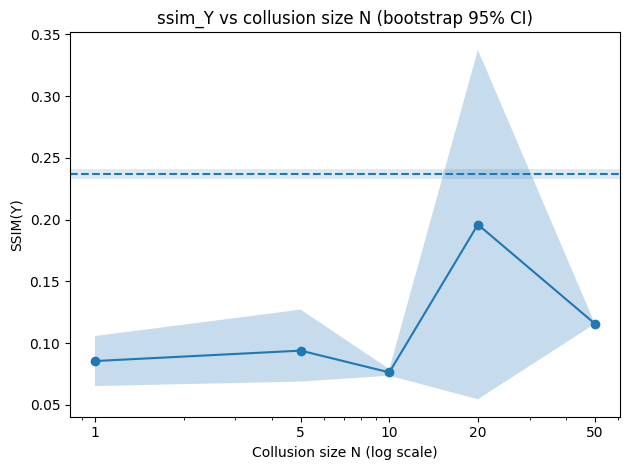

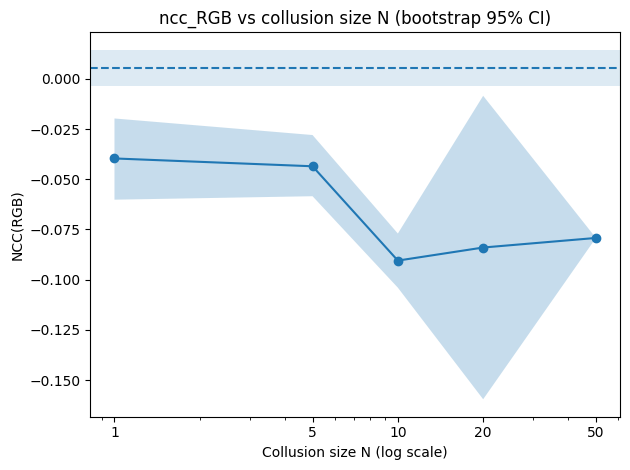

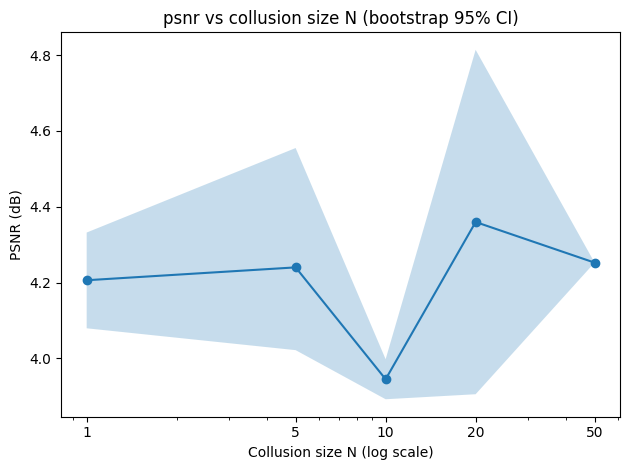

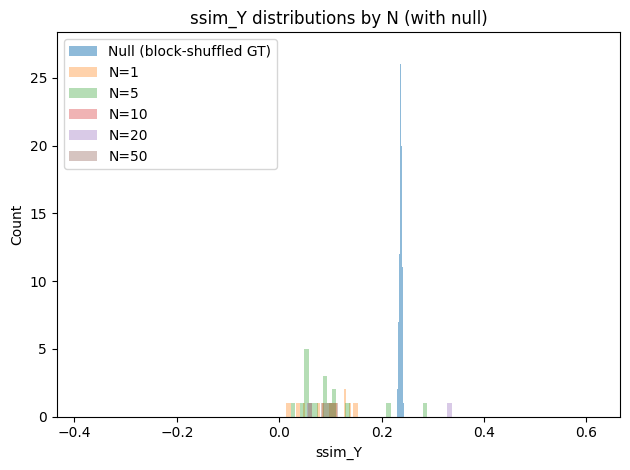

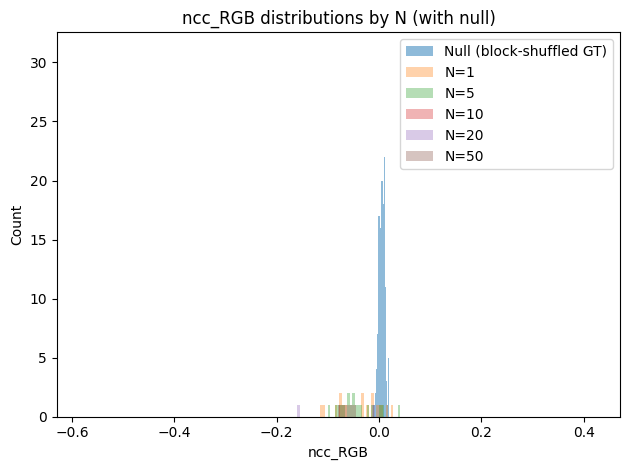

In [ ]:
# =========================================
# Collusion curves + content-leakage plots + bootstrap CIs
# Uses EXISTING recovered outputs (no new attack code)
# Produces paper-ready figures + CSVs in OUT_DIR
# =========================================
!pip -q install opencv-python pillow numpy pandas scikit-image

from pathlib import Path
import re
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# -------------------------
# PATHS (EDIT IF NEEDED)
# -------------------------
GT_WATERMARK = Path("/content/watermark.png")  # GT watermark image (RGB)

# Folder that already contains your recovery outputs
# Expect filenames containing N, e.g. ...__N20__... or ..._N=20_... or ...N20...
REC_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/forgery_extracted_watermarks")

# Optional: folder with watermarked videos for content-leakage control
# (only needed if you want "recovered vs content median frame")
WM_VIDEO_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/test_set/watermarked/Bho UCG")

OUT_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion")
OUT_DIR.mkdir(parents=True, exist_ok=True)

REC_RGB_PATTERNS = [
    "*__WM_EST_RGB.png",
    "*RECOVERED*.png",
    "*.png",
]

# -------------------------
# CONFIG
# -------------------------
# Collusion sizes you want to plot. We'll only keep those found in filenames.
N_TARGET = [1, 5, 10, 20, 50, 100]

# For content leakage: how many seconds to use for median frame extraction
CONTENT_MEDIAN_SECONDS = 8.0

# Bootstrap
NBOOT = 2000
BOOT_SEED = 0

# Null model: block shuffle GT watermark (for chance baseline)
NULL_SAMPLES = 300
NULL_BLOCK = 16

# -------------------------
# Helpers
# -------------------------
def load_rgb(p: Path):
    return np.array(Image.open(p).convert("RGB"))

def load_gray(p: Path):
    return np.array(Image.open(p).convert("L"))

def resize_to(img, hw):
    h, w = hw
    return cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)

def to_y(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)[...,0].astype(np.float32)

def ncc(a, b, eps=1e-9):
    a = a.astype(np.float32).reshape(-1)
    b = b.astype(np.float32).reshape(-1)
    a = (a - a.mean())/(a.std()+eps)
    b = (b - b.mean())/(b.std()+eps)
    return float((a*b).mean())

def psnr(a, b, eps=1e-9):
    a = a.astype(np.float32); b = b.astype(np.float32)
    mse = float(np.mean((a-b)**2))
    if mse < eps: return 99.0
    return float(10*np.log10((255.0**2)/mse))

def channel_corr(a, b, eps=1e-9):
    out = {}
    for i, c in enumerate(["R","G","B"]):
        ai = a[...,i].astype(np.float32).reshape(-1)
        bi = b[...,i].astype(np.float32).reshape(-1)
        ai = (ai-ai.mean())/(ai.std()+eps)
        bi = (bi-bi.mean())/(bi.std()+eps)
        out[c] = float((ai*bi).mean())
    return out

def bootstrap_ci_mean(x, nboot=NBOOT, seed=BOOT_SEED):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return (np.nan, np.nan, np.nan)
    means = []
    for _ in range(nboot):
        samp = rng.choice(x, size=x.size, replace=True)
        means.append(float(np.mean(samp)))
    means = np.array(means)
    return (float(np.mean(x)),
            float(np.quantile(means, 0.025)),
            float(np.quantile(means, 0.975)))

def parse_N_from_name(name: str):
    """
    Tries to parse collusion N from filename.
    Supported examples:
      ...__N20__...
      ..._N=20_...
      ...N20...
      ...collusion20...
    """
    m = re.search(r"(?:__|_|-|\b)N\s*=?\s*(\d+)(?:__|_|-|\b)", name, re.IGNORECASE)
    if m:
        return int(m.group(1))
    m = re.search(r"collusion\s*=?\s*(\d+)", name, re.IGNORECASE)
    if m:
        return int(m.group(1))
    # last resort: look for standalone 1/5/10/20/50/100 in name
    for n in N_TARGET[::-1]:
        if re.search(rf"(?<!\d){n}(?!\d)", name):
            return n
    return None

def block_shuffle(img, block=16, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    H, W = img.shape[:2]
    bh = block; bw = block
    H2 = (H//bh)*bh
    W2 = (W//bw)*bw
    core = img[:H2,:W2].copy()
    blocks = []
    for y in range(0, H2, bh):
        for x in range(0, W2, bw):
            blocks.append(core[y:y+bh, x:x+bw].copy())
    perm = rng.permutation(len(blocks))
    blocks = [blocks[i] for i in perm]
    out = core.copy()
    k = 0
    for y in range(0, H2, bh):
        for x in range(0, W2, bw):
            out[y:y+bh, x:x+bw] = blocks[k]; k += 1
    final = img.copy()
    final[:H2,:W2] = out
    return final

def extract_median_frame(video: Path, out_png: Path, target_w: int, target_h: int, sample_seconds: float):
    """
    Content-leakage control: median frame over short window.
    """
    out_png.parent.mkdir(parents=True, exist_ok=True)
    vf = (
        f"scale={target_w}:{target_h}:force_original_aspect_ratio=decrease,"
        f"pad={target_w}:{target_h}:(ow-iw)/2:(oh-ih)/2,setsar=1,"
        f"tmedian=radius=5"
    )
    cmd = [
        "ffmpeg","-y","-hide_banner","-loglevel","error",
        "-i", str(video),
        "-t", str(sample_seconds),
        "-vf", vf,
        "-frames:v","1",
        str(out_png)
    ]
    import subprocess
    subprocess.run(cmd, check=True)

# -------------------------
# Load GT
# -------------------------
if not GT_WATERMARK.exists():
    raise FileNotFoundError(f"GT watermark not found: {GT_WATERMARK}")
gt = load_rgb(GT_WATERMARK)
H, W, _ = gt.shape
gtY = to_y(gt)

# -------------------------
# Collect recovered files
# -------------------------
rec_files = []
for pat in REC_RGB_PATTERNS:
    rec_files.extend(list(REC_DIR.glob(pat)))
rec_files = sorted(set(rec_files))

# Keep only pngs that are likely recovery outputs
rec_files = [p for p in rec_files if p.suffix.lower()==".png"]
if not rec_files:
    raise RuntimeError(f"No PNGs found in {REC_DIR}")

# Parse N and build table
rows = []
for p in rec_files:
    N = parse_N_from_name(p.name)
    if N is None:
        continue
    rec = resize_to(load_rgb(p), (H, W))
    recY = to_y(rec)
    ssimY = float(ssim(gtY, recY, data_range=255.0))
    nccRGB = ncc(gt, rec)
    ps = psnr(gt, rec)
    ch = channel_corr(gt, rec)

    # optional content-leakage control if stem matches a video
    # we try to match using the part before first "__" or before suffix patterns
    stem_guess = p.stem.split("__")[0]
    vid = WM_VIDEO_DIR / f"{stem_guess}.mp4"
    ncc_rec_med = np.nan
    ssim_rec_med = np.nan
    if vid.exists():
        med_png = OUT_DIR / "_median_frames" / f"{stem_guess}__median.png"
        if not med_png.exists():
            extract_median_frame(vid, med_png, target_w=W, target_h=H, sample_seconds=CONTENT_MEDIAN_SECONDS)
        med = load_rgb(med_png)
        ncc_rec_med = ncc(rec, med)
        ssim_rec_med = float(ssim(to_y(rec), to_y(med), data_range=255.0))

    rows.append({
        "file": p.name,
        "N": N,
        "ssim_Y": ssimY,
        "ncc_RGB": nccRGB,
        "psnr": ps,
        "corr_R": ch["R"],
        "corr_G": ch["G"],
        "corr_B": ch["B"],
        "ncc_rec_vs_median": ncc_rec_med,
        "ssim_rec_vs_median_Y": ssim_rec_med,
        "path": str(p),
    })

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError(
        "No recovered images had a parsable N in filename.\n"
        "Rename outputs to include N (e.g., __N20__) or adjust parse_N_from_name()."
    )

df.to_csv(OUT_DIR / "per_sample_metrics.csv", index=False)
print("Saved:", OUT_DIR / "per_sample_metrics.csv")
print(df.groupby("N").size())

# -------------------------
# Null baseline
# -------------------------
rng = np.random.default_rng(0)
null_ssim = []
null_ncc  = []
for _ in range(NULL_SAMPLES):
    sh = block_shuffle(gt, block=NULL_BLOCK, rng=rng)
    null_ssim.append(float(ssim(to_y(gt), to_y(sh), data_range=255.0)))
    null_ncc.append(ncc(gt, sh))
null_ssim = np.array(null_ssim)
null_ncc  = np.array(null_ncc)

# -------------------------
# Collusion curves (mean + bootstrap CI) by N
# -------------------------
curve_rows = []
for N in sorted(df["N"].unique()):
    sub = df[df["N"]==N]
    for metric in ["ssim_Y","ncc_RGB","psnr","corr_R","corr_G","corr_B"]:
        m, lo, hi = bootstrap_ci_mean(sub[metric].to_numpy())
        curve_rows.append({"N": N, "metric": metric, "mean": m, "ci_lo": lo, "ci_hi": hi, "count": len(sub)})

curve = pd.DataFrame(curve_rows)
curve.to_csv(OUT_DIR / "collusion_curves_bootstrap.csv", index=False)
print("Saved:", OUT_DIR / "collusion_curves_bootstrap.csv")

# -------------------------
# Plot: metric vs N with CI
# -------------------------
def plot_curve(metric, ylabel=None, null_dist=None, null_label="null"):
    sub = curve[curve["metric"]==metric].sort_values("N")
    Ns = sub["N"].to_numpy()
    mean = sub["mean"].to_numpy()
    lo = sub["ci_lo"].to_numpy()
    hi = sub["ci_hi"].to_numpy()

    plt.figure()
    plt.plot(Ns, mean, marker="o")
    plt.fill_between(Ns, lo, hi, alpha=0.25)
    plt.xscale("log")
    plt.xticks(sorted(df["N"].unique()), [str(x) for x in sorted(df["N"].unique())])
    plt.xlabel("Collusion size N (log scale)")
    plt.ylabel(ylabel or metric)
    plt.title(f"{metric} vs collusion size N (bootstrap 95% CI)")

    # Add null band (5–95%) as reference
    if null_dist is not None:
        q05 = float(np.quantile(null_dist, 0.05))
        q95 = float(np.quantile(null_dist, 0.95))
        plt.axhspan(q05, q95, alpha=0.15)
        plt.axhline(float(np.mean(null_dist)), linestyle="--")

    plt.tight_layout()
    plt.savefig(OUT_DIR / f"curve_{metric}.png", dpi=200)

plot_curve("ssim_Y", ylabel="SSIM(Y)", null_dist=null_ssim)
plot_curve("ncc_RGB", ylabel="NCC(RGB)", null_dist=null_ncc)
plot_curve("psnr", ylabel="PSNR (dB)")

# -------------------------
# Content leakage plots (if available)
# -------------------------
if df["ncc_rec_vs_median"].notna().any():
    # Scatter: recovered vs GT (x) vs recovered vs content (y)
    plt.figure()
    plt.scatter(df["ncc_RGB"], df["ncc_rec_vs_median"])
    plt.xlabel("NCC(recovered, GT watermark)")
    plt.ylabel("NCC(recovered, content median)")
    plt.title("Content-leakage diagnostic: recovered resembles content vs watermark")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "content_leakage_scatter_ncc.png", dpi=200)

    # Curves vs N
    leak_curve_rows = []
    for N in sorted(df["N"].unique()):
        sub = df[df["N"]==N].dropna(subset=["ncc_rec_vs_median"])
        if len(sub)==0:
            continue
        m, lo, hi = bootstrap_ci_mean(sub["ncc_rec_vs_median"].to_numpy())
        leak_curve_rows.append({"N": N, "mean": m, "ci_lo": lo, "ci_hi": hi, "count": len(sub)})
    leak_curve = pd.DataFrame(leak_curve_rows).sort_values("N")
    leak_curve.to_csv(OUT_DIR / "content_leakage_curve.csv", index=False)

    plt.figure()
    plt.plot(leak_curve["N"], leak_curve["mean"], marker="o")
    plt.fill_between(leak_curve["N"], leak_curve["ci_lo"], leak_curve["ci_hi"], alpha=0.25)
    plt.xscale("log")
    plt.xticks(sorted(leak_curve["N"].unique()), [str(x) for x in sorted(leak_curve["N"].unique())])
    plt.xlabel("Collusion size N (log scale)")
    plt.ylabel("NCC(recovered, content median)")
    plt.title("Recovered template becomes more content-like with N?")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "content_leakage_curve.png", dpi=200)

# -------------------------
# Histograms by N (SSIM/NCC) + null overlay
# -------------------------
for metric, null_dist in [("ssim_Y", null_ssim), ("ncc_RGB", null_ncc)]:
    plt.figure()
    plt.hist(null_dist, bins=30, alpha=0.5, label="Null (block-shuffled GT)")
    for N in sorted(df["N"].unique()):
        vals = df[df["N"]==N][metric].to_numpy()
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=30, alpha=0.35, label=f"N={N}")
    plt.title(f"{metric} distributions by N (with null)")
    plt.xlabel(metric)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"hist_{metric}_byN.png", dpi=200)

# -------------------------
# Print short statistical summary for paper
# -------------------------
def summarize_metric(metric, null_dist=None):
    print(f"\n== {metric} ==")
    for N in sorted(df["N"].unique()):
        vals = df[df["N"]==N][metric].to_numpy()
        m, lo, hi = bootstrap_ci_mean(vals)
        print(f"N={N:>3}  mean={m:.4f}  95%CI=[{lo:.4f},{hi:.4f}]  (n={len(vals)})")
    if null_dist is not None:
        print(f"Null mean={float(np.mean(null_dist)):.4f}, 5–95%=[{float(np.quantile(null_dist,0.05)):.4f},{float(np.quantile(null_dist,0.95)):.4f}]")

summarize_metric("ssim_Y", null_ssim)
summarize_metric("ncc_RGB", null_ncc)
summarize_metric("psnr", None)

if df["ncc_rec_vs_median"].notna().any():
    summarize_metric("ncc_rec_vs_median", None)

print("\nSaved figures + CSVs to:", OUT_DIR)
print("Key outputs:")
print(" - per_sample_metrics.csv")
print(" - collusion_curves_bootstrap.csv")
print(" - curve_ssim_Y.png / curve_ncc_RGB.png / curve_psnr.png")
print(" - hist_ssim_Y_byN.png / hist_ncc_RGB_byN.png")
print(" - content_leakage_scatter_ncc.png (if video matching worked)")
print(" - content_leakage_curve.png (if available)")


Counts per N from CSV:
N
1     17
5     18
10     2
20     2
50     1
dtype: int64

Saved to: /content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion_v2
 - null_baselines.csv
 - collusion_curves_strict_and_balanced.csv
 - curve_ssimY_*.png / curve_nccRGB_*.png
 - hist_*_vs_nullA/B/C.png
 - balancing_log.csv


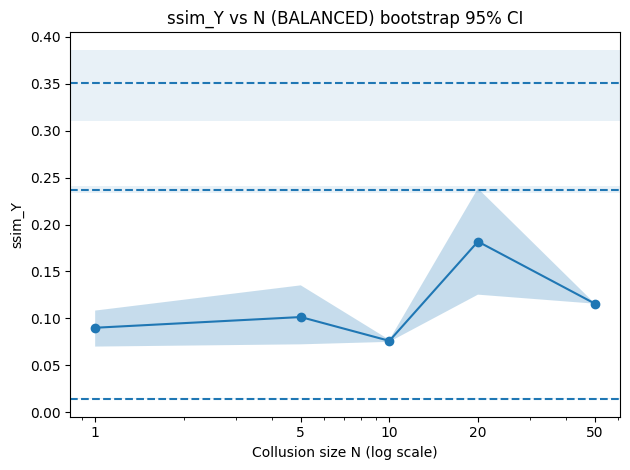

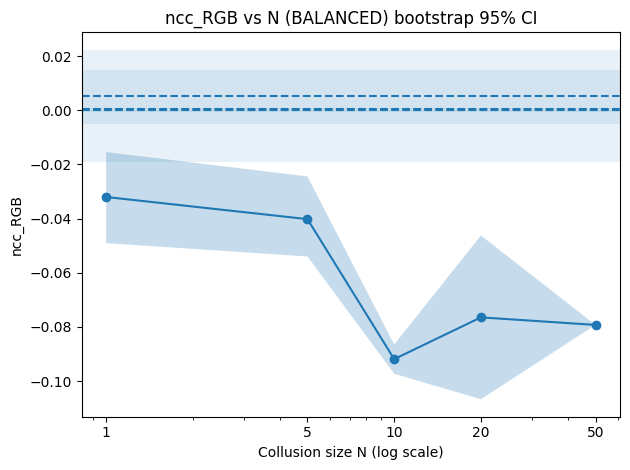

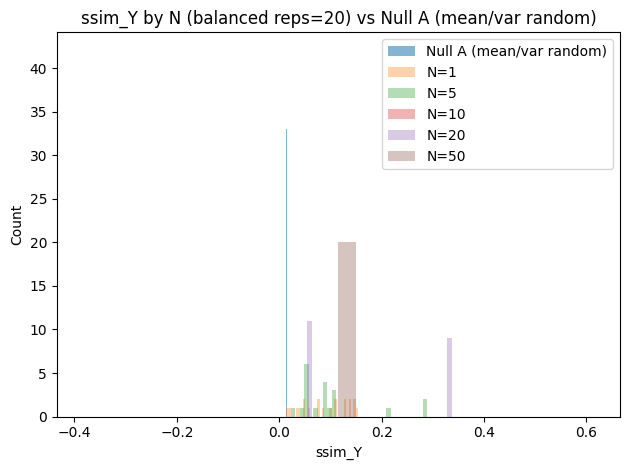

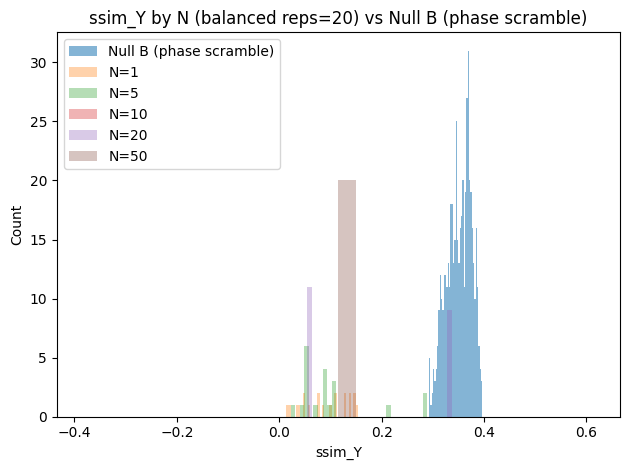

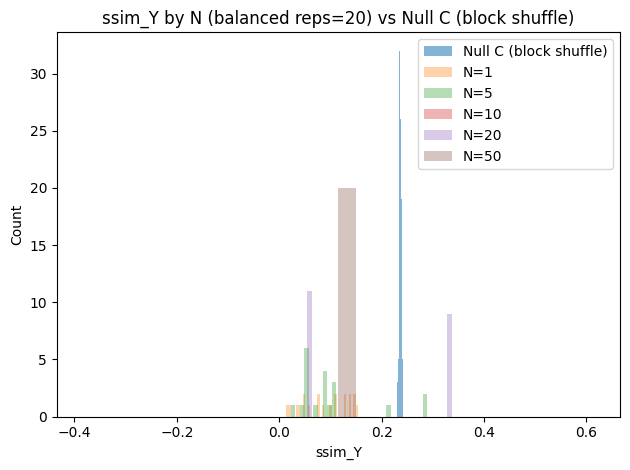

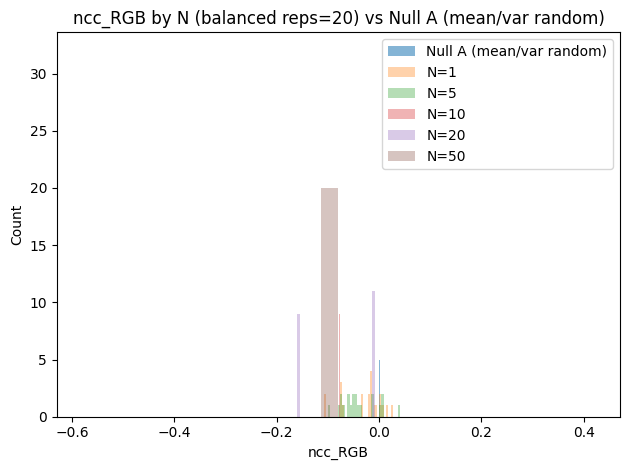

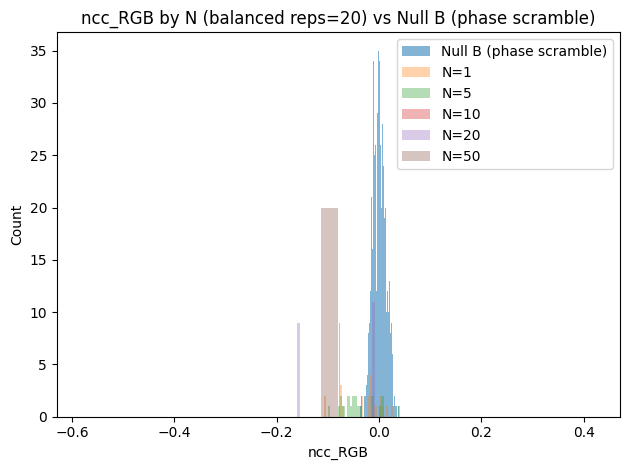

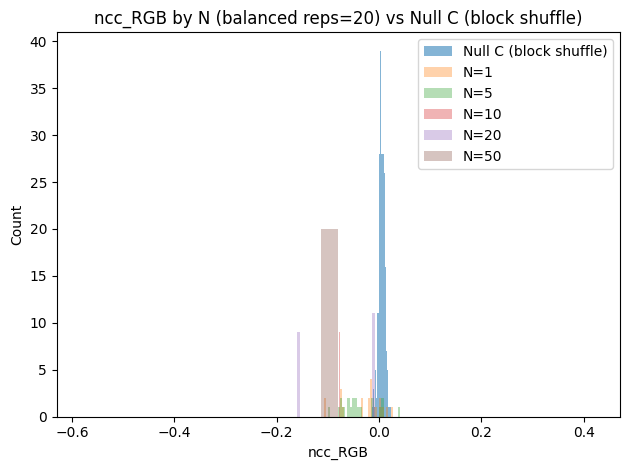

In [ ]:
# =========================================
# FIXED VERSION: reads N from existing per_sample_metrics.csv
# Then: balanced reps + null A/B/C + bootstrap CIs + plots
# =========================================
!pip -q install opencv-python pillow numpy pandas scikit-image

from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# -------------------------
# PATHS (EDIT IF NEEDED)
# -------------------------
GT_WATERMARK = Path("/content/watermark.png")

# Use the CSV produced by your previous analysis (you showed it exists here):
METRICS_CSV = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion/per_sample_metrics.csv")

OUT_DIR = Path("/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/new_data_TOMM/paper_figures_collusion_v2")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# SETTINGS
# -------------------------
N_TARGET = [1, 5, 10, 20, 50, 100]
TARGET_REPS = 20
NBOOT = 2000
BOOT_SEED = 0

NULL_SAMPLES = 500
NULL_BLOCK = 16

# -------------------------
# Helpers
# -------------------------
def load_rgb(p: Path):
    return np.array(Image.open(p).convert("RGB"))

def to_y(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)[...,0].astype(np.float32)

def ncc(a, b, eps=1e-9):
    a = a.astype(np.float32).reshape(-1)
    b = b.astype(np.float32).reshape(-1)
    a = (a - a.mean())/(a.std()+eps)
    b = (b - b.mean())/(b.std()+eps)
    return float((a*b).mean())

def compute_metrics(gt, rec):
    gtY = to_y(gt)
    recY = to_y(rec)
    return {
        "ssim_Y": float(ssim(gtY, recY, data_range=255.0)),
        "ncc_RGB": ncc(gt, rec),
    }

def bootstrap_ci_mean(x, nboot=NBOOT, seed=BOOT_SEED):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return (np.nan, np.nan, np.nan)
    means = []
    for _ in range(nboot):
        samp = rng.choice(x, size=x.size, replace=True)
        means.append(float(np.mean(samp)))
    means = np.array(means)
    return (float(np.mean(x)),
            float(np.quantile(means, 0.025)),
            float(np.quantile(means, 0.975)))

def block_shuffle(img, block=16, rng=None):
    if rng is None: rng = np.random.default_rng(0)
    H, W = img.shape[:2]
    bh = block; bw = block
    H2 = (H//bh)*bh
    W2 = (W//bw)*bw
    core = img[:H2,:W2].copy()
    blocks = []
    for y in range(0, H2, bh):
        for x in range(0, W2, bw):
            blocks.append(core[y:y+bh, x:x+bw].copy())
    perm = rng.permutation(len(blocks))
    blocks = [blocks[i] for i in perm]
    out = core.copy()
    k = 0
    for y in range(0, H2, bh):
        for x in range(0, W2, bw):
            out[y:y+bh, x:x+bw] = blocks[k]; k += 1
    final = img.copy()
    final[:H2,:W2] = out
    return final

def random_meanvar_matched(gt, rng=None):
    if rng is None: rng = np.random.default_rng(0)
    gt_f = gt.astype(np.float32)
    mu = gt_f.reshape(-1,3).mean(axis=0)
    sd = gt_f.reshape(-1,3).std(axis=0) + 1e-6
    z = rng.standard_normal(size=gt_f.shape).astype(np.float32)
    out = z * sd + mu
    return np.clip(out, 0, 255).astype(np.uint8)

def phase_scramble(gt, rng=None):
    if rng is None: rng = np.random.default_rng(0)
    gt_f = gt.astype(np.float32)
    out = np.zeros_like(gt_f)
    for c in range(3):
        x = gt_f[...,c]
        F = np.fft.fft2(x)
        mag = np.abs(F)
        rand_phase = rng.uniform(-np.pi, np.pi, size=mag.shape)
        F2 = mag * np.exp(1j*rand_phase)
        x2 = np.fft.ifft2(F2).real
        out[...,c] = x2
    out = out - out.min()
    out = out / (out.max() + 1e-6) * 255.0
    return np.clip(out, 0, 255).astype(np.uint8)

# -------------------------
# Load GT + existing metrics CSV
# -------------------------
if not GT_WATERMARK.exists():
    raise FileNotFoundError(f"GT watermark not found: {GT_WATERMARK}")
gt = load_rgb(GT_WATERMARK)

if not METRICS_CSV.exists():
    raise FileNotFoundError(f"Metrics CSV not found: {METRICS_CSV}")

df = pd.read_csv(METRICS_CSV)
# Expect at least: file, N, path (or file only). If path missing, we will rebuild from REC_DIR if you add it.
if "N" not in df.columns:
    raise RuntimeError("Your metrics CSV does not include column 'N'. Use the earlier CSV that produced the N counts you printed.")

# Keep only target Ns
df = df[df["N"].isin(N_TARGET)].copy()
print("Counts per N from CSV:")
print(df.groupby("N").size())

# -------------------------
# STRICT vs BALANCED
# -------------------------
rng = np.random.default_rng(BOOT_SEED)

strict_Ns = [N for N in sorted(df["N"].unique()) if (df[df["N"]==N].shape[0] >= TARGET_REPS)]
df_strict = df[df["N"].isin(strict_Ns)].copy()

balanced_parts = []
balance_note = []
for N in sorted(df["N"].unique()):
    sub = df[df["N"]==N].copy()
    if sub.shape[0] >= TARGET_REPS:
        take = sub.sample(n=TARGET_REPS, replace=False, random_state=BOOT_SEED)
        balance_note.append((N, sub.shape[0], "subsampled w/o replacement"))
    else:
        take = sub.sample(n=TARGET_REPS, replace=True, random_state=BOOT_SEED)
        balance_note.append((N, sub.shape[0], "BOOTSTRAP-resampled (replacement)"))
    balanced_parts.append(take)

df_bal = pd.concat(balanced_parts, ignore_index=True)
pd.DataFrame(balance_note, columns=["N","available","balancing"]).to_csv(OUT_DIR/"balancing_log.csv", index=False)

# -------------------------
# Null baselines (SSIM + NCC)
# -------------------------
null_rng = np.random.default_rng(0)
nullA_ssim, nullA_ncc = [], []
nullB_ssim, nullB_ncc = [], []
nullC_ssim, nullC_ncc = [], []

for _ in range(NULL_SAMPLES):
    a = random_meanvar_matched(gt, rng=null_rng)
    m = compute_metrics(gt, a)
    nullA_ssim.append(m["ssim_Y"]); nullA_ncc.append(m["ncc_RGB"])

    b = phase_scramble(gt, rng=null_rng)
    m = compute_metrics(gt, b)
    nullB_ssim.append(m["ssim_Y"]); nullB_ncc.append(m["ncc_RGB"])

    c = block_shuffle(gt, block=NULL_BLOCK, rng=null_rng)
    m = compute_metrics(gt, c)
    nullC_ssim.append(m["ssim_Y"]); nullC_ncc.append(m["ncc_RGB"])

nullA_ssim = np.array(nullA_ssim); nullA_ncc = np.array(nullA_ncc)
nullB_ssim = np.array(nullB_ssim); nullB_ncc = np.array(nullB_ncc)
nullC_ssim = np.array(nullC_ssim); nullC_ncc = np.array(nullC_ncc)

pd.DataFrame({
    "null": ["A_meanvar","B_phase","C_blockshuffle"],
    "ssim_mean": [nullA_ssim.mean(), nullB_ssim.mean(), nullC_ssim.mean()],
    "ssim_q05":  [np.quantile(nullA_ssim,0.05), np.quantile(nullB_ssim,0.05), np.quantile(nullC_ssim,0.05)],
    "ssim_q95":  [np.quantile(nullA_ssim,0.95), np.quantile(nullB_ssim,0.95), np.quantile(nullC_ssim,0.95)],
    "ncc_mean":  [nullA_ncc.mean(), nullB_ncc.mean(), nullC_ncc.mean()],
    "ncc_q05":   [np.quantile(nullA_ncc,0.05), np.quantile(nullB_ncc,0.05), np.quantile(nullC_ncc,0.05)],
    "ncc_q95":   [np.quantile(nullA_ncc,0.95), np.quantile(nullB_ncc,0.95), np.quantile(nullC_ncc,0.95)],
}).to_csv(OUT_DIR/"null_baselines.csv", index=False)

# -------------------------
# Curves with bootstrap CI
# -------------------------
def make_curve(dfx, tag):
    rows = []
    for N in sorted(dfx["N"].unique()):
        sub = dfx[dfx["N"]==N]
        for metric in ["ssim_Y","ncc_RGB","psnr"]:
            if metric not in sub.columns:
                continue
            m, lo, hi = bootstrap_ci_mean(sub[metric].to_numpy())
            rows.append({"tag": tag, "N": N, "metric": metric, "mean": m, "ci_lo": lo, "ci_hi": hi, "count": len(sub)})
    return pd.DataFrame(rows)

curves = pd.concat([
    make_curve(df_strict, "STRICT") if not df_strict.empty else pd.DataFrame(),
    make_curve(df_bal, "BALANCED")
], ignore_index=True)

curves.to_csv(OUT_DIR/"collusion_curves_strict_and_balanced.csv", index=False)

def plot_curve(tag, metric, null_dists, out_png):
    sub = curves[(curves["tag"]==tag) & (curves["metric"]==metric)].sort_values("N")
    if sub.empty: return
    Ns = sub["N"].to_numpy()
    mean = sub["mean"].to_numpy()
    lo = sub["ci_lo"].to_numpy()
    hi = sub["ci_hi"].to_numpy()

    plt.figure()
    plt.plot(Ns, mean, marker="o")
    plt.fill_between(Ns, lo, hi, alpha=0.25)
    plt.xscale("log")
    plt.xticks(Ns, [str(int(x)) for x in Ns])
    plt.xlabel("Collusion size N (log scale)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs N ({tag}) bootstrap 95% CI")

    # overlay null bands
    for null_dist in null_dists:
        q05 = float(np.quantile(null_dist, 0.05))
        q95 = float(np.quantile(null_dist, 0.95))
        plt.axhspan(q05, q95, alpha=0.10)
        plt.axhline(float(np.mean(null_dist)), linestyle="--")

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)

# plot (SSIM + NCC with null A/B/C; PSNR w/out null)
for tag in ["STRICT","BALANCED"]:
    plot_curve(tag, "ssim_Y", [nullA_ssim, nullB_ssim, nullC_ssim], OUT_DIR/f"curve_ssimY_{tag}.png")
    plot_curve(tag, "ncc_RGB", [nullA_ncc, nullB_ncc, nullC_ncc], OUT_DIR/f"curve_nccRGB_{tag}.png")

# histograms vs null A/B/C using BALANCED
def hist_vs_null(metric, null_dist, label, out_png):
    plt.figure()
    plt.hist(null_dist, bins=40, alpha=0.55, label=label)
    for N in sorted(df_bal["N"].unique()):
        vals = df_bal[df_bal["N"]==N][metric].to_numpy()
        plt.hist(vals, bins=30, alpha=0.35, label=f"N={N}")
    plt.title(f"{metric} by N (balanced reps={TARGET_REPS}) vs {label}")
    plt.xlabel(metric); plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)

hist_vs_null("ssim_Y", nullA_ssim, "Null A (mean/var random)", OUT_DIR/"hist_ssimY_vs_nullA.png")
hist_vs_null("ssim_Y", nullB_ssim, "Null B (phase scramble)", OUT_DIR/"hist_ssimY_vs_nullB.png")
hist_vs_null("ssim_Y", nullC_ssim, "Null C (block shuffle)", OUT_DIR/"hist_ssimY_vs_nullC.png")
hist_vs_null("ncc_RGB", nullA_ncc, "Null A (mean/var random)", OUT_DIR/"hist_nccRGB_vs_nullA.png")
hist_vs_null("ncc_RGB", nullB_ncc, "Null B (phase scramble)", OUT_DIR/"hist_nccRGB_vs_nullB.png")
hist_vs_null("ncc_RGB", nullC_ncc, "Null C (block shuffle)", OUT_DIR/"hist_nccRGB_vs_nullC.png")

print("\nSaved to:", OUT_DIR)
print(" - null_baselines.csv")
print(" - collusion_curves_strict_and_balanced.csv")
print(" - curve_ssimY_*.png / curve_nccRGB_*.png")
print(" - hist_*_vs_nullA/B/C.png")
print(" - balancing_log.csv")

#EDA Kinetics



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Not Noisy


[miss] video_analysis_out/video_features_raw.npy not found.
[rebuild] No .npy features found → extracting from VIDEO_DIR …
[rebuild] video_features_raw saved: (200, 127)
[pca] retained components: 41 (95% var)
[AutoSelect] model=gmm_diag, K=2 (sil=0.156, DB=5.386)
[embedding] Using UMAP


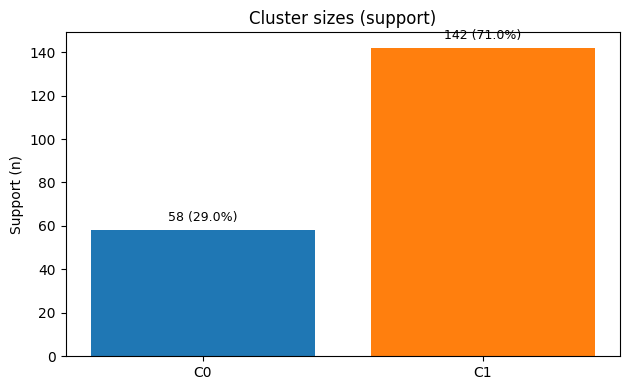

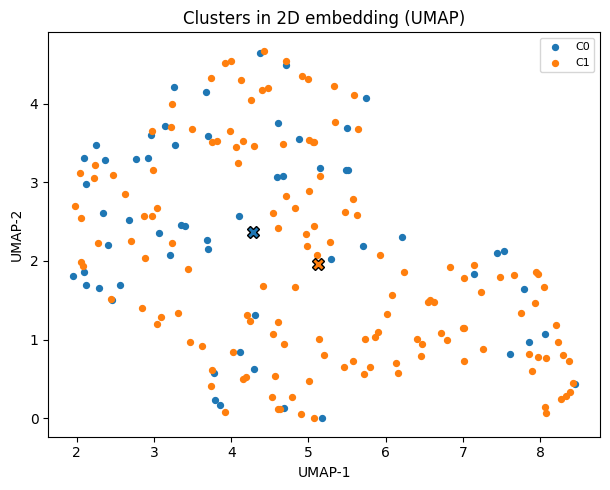

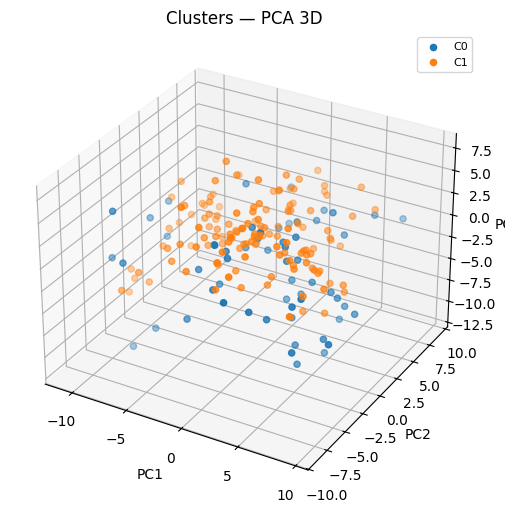

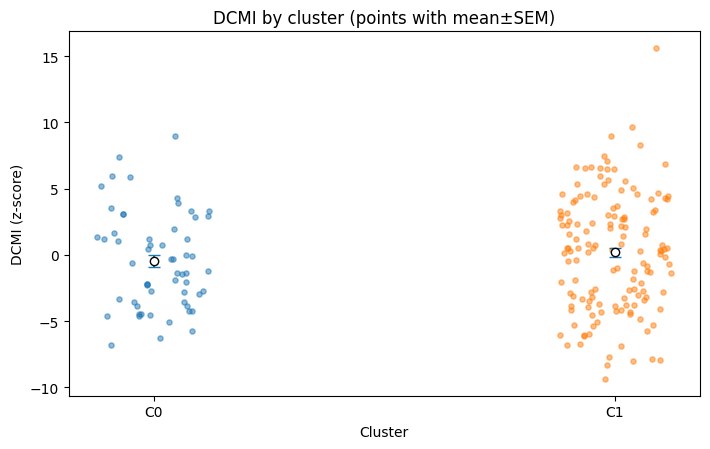

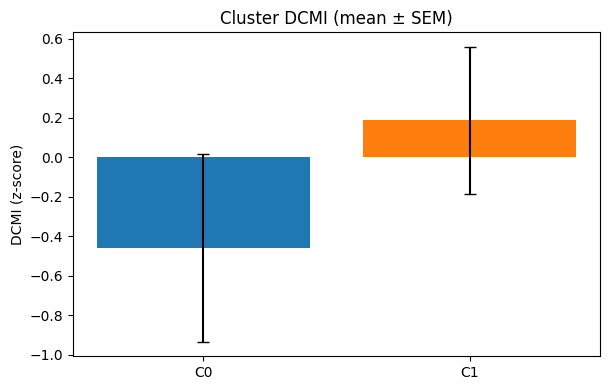

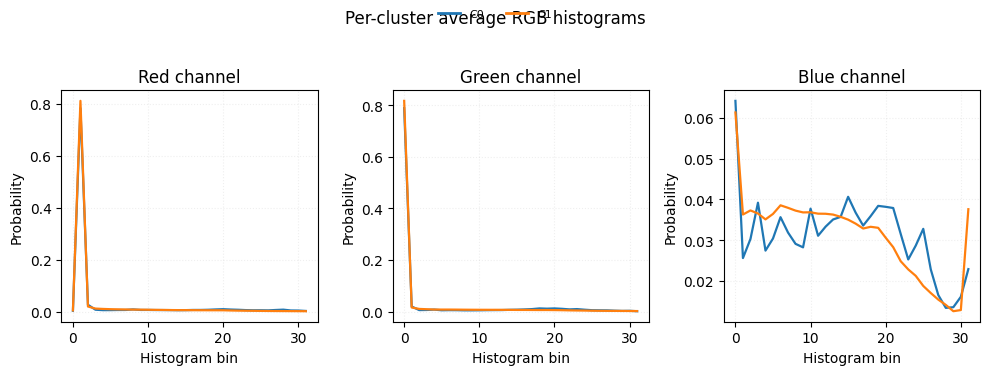

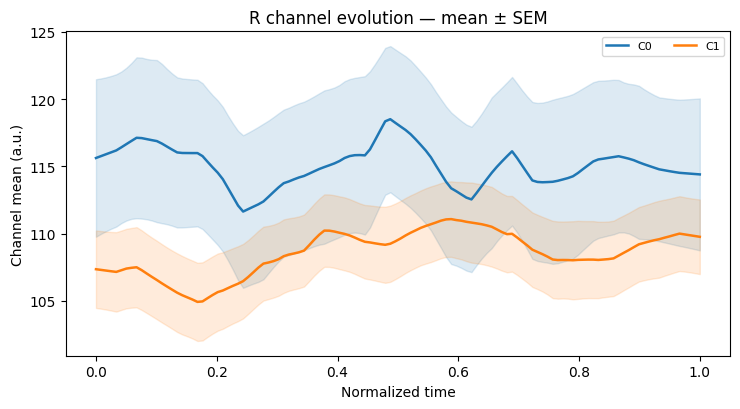

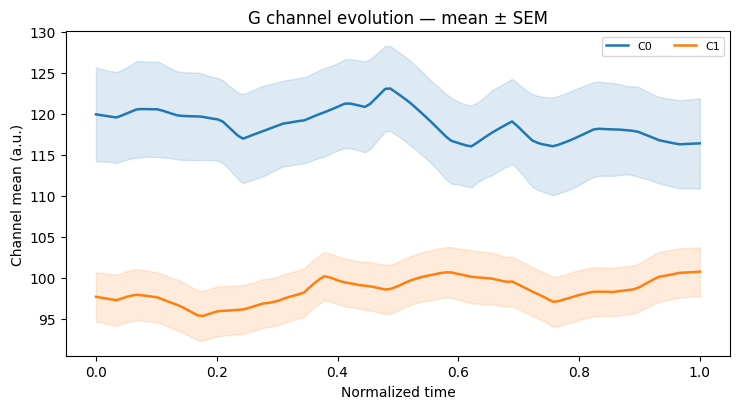

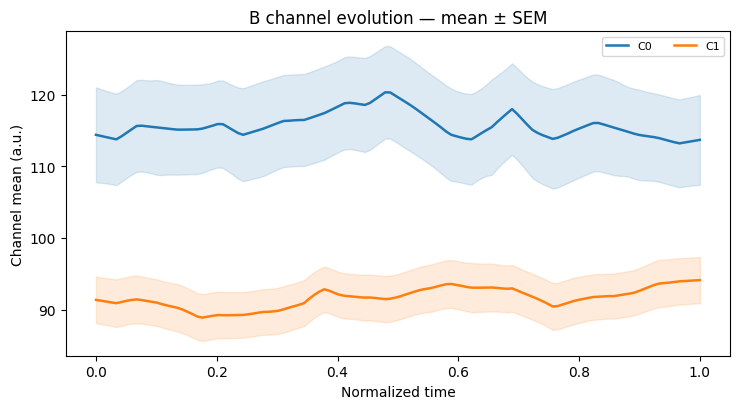

✅ Done. Outputs saved under: video_analysis_out


In [ ]:
# ============================================
# FULL PIPELINE (self-healing): load or rebuild features → advanced clustering → rich plots
# ============================================

# (Optional) installs if you're in a fresh Colab
# !pip -q install opencv-python-headless==4.10.0.84 scikit-learn hdbscan umap-learn tslearn==0.6.3

import os, re, math, warnings, json, pickle, glob, pathlib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ----------------------------
# CONFIG / PATHS
# ----------------------------
OUT_DIR = "video_analysis_out"            # must match earlier step
RAW_FEAT = os.path.join(OUT_DIR, "video_features_raw.npy")
SCALED_FEAT = os.path.join(OUT_DIR, "video_features_scaled.npy")  # optional alt
KMEANS_CSV = os.path.join(OUT_DIR, "video_clusters_kmeans.csv")   # to recover names if needed
AUTO_OUT_CSV = os.path.join(OUT_DIR, "video_clusters_auto.csv")

# If features must be rebuilt, set your folder here:
VIDEO_DIR = "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked"

# Rebuild settings (match your earlier extractor)
FRAME_STRIDE = 10
MAX_FRAMES_PER_VIDEO = 120
RESIZE_W = 384
HIST_BINS = 32
FLOW_STEP = 2
RANDOM_STATE = 42

# ----------------------------
# (A) TRY TO LOAD FEATURES; IF MISSING, REBUILD
# ----------------------------
def colorfulness_hasler(rgb):
    r, g, b = [rgb[...,i].astype(np.float32) for i in (0,1,2)]
    rg = np.abs(r - g)
    yb = np.abs(0.5*(r + g) - b)
    return np.sqrt(np.std(rg)**2 + np.std(yb)**2) + 0.3*np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)

def rgb_hist_features(rgb, bins=32):
    import cv2
    feats = []
    for ch in (0,1,2):  # R,G,B (image already RGB)
        hist = cv2.calcHist([rgb.astype(np.uint8)], [ch], None, [bins], [0, 256]).reshape(-1).astype(np.float32)
        hist /= (hist.sum() + 1e-12)
        feats.append(hist)
        p = np.clip(hist, 1e-12, 1.0)
        H = np.array([-(p * np.log2(p)).sum()], dtype=np.float32)
        feats.append(H)
    return np.concatenate(feats, axis=0).astype(np.float32)

def frame_diff_energy(prev_gray, gray):
    import cv2
    d = cv2.absdiff(prev_gray, gray)
    return float(np.mean(d)), float(np.std(d))

def luminance_flicker(prev_gray, gray):
    return float(np.mean(gray) - np.mean(prev_gray))

def optical_flow_magnitude(prev_gray, gray, step=2):
    import cv2
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)
    mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
    m = mag[::step, ::step].reshape(-1)
    if m.size == 0:
        return (0.0, 0.0, 0.0, 0.0)
    return float(np.mean(m)), float(np.std(m)), float(np.percentile(m, 90)), float(np.max(m))

def extract_video_features(path, frame_stride=10, max_frames=120, bins=32, resize_w=384):
    import cv2
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None, None, None
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    scale = resize_w / max(w, 1)
    size = (resize_w, int(round(h * scale)))

    frame_idx = 0
    kept = 0
    prev_gray = None
    ts = []
    agg_hists = []

    while True:
        ok = cap.grab()
        if not ok: break
        if frame_idx % frame_stride != 0:
            frame_idx += 1
            continue
        ok, frame_bgr = cap.retrieve()
        if not ok: break

        frame_bgr = cv2.resize(frame_bgr, size, interpolation=cv2.INTER_AREA)
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        means = frame_rgb.reshape(-1,3).mean(axis=0)
        stds  = frame_rgb.reshape(-1,3).std(axis=0)
        colorf = colorfulness_hasler(frame_rgb)
        hist_feats = rgb_hist_features(frame_rgb, bins=bins)
        agg_hists.append(hist_feats)

        if prev_gray is None:
            diff_m, diff_s, flick = 0.0, 0.0, 0.0
            flow_m, flow_s, flow_p90, flow_mx = 0.0, 0.0, 0.0, 0.0
        else:
            diff_m, diff_s = frame_diff_energy(prev_gray, gray)
            flick = luminance_flicker(prev_gray, gray)
            flow_m, flow_s, flow_p90, flow_mx = optical_flow_magnitude(prev_gray, gray, step=FLOW_STEP)

        prev_gray = gray
        ts.append(np.hstack([means, stds, [colorf, diff_m, diff_s, flick, flow_m, flow_s, flow_p90, flow_mx]]))
        kept += 1
        frame_idx += 1
        if kept >= max_frames:
            break

    cap.release()
    if kept == 0:
        return None, None, None

    ts_arr = np.asarray(ts, dtype=np.float32)
    agg_hist = np.mean(np.vstack(agg_hists), axis=0)
    video_feat = np.hstack([ts_arr.mean(axis=0), ts_arr.std(axis=0), agg_hist]).astype(np.float32)
    return video_feat, ts_arr, fps

def rebuild_features_from_folder(video_dir, out_dir):
    import cv2
    os.makedirs(out_dir, exist_ok=True)
    VID_EXT = (".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v")
    paths = [p for p in sorted(glob.glob(os.path.join(video_dir, "**/*"), recursive=True))
             if p.lower().endswith(VID_EXT)]
    assert len(paths)>0, f"No videos found under {video_dir}"
    feats, series, names = [], [], []
    for p in paths:
        vf, ts, _ = extract_video_features(p, FRAME_STRIDE, MAX_FRAMES_PER_VIDEO, HIST_BINS, RESIZE_W)
        if vf is None:
            print("Skipping (unreadable):", p); continue
        feats.append(vf); series.append(ts); names.append(os.path.basename(p))
    feats = np.vstack(feats)
    np.save(os.path.join(out_dir, "video_features_raw.npy"), feats)
    # optionally persist series (can be large)
    with open(os.path.join(out_dir, "video_series.pkl"), "wb") as f:
        pickle.dump(series, f)
    pd.DataFrame({"video": names}).to_csv(os.path.join(out_dir, "video_names.csv"), index=False)
    return feats, series, names

# Load-or-rebuild
video_features = None
video_names = None
video_series = None
if os.path.exists(RAW_FEAT):
    video_features = np.load(RAW_FEAT)
    print(f"[load] video_features_raw: {video_features.shape}")
else:
    print(f"[miss] {RAW_FEAT} not found.")
    if os.path.exists(SCALED_FEAT):
        # Use scaled features for clustering (works fine)
        video_features = np.load(SCALED_FEAT)
        print(f"[load] video_features_scaled: {video_features.shape}")
    else:
        print("[rebuild] No .npy features found → extracting from VIDEO_DIR …")
        video_features, video_series, video_names = rebuild_features_from_folder(VIDEO_DIR, OUT_DIR)
        print(f"[rebuild] video_features_raw saved: {video_features.shape}")

# Try to recover names if not set yet
if video_names is None:
    # priority: an existing names file or kmeans CSV from earlier run
    names_csv = os.path.join(OUT_DIR, "video_names.csv")
    if os.path.exists(names_csv):
        tmp = pd.read_csv(names_csv)
        if len(tmp) == len(video_features):
            video_names = tmp["video"].tolist()
    if video_names is None and os.path.exists(KMEANS_CSV):
        df_names = pd.read_csv(KMEANS_CSV)
        if "video" in df_names.columns and len(df_names) == len(video_features):
            video_names = df_names["video"].tolist()
if video_names is None:
    video_names = [f"video_{i:04d}" for i in range(len(video_features))]

# Try to load video_series if present on disk
if video_series is None:
    vs_pkl = os.path.join(OUT_DIR, "video_series.pkl")
    if os.path.exists(vs_pkl):
        with open(vs_pkl, "rb") as f:
            video_series = pickle.load(f)
        print(f"[load] video_series: {len(video_series)} sequences")
    else:
        print("[info] video_series not available; RGB temporal plots will be skipped.")

# ----------------------------
# SAFE UMAP LOADER + ROBUST 2D EMBEDDING
# ----------------------------
def load_umap_safe():
    try:
        import umap
        return umap
    except Exception:
        try:
            import umap.umap_ as umap
            return umap
        except Exception as e:
            print("⚠️ UMAP unavailable due to import conflict:", repr(e))
            return None

UMAP_MOD = load_umap_safe()

def robust_2d_embedding(X_lowdim, random_state=42):
    if UMAP_MOD is not None:
        try:
            um = UMAP_MOD.UMAP(n_neighbors=15, min_dist=0.1, random_state=random_state)
            return um.fit_transform(X_lowdim), "UMAP"
        except Exception as e:
            print("⚠️ UMAP failed, falling back:", repr(e))
    try:
        ts = TSNE(n_components=2, init="pca", learning_rate="auto",
                  random_state=random_state, perplexity=30)
        return ts.fit_transform(X_lowdim), "TSNE"
    except Exception as e:
        print("⚠️ TSNE failed, falling back to PCA(2):", repr(e))
    p2 = PCA(n_components=2, random_state=random_state)
    return p2.fit_transform(X_lowdim), "PCA2"

# ----------------------------
# ADVANCED CLUSTERING (K sweep + model selection)
# ----------------------------
K_RANGE = list(range(2, 13))   # K=2..12 (adjust if needed)
PCA_VARIANCE = 0.95

scaler = StandardScaler()
X = scaler.fit_transform(video_features)

pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)
print(f"[pca] retained components: {X_pca.shape[1]} (95% var)")

def fit_kmeans(k):
    m = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = m.fit_predict(X_pca)
    return m, labels

def fit_gmm(k, cov="full"):
    m = GaussianMixture(n_components=k, covariance_type=cov, random_state=RANDOM_STATE)
    m.fit(X_pca)
    labels = m.predict(X_pca)
    return m, labels

MODEL_FUNCS = {
    "kmeans":    lambda k: fit_kmeans(k),
    "gmm_diag":  lambda k: fit_gmm(k, cov="diag"),
    "gmm_full":  lambda k: fit_gmm(k, cov="full"),
}

records = []
curves = {name: {"k": [], "sil": []} for name in MODEL_FUNCS.keys()}

for name, fn in MODEL_FUNCS.items():
    for k in K_RANGE:
        try:
            model, labels_try = fn(k)
            if len(np.unique(labels_try)) < 2:
                sil = np.nan; db = np.nan; ch = np.nan
            else:
                sil = silhouette_score(X_pca, labels_try)
                db  = davies_bouldin_score(X_pca, labels_try)
                ch  = calinski_harabasz_score(X_pca, labels_try)
            records.append({"model": name, "k": k, "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch})
            curves[name]["k"].append(k); curves[name]["sil"].append(sil)
        except Exception as e:
            records.append({"model": name, "k": k, "silhouette": np.nan, "davies_bouldin": np.nan, "calinski_harabasz": np.nan})

sel_df = pd.DataFrame(records).sort_values(["model","k"])
os.makedirs(OUT_DIR, exist_ok=True)
sel_df.to_csv(os.path.join(OUT_DIR, "model_selection_summary.csv"), index=False)

def pick_best(df):
    d = df.dropna(subset=["silhouette"])
    assert not d.empty, "No valid silhouette computed; check data."
    max_sil = d["silhouette"].max()
    cand = d[d["silhouette"] == max_sil]
    best = cand.loc[cand["davies_bouldin"].idxmin()]
    return best

best_row = pick_best(sel_df)
BEST_MODEL = best_row["model"]; BEST_K = int(best_row["k"])
print(f"[AutoSelect] model={BEST_MODEL}, K={BEST_K} (sil={best_row['silhouette']:.3f}, DB={best_row['davies_bouldin']:.3f})")

final_model, final_labels = MODEL_FUNCS[BEST_MODEL](BEST_K)
labels = np.asarray(final_labels)
clusters = np.unique(labels)

# 2D embedding (robust)
X_2d, embed_name = robust_2d_embedding(X_pca, random_state=RANDOM_STATE)
print(f"[embedding] Using {embed_name}")

# 3D projection for plotting
X3 = X_pca[:, :3] if X_pca.shape[1] >= 3 else PCA(n_components=3, random_state=RANDOM_STATE).fit_transform(X_pca)

# Save auto labels
pd.DataFrame({"video": video_names, "model": BEST_MODEL, "k": BEST_K, "label": labels})\
  .to_csv(AUTO_OUT_CSV, index=False)

# ----------------------------
# CONSISTENT CLUSTER COLORS
# ----------------------------
tab10 = plt.cm.tab10.colors
palette = {lab: tab10[i % len(tab10)] for i, lab in enumerate(clusters)}

# ----------------------------
# PLOTS — cluster size, 2D, 3D
# ----------------------------
counts = pd.Series(labels).value_counts().sort_index()
plt.figure(figsize=(6.4,4))
xpos = np.arange(len(clusters))
plt.bar(xpos, counts.values, color=[palette[c] for c in clusters])
plt.xticks(xpos, [f"C{c}" for c in clusters])
plt.ylabel("Support (n)"); plt.title("Cluster sizes (support)")
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts.values)*0.02, f"{v} ({100*v/len(labels):.1f}%)", ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "clusters_sizes.png"), dpi=180); plt.show()

plt.figure(figsize=(6.2,5))
for c in clusters:
    m = labels == c
    plt.scatter(X_2d[m,0], X_2d[m,1], s=18, label=f"C{c}", color=palette[c])
# centroids
for c in clusters:
    m = labels == c
    mu = X_2d[m].mean(axis=0)
    plt.plot(mu[0], mu[1], 'X', ms=9, mec='k', mfc=palette[c], mew=1.0)
plt.title(f"Clusters in 2D embedding ({embed_name})")
plt.xlabel(f"{embed_name}-1"); plt.ylabel(f"{embed_name}-2")
plt.legend(loc="best", fontsize=8)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"clusters_{embed_name.lower()}_centroids.png"), dpi=180); plt.show()

fig = plt.figure(figsize=(6.4,5.2))
ax3 = fig.add_subplot(111, projection='3d')
for c in clusters:
    m = labels==c
    ax3.scatter(X3[m,0], X3[m,1], X3[m,2], s=20, depthshade=True, color=palette[c], label=f"C{c}")
ax3.set_xlabel("PC1"); ax3.set_ylabel("PC2"); ax3.set_zlabel("PC3")
ax3.set_title("Clusters — PCA 3D")
ax3.legend(loc="best", fontsize=8)
fig.tight_layout(); fig.savefig(os.path.join(OUT_DIR, "clusters_pca_3d.png"), dpi=180); plt.show()

# ----------------------------
# DCMI (same definition as before)
# ----------------------------
def compute_dcmi_from_raw(X_raw):
    D_ts = 14
    idx_cf_mean = 6
    idx_diff_m  = 7
    idx_diff_s  = 8
    idx_flick   = 9
    idx_flow_m  = 10
    idx_flow_s  = 11
    off = D_ts
    idx_cf_std  = off + 6
    cols = [idx_cf_mean, idx_flow_m, idx_flow_s, idx_diff_m, idx_diff_s, idx_flick, idx_cf_std]
    Xsel = X_raw[:, cols].astype(float)
    Xz = (Xsel - Xsel.mean(axis=0)) / (Xsel.std(axis=0) + 1e-9)
    return Xz.sum(axis=1)

# If we only have scaled features, DCMI is still okay (z-scores inside function normalize anyway)
video_features_for_dcmi = video_features
dcmi = compute_dcmi_from_raw(video_features_for_dcmi)
df_dcmi = pd.DataFrame({"video": video_names, "cluster": labels, "dcmi": dcmi})
df_dcmi.to_csv(os.path.join(OUT_DIR, "video_dcmi.csv"), index=False)

# DCMI scatter with mean±SEM
rng = np.random.default_rng(42)
plt.figure(figsize=(7.2,4.6))
pos = np.arange(len(clusters))
means, sems = [], []
for i, c in enumerate(clusters):
    vals = df_dcmi.loc[df_dcmi["cluster"]==c, "dcmi"].to_numpy()
    means.append(vals.mean() if vals.size else np.nan)
    sems.append(vals.std(ddof=1)/np.sqrt(max(1, vals.size)) if vals.size>1 else 0.0)
    jitter = (rng.random(vals.size)-0.5)*0.25
    plt.scatter(np.full(vals.shape, pos[i])+jitter, vals, s=14, alpha=0.5, color=palette[c])
plt.errorbar(pos, means, yerr=sems, fmt='o', capsize=4, lw=1.5, mfc='white', mec='black', ms=6)
plt.xticks(pos, [f"C{c}" for c in clusters])
plt.xlabel("Cluster"); plt.ylabel("DCMI (z-score)")
plt.title("DCMI by cluster (points with mean±SEM)")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "dcmi_scatter_mean_sem.png"), dpi=180); plt.show()

# DCMI bar
plt.figure(figsize=(6.2,4))
plt.bar(pos, means, yerr=sems, capsize=4, color=[palette[c] for c in clusters])
plt.xticks(pos, [f"C{c}" for c in clusters])
plt.ylabel("DCMI (z-score)"); plt.title("Cluster DCMI (mean ± SEM)")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "dcmi_bar_sem.png"), dpi=180); plt.show()

# ----------------------------
# RGB histogram aggregates per cluster (single figure with 3 subplots)
# RAW layout: [ts_mean(14), ts_std(14), RGB hists (3*bins) + 3 entropies]
# ----------------------------
def infer_histograms_from_raw(X_raw):
    D_ts = 14
    rem = X_raw.shape[1] - 2*D_ts
    bins = (rem - 3) // 3
    if 3*bins + 3 != rem or bins <= 1:
        raise ValueError("Cannot infer HIST_BINS from raw layout.")
    start = 2*D_ts
    hB = X_raw[:, start : start+bins]
    hG = X_raw[:, start+bins : start+2*bins]
    hR = X_raw[:, start+2*bins : start+3*bins]
    return hR, hG, hB, bins

def norm_rows(H):
    s = H.sum(axis=1, keepdims=True); s[s==0] = 1.0
    return H / s

try:
    hR, hG, hB, HB = infer_histograms_from_raw(video_features_for_dcmi)
    hR, hG, hB = norm_rows(hR), norm_rows(hG), norm_rows(hB)
    xbins = np.arange(HB)
    fig = plt.figure(figsize=(10,3.6))
    axes = [fig.add_subplot(1,3,i+1) for i in range(3)]
    titles = ["Red channel", "Green channel", "Blue channel"]
    for ax, Hc_all, title in zip(axes, [hR,hG,hB], titles):
        for c in clusters:
            m = labels == c
            if not np.any(m): continue
            avg = Hc_all[m].mean(axis=0)
            ax.plot(xbins, avg, lw=1.6, label=f"C{c}", color=palette[c])
        ax.set_xlabel("Histogram bin"); ax.set_ylabel("Probability"); ax.set_title(title)
        ax.grid(alpha=0.2, linestyle=':')
    handles = [plt.Line2D([0],[0], color=palette[c], lw=2, label=f"C{c}") for c in clusters]
    fig.legend(handles=handles, loc="upper center", ncol=min(6,len(handles)), fontsize=8, frameon=False)
    fig.suptitle("Per-cluster average RGB histograms", y=1.03)
    fig.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "rgb_aggregates_by_cluster.png"), dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    print("⚠️ Skipping RGB histogram aggregate (could not infer bins):", e)

# ----------------------------
# RGB temporal evolution (3 figures: R/G/B) — mean ± SEM per cluster
# Requires video_series in memory or on disk.
# ----------------------------
def resample_series(y, L=120):
    if y.size == 0: return np.zeros(L, dtype=float)
    x_old = np.linspace(0, 1, num=y.size)
    x_new = np.linspace(0, 1, num=L)
    return np.interp(x_new, x_old, y)

def cluster_channel_curves(video_series, labels, clusters, channel_idx, L=120):
    means, sems = [], []
    for c in clusters:
        vids = np.where(labels == c)[0]
        curves = []
        for v in vids:
            ts = video_series[v]
            if ts is None or ts.size == 0: continue
            y = ts[:, channel_idx].astype(float)
            curves.append(resample_series(y, L=L))
        if len(curves) == 0:
            means.append(np.zeros(L)); sems.append(np.zeros(L))
        else:
            arr = np.vstack(curves)
            means.append(arr.mean(axis=0))
            sems.append(arr.std(axis=0, ddof=1) / np.sqrt(arr.shape[0]))
    return means, sems

if isinstance(video_series, list) and len(video_series) == len(labels):
    L = 120; t = np.linspace(0, 1, L)
    for ch, title in zip([0,1,2], ["R channel evolution — mean ± SEM",
                                   "G channel evolution — mean ± SEM",
                                   "B channel evolution — mean ± SEM"]):
        means, sems = cluster_channel_curves(video_series, labels, clusters, ch, L=L)
        plt.figure(figsize=(7.5,4.2))
        for c in clusters:
            i = list(clusters).index(c)
            mu, se = means[i], sems[i]
            plt.plot(t, mu, lw=1.8, color=palette[c], label=f"C{c}")
            plt.fill_between(t, mu-se, mu+se, alpha=0.15, color=palette[c])
        plt.xlabel("Normalized time"); plt.ylabel("Channel mean (a.u.)")
        plt.title(title)
        plt.legend(loc="best", ncol=min(4, len(clusters)), fontsize=8)
        plt.tight_layout()
        fname = title.lower().replace(" ", "_").replace("—","-").replace("–","-") + ".png"
        plt.savefig(os.path.join(OUT_DIR, fname), dpi=180)
        plt.show()
else:
    print("ℹ️ Skipping RGB temporal evolution plots: 'video_series' not available "
          "(run and save extraction in this session to enable).")

print("✅ Done. Outputs saved under:", OUT_DIR)


[load] video_series.pkl: 200 sequences


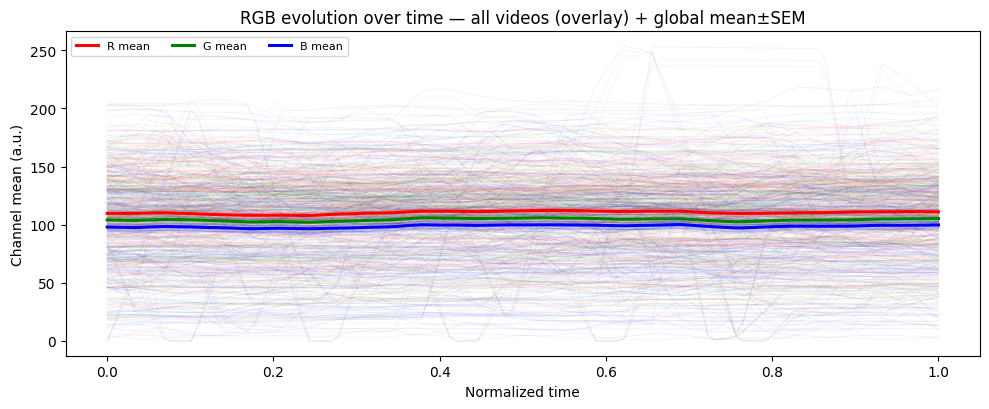

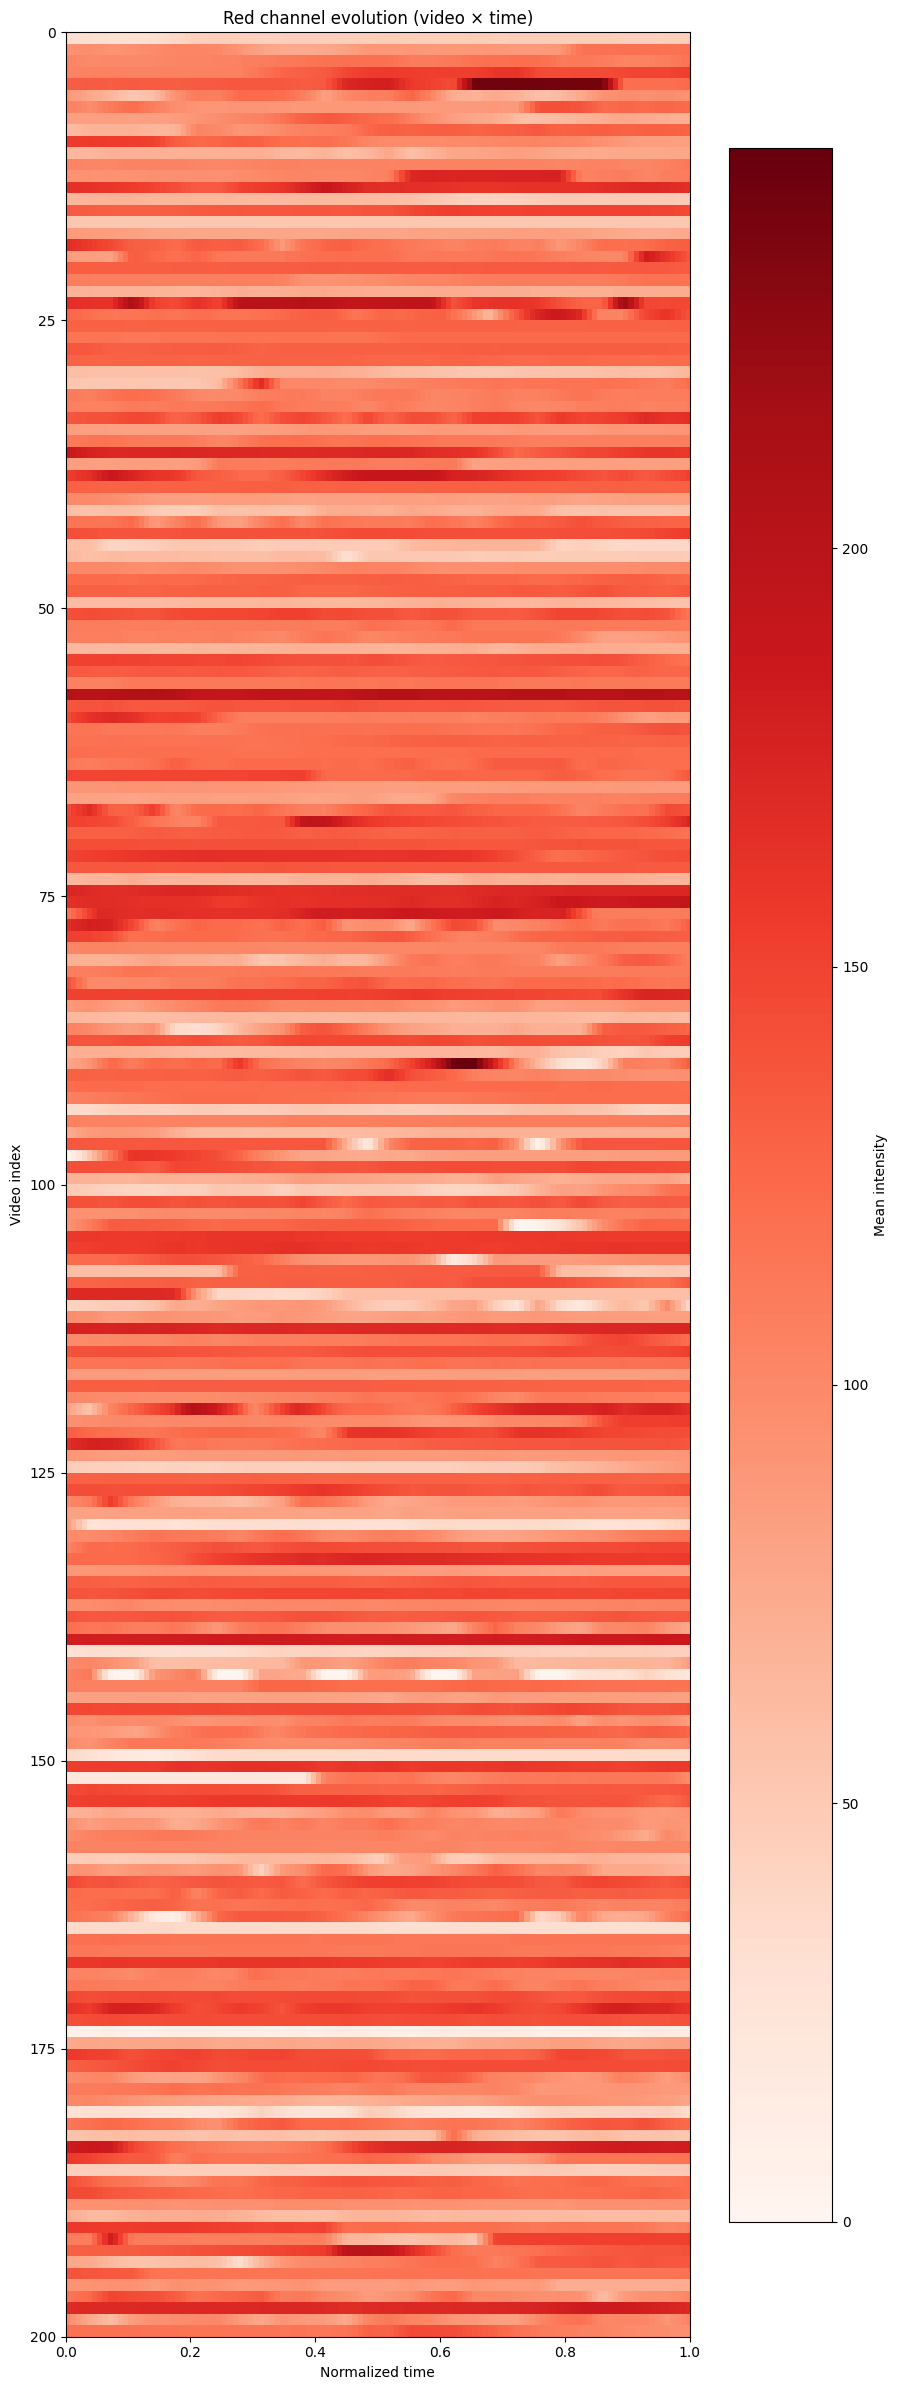

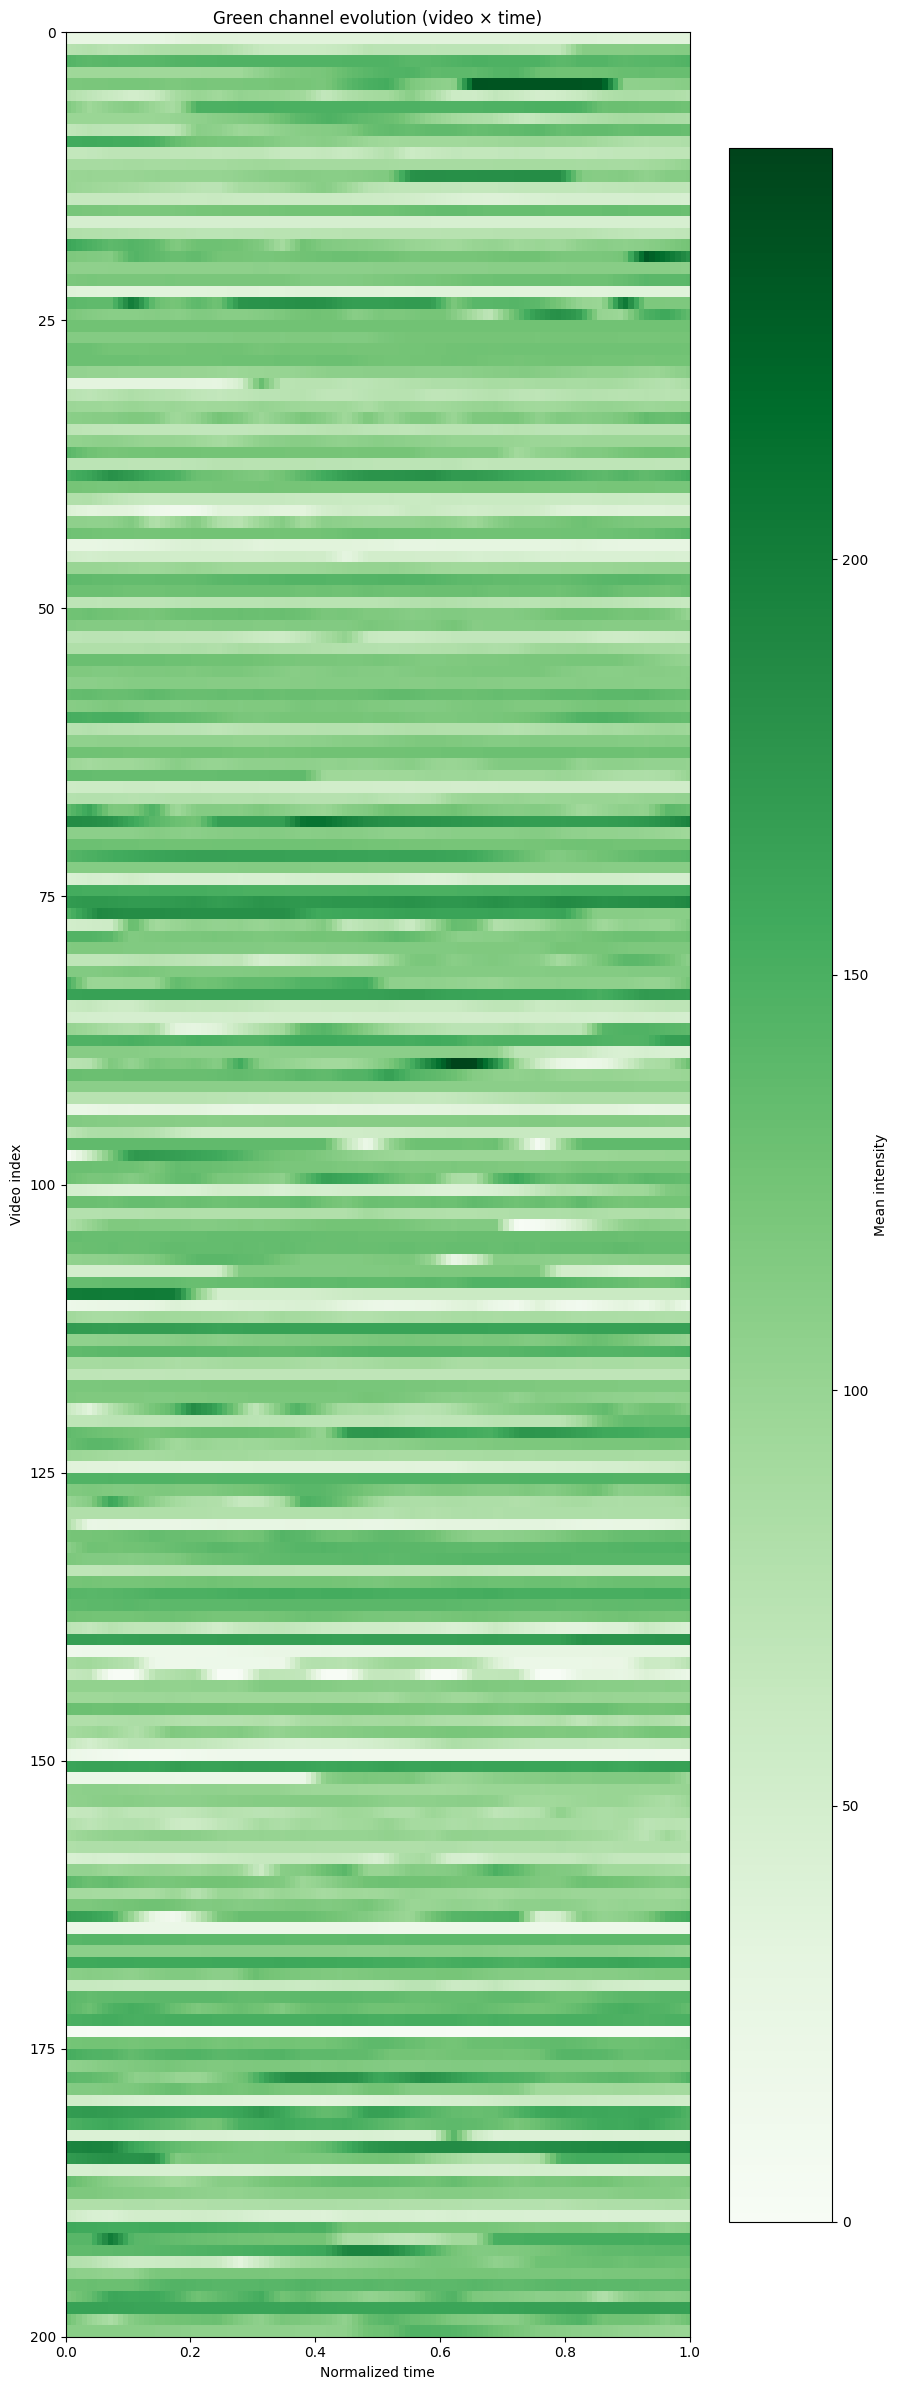

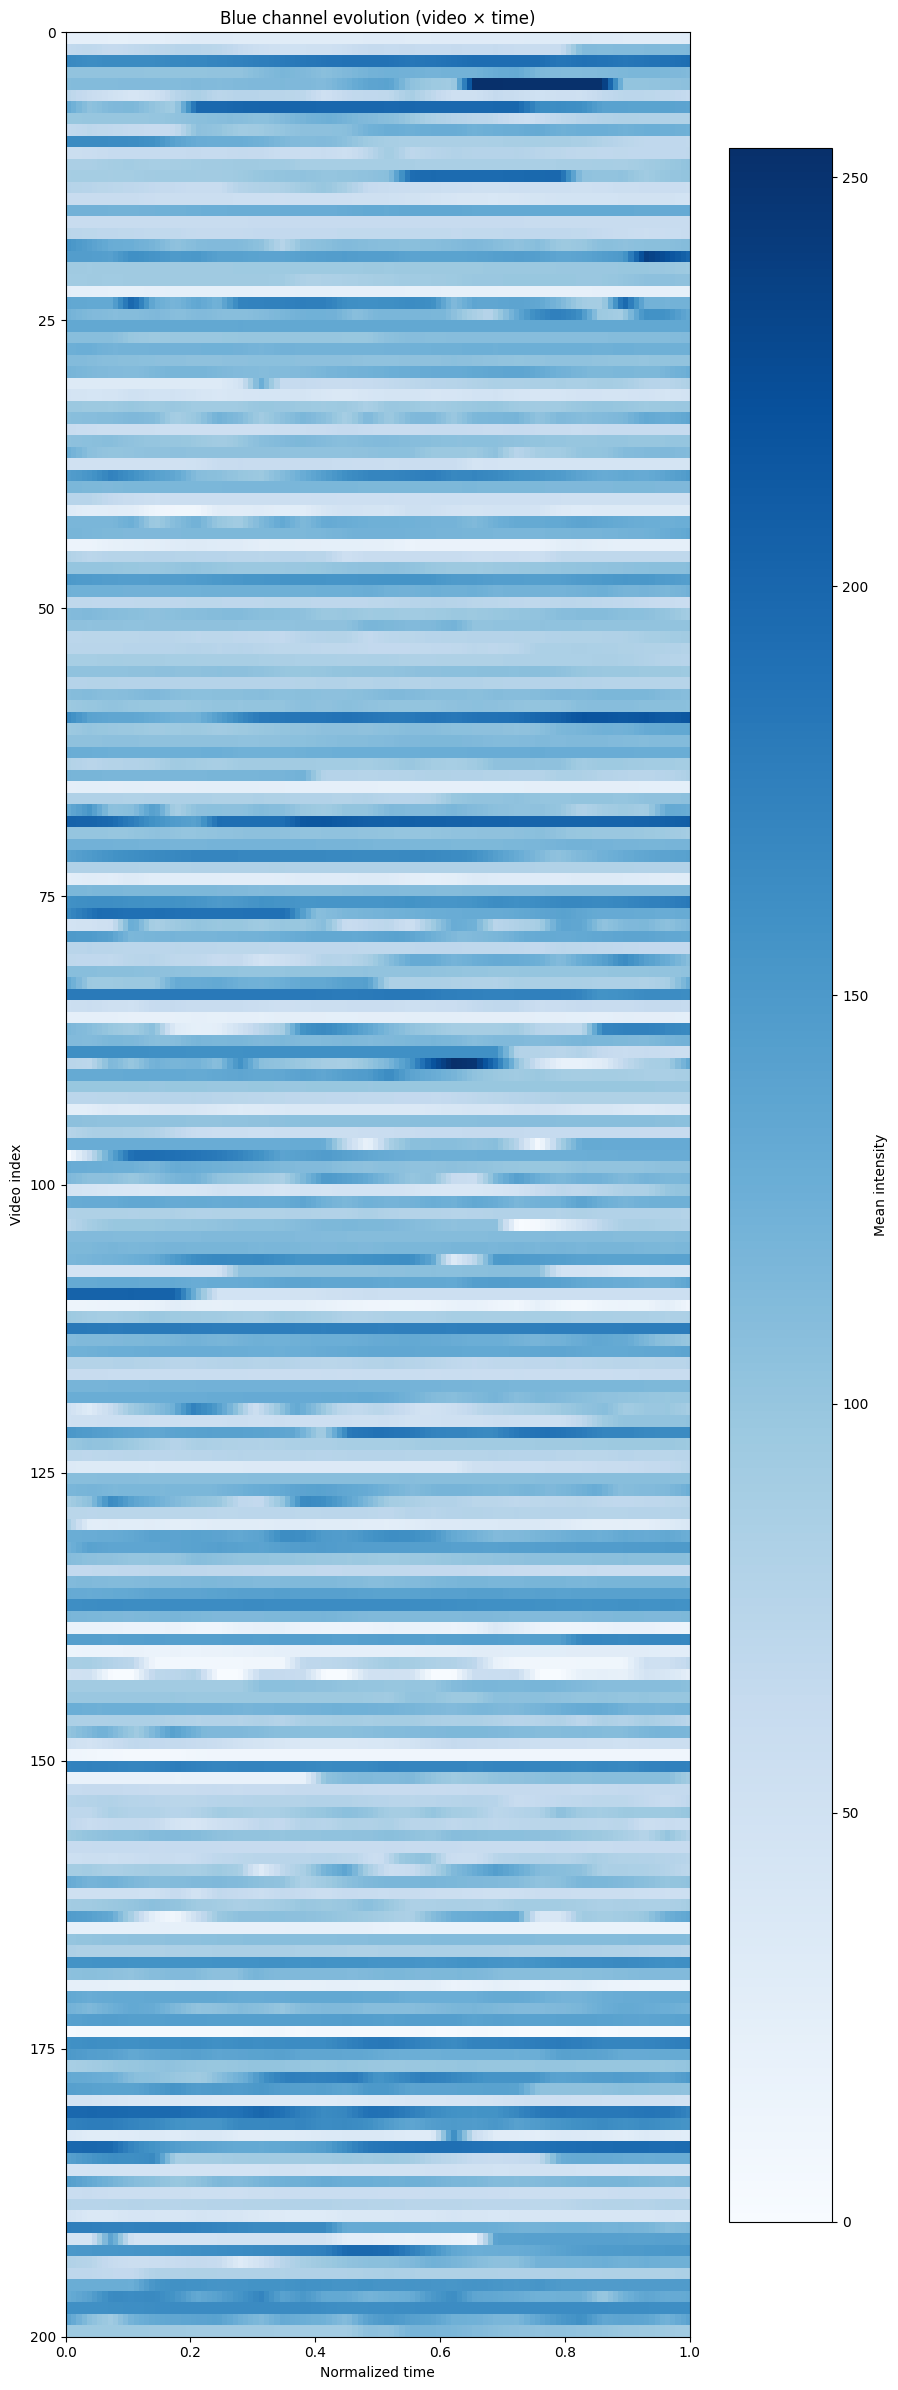

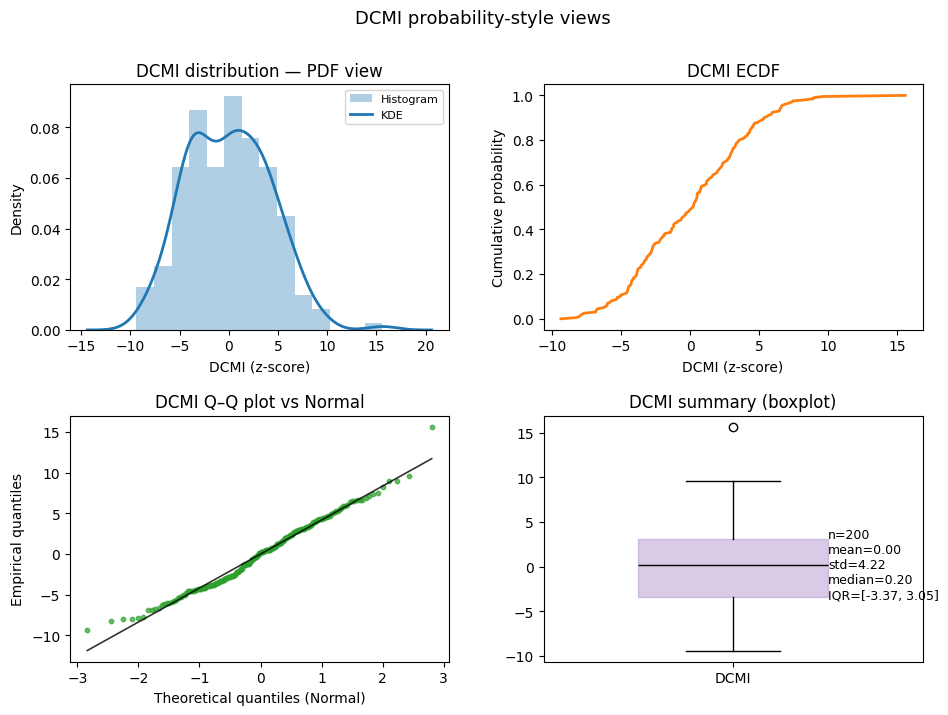

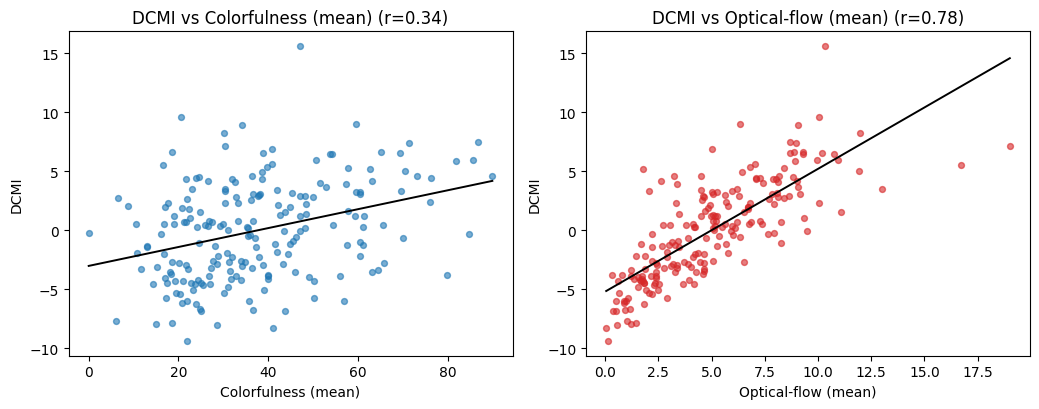

Saved figures in: video_eda_out


In [ ]:
# ============================================
# EASY EDA: RGB evolution per video + DCMI distribution (no clustering)
# ============================================

# (Optional) installs if you're in a fresh Colab
# !pip -q install opencv-python-headless==4.10.0.84

import os, glob, pickle, warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----------------------------
# PATHS / CONFIG
# ----------------------------
OUT_DIR = "video_eda_out"
SRC_OUT = "video_analysis_out"     # where previous pipeline saved files (if any)
os.makedirs(OUT_DIR, exist_ok=True)

RAW_FEAT_NPY = os.path.join(SRC_OUT, "video_features_raw.npy")   # optional, for DCMI & extras
SERIES_PKL   = os.path.join(SRC_OUT, "video_series.pkl")         # preferred, to avoid re-extracting

# If we must rebuild series, set your videos folder:
VIDEO_DIR = "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked"

# Rebuild parameters (only used if video_series.pkl is missing)
FRAME_STRIDE = 10
MAX_FRAMES_PER_VIDEO = 120
RESIZE_W = 384

# Target resampling length for plots (normalized timeline)
L = 120
RANDOM_STATE = 42

# ----------------------------
# HELPERS
# ----------------------------
def colorfulness_hasler(rgb):
    r, g, b = [rgb[...,i].astype(np.float32) for i in (0,1,2)]
    rg = np.abs(r - g)
    yb = np.abs(0.5*(r + g) - b)
    return np.sqrt(np.std(rg)**2 + np.std(yb)**2) + 0.3*np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)

def resample_series(y, L=120):
    """Linear resample a 1D array to length L."""
    if y.size == 0:
        return np.zeros(L, dtype=float)
    x_old = np.linspace(0, 1, num=y.size)
    x_new = np.linspace(0, 1, num=L)
    return np.interp(x_new, x_old, y)

def compute_dcmi_from_raw(X_raw):
    """
    DCMI: Dynamic Color–Motion Index (z-score sum of selected descriptors)
    Expected raw layout per earlier pipeline:
      [ts_mean(14), ts_std(14), hist(3*bins)+3]
    ts_mean order: [meanR,meanG,meanB, stdR,stdG,stdB, colorf, diff_m, diff_s, flick, flow_m, flow_s, flow_p90, flow_max]
    """
    D_ts = 14
    idx_cf_mean = 6
    idx_diff_m  = 7
    idx_diff_s  = 8
    idx_flick   = 9
    idx_flow_m  = 10
    idx_flow_s  = 11
    idx_cf_std  = D_ts + 6  # in the std block
    cols = [idx_cf_mean, idx_flow_m, idx_flow_s, idx_diff_m, idx_diff_s, idx_flick, idx_cf_std]
    Xsel = X_raw[:, cols].astype(float)
    Xz = (Xsel - Xsel.mean(axis=0)) / (Xsel.std(axis=0) + 1e-9)
    return Xz.sum(axis=1)

def qq_plot(ax, data, title="Q–Q vs Normal", color="C0"):
    """Minimal Q–Q plot vs standard normal."""
    data = np.asarray(data, float)
    data = data[np.isfinite(data)]
    if data.size < 3:
        ax.set_visible(False); return
    s = np.sort(data)
    n = s.size
    # theoretical quantiles (normal)
    from math import sqrt, log, pi
    # approximate inverse CDF via scipy-less method (Beasley-Springer/Moro approx could be used; keep it simple)
    # We'll fall back to numpy percent-point via polyfit to a standard normal sample for simplicity.
    # Instead, generate a large normal and take percentiles at (i-0.5)/n:
    q = np.percentile(np.random.default_rng(0).standard_normal(200000), (np.arange(1, n+1)-0.5)/n*100.0)
    ax.scatter(q, s, s=10, alpha=0.7, color=color)
    # fit line
    m, b = np.polyfit(q, s, 1)
    xline = np.array([q.min(), q.max()])
    ax.plot(xline, m*xline+b, color="k", lw=1.2, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("Theoretical quantiles (Normal)")
    ax.set_ylabel("Empirical quantiles")

# ----------------------------
# LOAD / BUILD SERIES
# Each series row: columns = [meanR,meanG,meanB, stdR,stdG,stdB, colorf, diff_m, diff_s, flick, flow_m, flow_s, flow_p90, flow_max]
# ----------------------------
video_series = None
video_names  = None

if os.path.exists(SERIES_PKL):
    with open(SERIES_PKL, "rb") as f:
        video_series = pickle.load(f)
    # Try to load names if present
    names_csv = os.path.join(SRC_OUT, "video_names.csv")
    if os.path.exists(names_csv):
        import pandas as pd
        tmp = pd.read_csv(names_csv)
        if len(tmp) == len(video_series):
            video_names = tmp["video"].tolist()
    if video_names is None:
        video_names = [f"video_{i:04d}" for i in range(len(video_series))]
    print(f"[load] video_series.pkl: {len(video_series)} sequences")
else:
    # Quick rebuild (RGB means only), if videos exist
    print("[info] series pickle not found — rebuilding minimal RGB series from folder …")
    import cv2
    VID_EXT = (".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v")
    paths = [p for p in sorted(glob.glob(os.path.join(VIDEO_DIR, "**/*"), recursive=True))
             if p.lower().endswith(VID_EXT)]
    assert len(paths) > 0, f"No videos found in {VIDEO_DIR}"
    video_series, video_names = [], []
    for p in tqdm(paths, desc="Rebuilding RGB series"):
        cap = cv2.VideoCapture(p)
        if not cap.isOpened():
            continue
        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        scale = RESIZE_W / max(w, 1)
        size = (RESIZE_W, int(round(h * scale)))
        ts = []
        frame_idx = kept = 0
        while True:
            ok = cap.grab()
            if not ok: break
            if frame_idx % FRAME_STRIDE != 0:
                frame_idx += 1; continue
            ok, frame_bgr = cap.retrieve()
            if not ok: break
            frame_bgr = cv2.resize(frame_bgr, size, interpolation=cv2.INTER_AREA)
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            means = frame_rgb.reshape(-1,3).mean(axis=0)        # R,G,B
            stds  = frame_rgb.reshape(-1,3).std(axis=0)
            colorf = colorfulness_hasler(frame_rgb)
            # store only the needed 14 cols in same ordering for compatibility
            ts.append(np.hstack([means, stds, [colorf, 0,0,0, 0,0,0, 0]]))  # zeros for flow/diff if not computed
            kept += 1; frame_idx += 1
            if kept >= MAX_FRAMES_PER_VIDEO: break
        cap.release()
        if kept == 0: continue
        video_series.append(np.asarray(ts, dtype=np.float32))
        video_names.append(os.path.basename(p))
    print(f"[rebuild] sequences: {len(video_series)}")

# ----------------------------
# DCMI (load or compute from RAW features if available)
# ----------------------------
dcmi = None
if os.path.exists(RAW_FEAT_NPY):
    X_raw = np.load(RAW_FEAT_NPY)
    dcmi = compute_dcmi_from_raw(X_raw)
    # Optional extras for simple relationship plots
    D_ts = 14
    colorfulness_mean = X_raw[:, 6]
    flow_mean_mean    = X_raw[:, 10]
else:
    # Fallback: compute a proxy DCMI from series (colorfulness only variance/level)
    print("[warn] raw feature matrix not found — using simplified DCMI proxy (colorfulness level & volatility).")
    cf_levels = []
    for ts in video_series:
        if ts.size == 0:
            cf_levels.append(0.0); continue
        cf = ts[:, 6] if ts.shape[1] > 6 else ts[:, 3]  # if rebuilt minimal, colorfulness stored at idx 6 (0s if not available)
        cf_levels.append([np.mean(cf), np.std(cf)])
    cf_levels = np.asarray(cf_levels, float)
    # z-score both dims and sum
    z = (cf_levels - cf_levels.mean(axis=0)) / (cf_levels.std(axis=0) + 1e-9)
    dcmi = z.sum(axis=1)
    colorfulness_mean = cf_levels[:,0]
    flow_mean_mean = np.zeros_like(colorfulness_mean)

# ----------------------------
# RGB EVOLUTION OVER FRAMES (normalized timeline)
# ----------------------------
rng = np.random.default_rng(RANDOM_STATE)
T = np.linspace(0, 1, L)

R_all, G_all, B_all = [], [], []
for ts in video_series:
    if ts is None or ts.size == 0: continue
    R_all.append(resample_series(ts[:, 0], L))
    G_all.append(resample_series(ts[:, 1], L))
    B_all.append(resample_series(ts[:, 2], L))
R_all = np.vstack(R_all) if len(R_all) else np.zeros((0, L))
G_all = np.vstack(G_all) if len(G_all) else np.zeros((0, L))
B_all = np.vstack(B_all) if len(B_all) else np.zeros((0, L))

def mean_sem(M):
    if M.size == 0:
        return np.zeros(L), np.zeros(L)
    m = M.mean(axis=0)
    se = M.std(axis=0, ddof=1) / np.sqrt(M.shape[0])
    return m, se

R_mu, R_se = mean_sem(R_all)
G_mu, G_se = mean_sem(G_all)
B_mu, B_se = mean_sem(B_all)

# ----------------------------
# FIG 1 — RGB evolution overlays + global mean ± SEM
# ----------------------------
plt.figure(figsize=(10,4.2))
for arr, col, name in [(R_all, 'r', 'R'), (G_all, 'g', 'G'), (B_all, 'b', 'B')]:
    for i in range(min(200, arr.shape[0])):  # overlay up to 200 to keep it readable
        plt.plot(T, arr[i], color=col, alpha=0.05, lw=0.8)
# Global mean±SEM (bold)
plt.plot(T, R_mu, color='r', lw=2.2, label='R mean')
plt.fill_between(T, R_mu-R_se, R_mu+R_se, color='r', alpha=0.15)
plt.plot(T, G_mu, color='g', lw=2.2, label='G mean')
plt.fill_between(T, G_mu-G_se, G_mu+G_se, color='g', alpha=0.15)
plt.plot(T, B_mu, color='b', lw=2.2, label='B mean')
plt.fill_between(T, B_mu-B_se, B_mu+B_se, color='b', alpha=0.15)
plt.xlabel("Normalized time"); plt.ylabel("Channel mean (a.u.)")
plt.title("RGB evolution over time — all videos (overlay) + global mean±SEM")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "rgb_evolution_overlay_mean.png"), dpi=180)
plt.show()

# ----------------------------
# FIG 2 — RGB evolution heatmaps (each row = one video)
# ----------------------------
def heatmap(data, title, cmap, fname):
    if data.size == 0: return
    plt.figure(figsize=(9, max(2.5, data.shape[0]*0.12)))
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap=cmap, extent=[0,1, data.shape[0], 0])
    plt.colorbar(shrink=0.9, label='Mean intensity')
    plt.xlabel("Normalized time"); plt.ylabel("Video index")
    plt.title(title)
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, fname), dpi=180); plt.show()

heatmap(R_all, "Red channel evolution (video × time)", "Reds", "heatmap_R.png")
heatmap(G_all, "Green channel evolution (video × time)", "Greens", "heatmap_G.png")
heatmap(B_all, "Blue channel evolution (video × time)", "Blues", "heatmap_B.png")

# ----------------------------
# FIG 3 — DCMI probability-style distributions
#    Panel: (A) histogram+KDE, (B) ECDF, (C) Q–Q vs Normal, (D) boxplot + stats
# ----------------------------
dcmi = np.asarray(dcmi, float)
dcmi = dcmi[np.isfinite(dcmi)]

fig = plt.figure(figsize=(11,7.5))
gs = fig.add_gridspec(2,2, wspace=0.25, hspace=0.35)

# (A) Histogram + KDE
axA = fig.add_subplot(gs[0,0])
bins = max(12, int(np.sqrt(len(dcmi))))
axA.hist(dcmi, bins=bins, density=True, alpha=0.35, color="#1f77b4", edgecolor="none", label="Histogram")
try:
    # quick KDE via numpy (coarse) — or fallback to gaussian window
    from scipy.stats import gaussian_kde
    xs = np.linspace(dcmi.min()-0.2*np.ptp(dcmi), dcmi.max()+0.2*np.ptp(dcmi), 400)
    kde = gaussian_kde(dcmi)(xs)
    axA.plot(xs, kde, color="#1f77b4", lw=2.0, label="KDE")
except Exception:
    pass
axA.set_title("DCMI distribution — PDF view")
axA.set_xlabel("DCMI (z-score)"); axA.set_ylabel("Density")
axA.legend(loc="best", fontsize=8)

# (B) ECDF
axB = fig.add_subplot(gs[0,1])
s = np.sort(dcmi); y = np.linspace(0,1,len(s))
axB.plot(s, y, lw=2.0, color="#ff7f0e")
axB.set_title("DCMI ECDF")
axB.set_xlabel("DCMI (z-score)"); axB.set_ylabel("Cumulative probability")

# (C) Q–Q
axC = fig.add_subplot(gs[1,0])
qq_plot(axC, dcmi, title="DCMI Q–Q plot vs Normal", color="#2ca02c")

# (D) Boxplot + summary stats
axD = fig.add_subplot(gs[1,1])
bp = axD.boxplot(dcmi, vert=True, patch_artist=True, widths=0.5,
                 boxprops=dict(facecolor="#9467bd", alpha=0.35, color="#9467bd"),
                 medianprops=dict(color="k"))
mu, sd = float(np.mean(dcmi)), float(np.std(dcmi, ddof=1))
q25, q50, q75 = np.percentile(dcmi, [25, 50, 75])
txt = f"n={len(dcmi)}\nmean={mu:.2f}\nstd={sd:.2f}\nmedian={q50:.2f}\nIQR=[{q25:.2f}, {q75:.2f}]"
axD.text(1.25, q50, txt, va="center", fontsize=9)
axD.set_xticks([1]); axD.set_xticklabels(["DCMI"])
axD.set_title("DCMI summary (boxplot)")
fig.suptitle("DCMI probability-style views", y=0.98, fontsize=13)
plt.tight_layout(rect=[0,0,1,0.96]); plt.savefig(os.path.join(OUT_DIR, "dcmi_distribution_panel.png"), dpi=200)
plt.show()

# ----------------------------
# FIG 4 — Simple relationships: DCMI vs colorfulness / motion
# ----------------------------
def scatter_with_trend(x, y, xlabel, ylabel, color):
    m, b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.scatter(x, y, s=18, alpha=0.6, color=color)
    plt.plot(xs, m*xs + b, color="k", lw=1.4)
    r = np.corrcoef(x, y)[0,1]
    plt.title(f"{ylabel} vs {xlabel} (r={r:.2f})")
    plt.xlabel(xlabel); plt.ylabel(ylabel)

plt.figure(figsize=(10.5,4.2))
plt.subplot(1,2,1)
scatter_with_trend(colorfulness_mean, dcmi, "Colorfulness (mean)", "DCMI", "#1f77b4")
plt.subplot(1,2,2)
scatter_with_trend(flow_mean_mean, dcmi, "Optical-flow (mean)", "DCMI", "#d62728")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "dcmi_relationships.png"), dpi=180)
plt.show()

print("Saved figures in:", OUT_DIR)


[load] video_series: 200 sequences


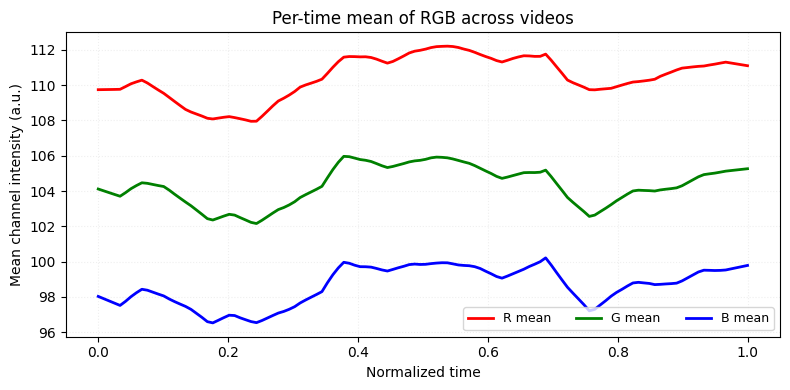

Saved: video_eda_out/rgb_means_over_time.png


In [ ]:
# ============================================
# Mean RGB over time across videos (single lineplot)
# ============================================
import os, glob, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

SRC_OUT = "video_analysis_out"                 # where video_series.pkl is (from your pipeline)
SERIES_PKL = os.path.join(SRC_OUT, "video_series.pkl")
OUT_DIR = "video_eda_out"; os.makedirs(OUT_DIR, exist_ok=True)

# If we must rebuild series, set your videos folder:
VIDEO_DIR = "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked"
FRAME_STRIDE = 10
MAX_FRAMES_PER_VIDEO = 120
RESIZE_W = 384

# Target resampling length (normalized timeline)
L = 120

def resample_series(y, L=120):
    if y.size == 0: return np.zeros(L, dtype=float)
    x_old = np.linspace(0, 1, num=y.size)
    x_new = np.linspace(0, 1, num=L)
    return np.interp(x_new, x_old, y)

# -------- load or rebuild minimal RGB series --------
if os.path.exists(SERIES_PKL):
    with open(SERIES_PKL, "rb") as f:
        video_series = pickle.load(f)
    print(f"[load] video_series: {len(video_series)} sequences")
else:
    # Minimal rebuild (RGB means only)
    print("[info] series pickle not found — rebuilding minimal RGB series from folder …")
    import cv2
    VID_EXT = (".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v")
    paths = [p for p in sorted(glob.glob(os.path.join(VIDEO_DIR, "**/*"), recursive=True))
             if p.lower().endswith(VID_EXT)]
    assert len(paths) > 0, f"No videos found in {VIDEO_DIR}"
    video_series = []
    for p in tqdm(paths, desc="Rebuilding RGB series"):
        cap = cv2.VideoCapture(p)
        if not cap.isOpened():
            continue
        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        scale = RESIZE_W / max(w, 1)
        size = (RESIZE_W, int(round(h * scale)))
        ts = []
        frame_idx = kept = 0
        while True:
            ok = cap.grab()
            if not ok: break
            if frame_idx % FRAME_STRIDE != 0:
                frame_idx += 1; continue
            ok, frame_bgr = cap.retrieve()
            if not ok: break
            frame_bgr = cv2.resize(frame_bgr, size, interpolation=cv2.INTER_AREA)
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            means = frame_rgb.reshape(-1,3).mean(axis=0)  # R,G,B
            # Build row in same 14-col layout’s first 3 slots (rest unused here)
            row = np.zeros(14, dtype=np.float32)
            row[0:3] = means
            ts.append(row)
            kept += 1; frame_idx += 1
            if kept >= MAX_FRAMES_PER_VIDEO: break
        cap.release()
        if kept > 0:
            video_series.append(np.asarray(ts, dtype=np.float32))
    print(f"[rebuild] sequences: {len(video_series)}")

# -------- resample each video’s R/G/B series to a common length L --------
R_all, G_all, B_all = [], [], []
for ts in video_series:
    if ts is None or ts.size == 0 or ts.shape[1] < 3:
        continue
    R_all.append(resample_series(ts[:, 0], L))
    G_all.append(resample_series(ts[:, 1], L))
    B_all.append(resample_series(ts[:, 2], L))

R_all = np.vstack(R_all) if len(R_all) else np.zeros((0, L))
G_all = np.vstack(G_all) if len(G_all) else np.zeros((0, L))
B_all = np.vstack(B_all) if len(B_all) else np.zeros((0, L))

# -------- compute per-time means across videos --------
R_mean = R_all.mean(axis=0) if R_all.size else np.zeros(L)
G_mean = G_all.mean(axis=0) if G_all.size else np.zeros(L)
B_mean = B_all.mean(axis=0) if B_all.size else np.zeros(L)
t = np.linspace(0, 1, L)

# -------- plot: mean RGB vs normalized time --------
plt.figure(figsize=(8,4))
plt.plot(t, R_mean, 'r-', lw=2.0, label='R mean')
plt.plot(t, G_mean, 'g-', lw=2.0, label='G mean')
plt.plot(t, B_mean, 'b-', lw=2.0, label='B mean')
plt.xlabel("Normalized time")
plt.ylabel("Mean channel intensity (a.u.)")
plt.title("Per-time mean of RGB across videos")
plt.legend(ncol=3, fontsize=9)
plt.grid(alpha=0.2, linestyle=':')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rgb_means_over_time.png"), dpi=180)
plt.show()

print("Saved:", os.path.join(OUT_DIR, "rgb_means_over_time.png"))


## Energy


Energy EDA:   0%|          | 0/200 [00:00<?, ?it/s]

[saved] video_energy_out/video_energy_summary.csv


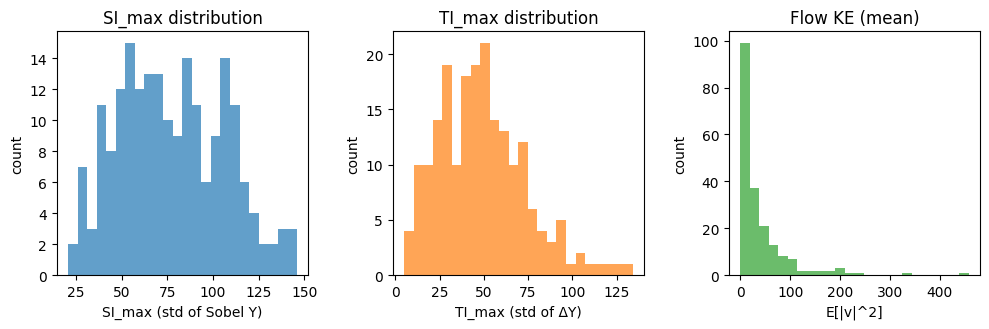

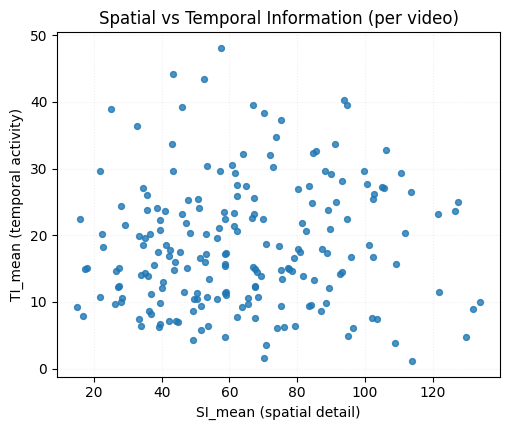

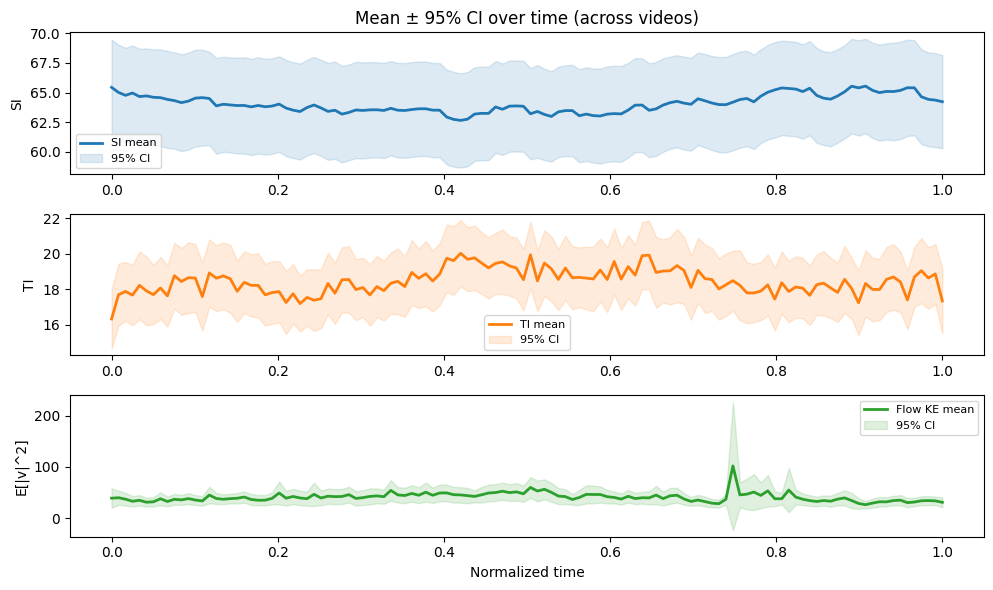

Saved figures:
 - energy_distributions.png
 - si_vs_ti.png
 - energy_curves_mean_ci.png
Saved table:
 - video_energy_summary.csv


In [ ]:
# ============================================
# Video "Energy" EDA (SI, TI, Flow-KE) + Plots
# ============================================
# Dependencies: OpenCV, NumPy, Matplotlib, tqdm

import os, glob, math, json, warnings
warnings.filterwarnings("ignore")
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----------------------------
# CONFIG
# ----------------------------
VIDEO_DIR = "/content/drive/MyDrive/BHo: Watermarker/BHo_eps_0,05/NOT-watermarked"  # change if needed
OUT_DIR   = "video_energy_out"
os.makedirs(OUT_DIR, exist_ok=True)

FRAME_STRIDE = 2          # sample every N frames (↑ for speed)
RESIZE_W     = 512        # resize width for speed; keeps aspect
MAX_FRAMES   = 900        # optional cap after stride (None for all)
FLOW_STEP    = 2          # subsample factor for flow stats (keeps it fast)

# ----------------------------
# HELPERS (P.910-style SI/TI + flow energy)
# ----------------------------
def to_luma_y(frame_bgr):
    # Y' (BT.601-like) — OpenCV uses BGR input; use standard coefficients
    # Y = 0.299 R + 0.587 G + 0.114 B
    r = frame_bgr[...,2].astype(np.float32)
    g = frame_bgr[...,1].astype(np.float32)
    b = frame_bgr[...,0].astype(np.float32)
    y = 0.299*r + 0.587*g + 0.114*b
    return y

def spatial_information(y):
    # P.910 SI per frame: stddev of Sobel-filtered luma (spatial detail)
    gx = cv2.Sobel(y, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(y, cv2.CV_32F, 0, 1, ksize=3)
    g  = np.hypot(gx, gy)
    return float(g.std(ddof=1))

def temporal_information(y_prev, y_cur):
    # P.910 TI per frame: stddev of frame difference (temporal activity)
    d = (y_cur - y_prev)
    return float(d.std(ddof=1))

def flow_energy(prev_gray, gray, step=2):
    # Mean squared flow magnitude per frame (proxy kinetic energy)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2,
                                        flags=0)
    mag, _ = cv2.cartToPolar(flow[...,0], flow[...,1])
    m = mag[::step, ::step]
    # KE proxy ~ E[ |v|^2 ] ; also return mean |v| for reference
    return float((m**2).mean()), float(m.mean())

def luminance_energy(y):
    # Mean squared luma (scaled to [0,1]) — simple brightness "energy"
    y01 = np.clip(y/255.0, 0.0, 1.0)
    return float((y01**2).mean())

def resize_keep_aspect(frame_bgr, target_w):
    h, w = frame_bgr.shape[:2]
    if w == 0: return frame_bgr
    scale = target_w / float(w)
    new_size = (int(round(w*scale)), int(round(h*scale)))
    return cv2.resize(frame_bgr, new_size, interpolation=cv2.INTER_AREA)

# ----------------------------
# SCAN FOLDER
# ----------------------------
VID_EXT = (".mp4", ".mov", ".mkv", ".avi", ".webm", ".m4v")
video_paths = [p for p in sorted(glob.glob(os.path.join(VIDEO_DIR, "**/*"), recursive=True))
               if p.lower().endswith(VID_EXT)]
assert len(video_paths) > 0, f"No videos found in {VIDEO_DIR}"

# ----------------------------
# COMPUTE PER-VIDEO CURVES
# ----------------------------
results = []  # per video: dict with curves & aggregates
for p in tqdm(video_paths, desc="Energy EDA"):
    cap = cv2.VideoCapture(p)
    if not cap.isOpened():
        print("Skipping (cannot open):", p); continue

    si_curve, ti_curve, ke_curve, mag_curve, y2_curve = [], [], [], [], []
    prev_y = None
    prev_gray = None

    frames_seen = 0
    frames_kept = 0
    while True:
        ok = cap.grab()
        if not ok:
            break
        frames_seen += 1
        if (frames_seen-1) % FRAME_STRIDE != 0:
            continue
        ok, frame_bgr = cap.retrieve()
        if not ok: break

        frame_bgr = resize_keep_aspect(frame_bgr, RESIZE_W)
        y = to_luma_y(frame_bgr)
        si_curve.append(spatial_information(y))
        y2_curve.append(luminance_energy(y))

        gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

        if prev_y is not None:
            ti_curve.append(temporal_information(prev_y, y))
            ke2, mag = flow_energy(prev_gray, gray, step=FLOW_STEP)
            ke_curve.append(ke2)
            mag_curve.append(mag)

        prev_y = y
        prev_gray = gray
        frames_kept += 1
        if MAX_FRAMES is not None and frames_kept >= MAX_FRAMES:
            break

    cap.release()
    if len(si_curve) == 0:
        print("Skipping (no frames after stride):", p); continue

    # Align curves (TI/flow start from second kept frame)
    n = len(si_curve)
    ti_arr  = np.array(ti_curve,  dtype=np.float32) if ti_curve else np.zeros(0, np.float32)
    ke_arr  = np.array(ke_curve,  dtype=np.float32) if ke_curve else np.zeros(0, np.float32)
    mag_arr = np.array(mag_curve, dtype=np.float32) if mag_curve else np.zeros(0, np.float32)
    si_arr  = np.array(si_curve,  dtype=np.float32)
    y2_arr  = np.array(y2_curve,  dtype=np.float32)

    results.append({
        "video": os.path.basename(p),
        "SI_curve": si_arr,                      # per-frame SI
        "TI_curve": ti_arr,                      # per-frame TI (len = n-1)
        "KE_flow_curve": ke_arr,                 # per-frame flow energy (len = n-1)
        "FLOW_mag_curve": mag_arr,               # mean |v| (aux)
        "Y2_curve": y2_arr,                      # per-frame luminance energy
        "SI_max": float(np.max(si_arr)),
        "SI_mean": float(np.mean(si_arr)),
        "TI_max": float(np.max(ti_arr)) if ti_arr.size else 0.0,
        "TI_mean": float(np.mean(ti_arr)) if ti_arr.size else 0.0,
        "KE_max": float(np.max(ke_arr)) if ke_arr.size else 0.0,
        "KE_mean": float(np.mean(ke_arr)) if ke_arr.size else 0.0,
        "Y2_mean": float(np.mean(y2_arr)),
        "frames_used": int(n)
    })

# Save numeric summary
import pandas as pd
df_sum = pd.DataFrame([{
    "video": r["video"],
    "frames_used": r["frames_used"],
    "SI_max": r["SI_max"], "SI_mean": r["SI_mean"],
    "TI_max": r["TI_max"], "TI_mean": r["TI_mean"],
    "KE_max": r["KE_max"], "KE_mean": r["KE_mean"],
    "Y2_mean": r["Y2_mean"],
} for r in results])
csv_path = os.path.join(OUT_DIR, "video_energy_summary.csv")
df_sum.to_csv(csv_path, index=False)
print("[saved]", csv_path)

# ----------------------------
# PLOTS (aggregate across videos)
# ----------------------------
# 1) Distributions of SI_max, TI_max, KE_mean
plt.figure(figsize=(10,3.4))
plt.subplot(1,3,1)
plt.hist(df_sum["SI_max"], bins=24, color="#1f77b4", alpha=0.7)
plt.title("SI_max distribution"); plt.xlabel("SI_max (std of Sobel Y)"); plt.ylabel("count")

plt.subplot(1,3,2)
plt.hist(df_sum["TI_max"], bins=24, color="#ff7f0e", alpha=0.7)
plt.title("TI_max distribution"); plt.xlabel("TI_max (std of ΔY)"); plt.ylabel("count")

plt.subplot(1,3,3)
plt.hist(df_sum["KE_mean"], bins=24, color="#2ca02c", alpha=0.7)
plt.title("Flow KE (mean)"); plt.xlabel("E[|v|^2]"); plt.ylabel("count")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "energy_distributions.png"), dpi=180); plt.show()

# 2) SI vs TI scatter (activity map)
plt.figure(figsize=(5.2,4.4))
plt.scatter(df_sum["SI_mean"], df_sum["TI_mean"], s=18, alpha=0.8)
plt.xlabel("SI_mean (spatial detail)"); plt.ylabel("TI_mean (temporal activity)")
plt.title("Spatial vs Temporal Information (per video)")
plt.grid(alpha=0.2, linestyle=':')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "si_vs_ti.png"), dpi=180); plt.show()

# 3) Mean ± 95% CI curves across videos (normalized time)
def resample_curve(y, L=120):  # resample 1D curve to length L
    if y.size == 0: return np.zeros(L, dtype=float)
    x_old = np.linspace(0, 1, num=y.size)
    x_new = np.linspace(0, 1, num=L)
    return np.interp(x_new, x_old, y)

def mean_ci95_matrix(mat):
    mu = mat.mean(axis=0)
    se = mat.std(axis=0, ddof=1) / np.sqrt(max(1, mat.shape[0]))
    return mu, 1.96*se

L = 120
# collect resampled curves
SI_mat, TI_mat, KE_mat = [], [], []
for r in results:
    SI_mat.append(resample_curve(r["SI_curve"], L))
    if r["TI_curve"].size: TI_mat.append(resample_curve(r["TI_curve"], L))
    if r["KE_flow_curve"].size: KE_mat.append(resample_curve(r["KE_flow_curve"], L))

SI_mat = np.vstack(SI_mat) if SI_mat else np.zeros((0,L))
TI_mat = np.vstack(TI_mat) if TI_mat else np.zeros((0,L))
KE_mat = np.vstack(KE_mat) if KE_mat else np.zeros((0,L))

t = np.linspace(0,1,L)

plt.figure(figsize=(10,6))
# SI
if SI_mat.size:
    si_mu, si_ci = mean_ci95_matrix(SI_mat)
    plt.subplot(3,1,1)
    plt.plot(t, si_mu, color="#1f77b4", lw=2.0, label="SI mean")
    plt.fill_between(t, si_mu-si_ci, si_mu+si_ci, color="#1f77b4", alpha=0.15, label="95% CI")
    plt.ylabel("SI"); plt.title("Mean ± 95% CI over time (across videos)")
    plt.legend(fontsize=8)

# TI
if TI_mat.size:
    ti_mu, ti_ci = mean_ci95_matrix(TI_mat)
    plt.subplot(3,1,2)
    plt.plot(t, ti_mu, color="#ff7f0e", lw=2.0, label="TI mean")
    plt.fill_between(t, ti_mu-ti_ci, ti_mu+ti_ci, color="#ff7f0e", alpha=0.15, label="95% CI")
    plt.ylabel("TI"); plt.legend(fontsize=8)

# KE (flow energy)
if KE_mat.size:
    ke_mu, ke_ci = mean_ci95_matrix(KE_mat)
    plt.subplot(3,1,3)
    plt.plot(t, ke_mu, color="#2ca02c", lw=2.0, label="Flow KE mean")
    plt.fill_between(t, ke_mu-ke_ci, ke_mu+ke_ci, color="#2ca02c", alpha=0.15, label="95% CI")
    plt.xlabel("Normalized time"); plt.ylabel("E[|v|^2]"); plt.legend(fontsize=8)

plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "energy_curves_mean_ci.png"), dpi=180); plt.show()

print("Saved figures:\n - energy_distributions.png\n - si_vs_ti.png\n - energy_curves_mean_ci.png")
print("Saved table:\n - video_energy_summary.csv")


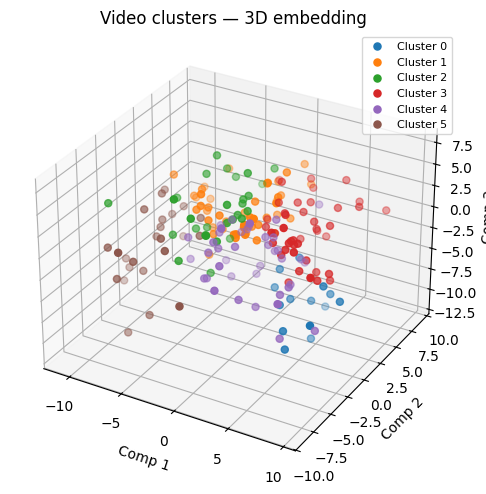

ValueError: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)] is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

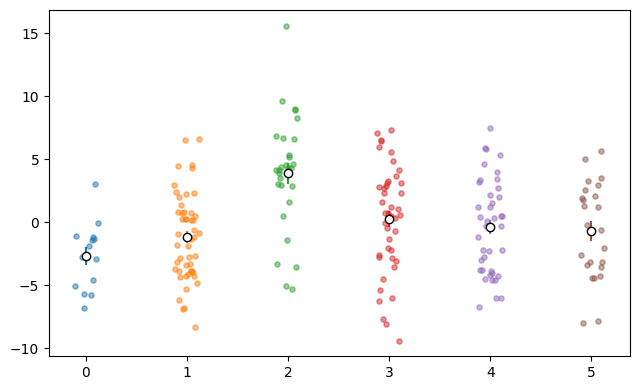

In [ ]:
# Colab/Notebook cell: 3D embedding + DCMI per-cluster scatter + RGB aggregates per cluster
# Requirements: pandas, numpy, matplotlib, scikit-learn
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ----------------------------
# CONFIGURE YOUR INPUT FILES
# ----------------------------
CSV_LABELS   = "/content/video_analysis_out/video_clusters_kmeans.csv"   # ["video","kmeans_label"]
ALT_LABELS   = "/content/video_analysis_out/video_clusters_hdbscan.csv"  # optional
FEAT_NPY     = "/content/video_analysis_out/video_features_scaled.npy"   # (preferred) standardized/PCA features
RAW_FEAT_NPY = "/content/video_analysis_out/video_features_raw.npy"      # (for DCMI + RGB aggregates)

# ----------------------------
# LOAD LABELS
# ----------------------------
assert os.path.exists(CSV_LABELS), f"Missing {CSV_LABELS}"
df_labels = pd.read_csv(CSV_LABELS)
assert "kmeans_label" in df_labels.columns, "CSV must include 'kmeans_label' column."

hb_labels = None
if os.path.exists(ALT_LABELS):
    df_hb = pd.read_csv(ALT_LABELS)
    if "hdbscan_label" in df_hb.columns:
        if "video" in df_labels.columns and "video" in df_hb.columns:
            hb_map = dict(zip(df_hb["video"], df_hb["hdbscan_label"]))
            hb_labels = df_labels["video"].map(hb_map).to_numpy()
        else:
            hb_labels = df_hb["hdbscan_label"].to_numpy()

# ----------------------------
# LOAD FEATURES → 3D embedding
# ----------------------------
if os.path.exists(FEAT_NPY):
    X = np.load(FEAT_NPY)
    if X.shape[1] > 3:
        pca3 = PCA(n_components=3, random_state=42)
        X3 = pca3.fit_transform(X)
    elif X.shape[1] == 2:
        X3 = np.column_stack([X, np.zeros((X.shape[0], 1))])
    else:
        X3 = X[:, :3]
else:
    assert os.path.exists(RAW_FEAT_NPY), f"Missing both {FEAT_NPY} and {RAW_FEAT_NPY}."
    X_raw = np.load(RAW_FEAT_NPY)
    Xs = StandardScaler().fit_transform(X_raw)
    pca3 = PCA(n_components=3, random_state=42)
    X3 = pca3.fit_transform(Xs)

# Align sizes
assert len(df_labels) == X3.shape[0], "Label count and feature rows differ; ensure same ordering/files."

labels = df_labels["kmeans_label"].to_numpy()
videos = df_labels["video"].to_numpy() if "video" in df_labels.columns else np.arange(len(labels)).astype(str)
clusters_sorted = np.unique(labels)

# ----------------------------
# CONSISTENT CLUSTER COLORS
# ----------------------------
# use a stable palette (tab10 repeated if >10 clusters)
tab10 = plt.cm.tab10.colors
palette = {lab: tab10[i % len(tab10)] for i, lab in enumerate(clusters_sorted)}

# ----------------------------
# 3D SCATTER PLOT (unchanged, but with cluster colors)
# ----------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
for lab in clusters_sorted:
    m = labels == lab
    ax.scatter(X3[m,0], X3[m,1], X3[m,2], s=26, label=f"Cluster {lab}", depthshade=True, c=[palette[lab]])
ax.set_xlabel("Comp 1")
ax.set_ylabel("Comp 2")
ax.set_zlabel("Comp 3")
ax.set_title("Video clusters — 3D embedding")
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.savefig("clusters_3d.png", dpi=180)
plt.show()

# ----------------------------
# DCMI (aggregate indicator) per video
# ----------------------------
def compute_indicator_from_raw(X_raw):
    D_ts = 14
    idx_colorfulness_mean = 6
    idx_diff_mean         = 7
    idx_diff_std          = 8
    idx_flicker_mean      = 9
    idx_flow_mean         = 10
    idx_flow_std          = 11
    off = D_ts
    idx_colorfulness_std = off + 6
    # z-score sum
    cols = [idx_colorfulness_mean, idx_flow_mean, idx_flow_std,
            idx_diff_mean, idx_diff_std, idx_flicker_mean, idx_colorfulness_std]
    Xsel = X_raw[:, cols].astype(float)
    Xz = (Xsel - Xsel.mean(axis=0)) / (Xsel.std(axis=0) + 1e-9)
    return Xz.sum(axis=1)

# Prefer RAW for semantic DCMI; otherwise fallback to centroid-distance proxy
if os.path.exists(RAW_FEAT_NPY):
    X_raw = np.load(RAW_FEAT_NPY)
    agg_indicator = compute_indicator_from_raw(X_raw)
else:
    centroids = np.vstack([X3[labels==lab].mean(axis=0) for lab in clusters_sorted])
    lab_to_idx = {lab:i for i,lab in enumerate(clusters_sorted)}
    d = np.zeros(len(labels))
    for i,(x,lab) in enumerate(zip(X3, labels)):
        c = centroids[lab_to_idx[lab]]
        d[i] = -np.linalg.norm(x - c)
    agg_indicator = (d - d.mean()) / (d.std() + 1e-9)

df = pd.DataFrame({"video": videos, "cluster": labels, "indicator": agg_indicator})

# ----------------------------
# NEW FIG 1: DCMI SCATTER BY CLUSTER (jittered), with mean±SEM
# ----------------------------
rng = np.random.default_rng(42)
fig = plt.figure(figsize=(7.5,4.5))
ax = fig.add_subplot(111)

x_positions = np.arange(len(clusters_sorted))
means = []
sems  = []
for i, lab in enumerate(clusters_sorted):
    vals = df.loc[df["cluster"]==lab, "indicator"].values
    means.append(vals.mean() if vals.size else np.nan)
    sems.append(vals.std(ddof=1)/np.sqrt(vals.size) if vals.size>1 else 0.0)
    # jittered scatter
    jitter = (rng.random(vals.size)-0.5)*0.25
    ax.scatter(np.full(vals.shape, x_positions[i])+jitter, vals, s=14, alpha=0.5, color=palette[lab], label=None)
# overlay mean ± SEM bars
ax.errorbar(x_positions, means, yerr=sems, fmt='o', capsize=4, lw=1.5,
            ecolor=[palette[lab] for lab in clusters_sorted],
            mfc='white', mec='black', ms=6, label="mean ± SEM")

ax.set_xticks(x_positions)
ax.set_xticklabels([str(l) for l in clusters_sorted])
ax.set_xlabel("Cluster")
ax.set_ylabel("DCMI (z-score)")
ax.set_title("DCMI scatter by cluster (points) with mean ± SEM")
# custom legend: colored patches per cluster
handles = [plt.Line2D([0],[0], marker='o', color='w', label=f"C{lab}",
                      markerfacecolor=palette[lab], markeredgecolor='k', markersize=7)
           for lab in clusters_sorted]
ax.legend(handles=handles, title="Clusters", ncol=min(5,len(handles)), fontsize=8)
plt.tight_layout()
plt.savefig("dcmi_scatter_by_cluster.png", dpi=180)
plt.show()

# ----------------------------
# NEW FIG 2: RGB AGGREGATES PER CLUSTER (average channel histograms)
# ----------------------------
def infer_histograms_from_raw(X_raw):
    """Infer RGB histograms from raw layout: [ts_mean(14), ts_std(14), RGB hists (3*bins) + 3 entropies]."""
    D_ts = 14
    # remaining dims after 2*D_ts are histograms+entropies
    rem = X_raw.shape[1] - 2*D_ts
    # infer bins: rem = 3*bins + 3 (3 entropies)
    bins = (rem - 3) // 3
    if 3*bins + 3 != rem or bins <= 1:
        raise ValueError(f"Cannot infer HIST_BINS from RAW layout: remaining={rem}")
    start = 2*D_ts
    hB = X_raw[:, start : start+bins]                 # Blue
    hG = X_raw[:, start+bins : start+2*bins]          # Green
    hR = X_raw[:, start+2*bins : start+3*bins]        # Red
    return hR, hG, hB, bins

if os.path.exists(RAW_FEAT_NPY):
    hR, hG, hB, HIST_BINS = infer_histograms_from_raw(X_raw)
    # Normalize hist rows (safety)
    def norm_rows(H):
        s = H.sum(axis=1, keepdims=True)
        s[s==0] = 1.0
        return H / s
    hR, hG, hB = norm_rows(hR), norm_rows(hG), norm_rows(hB)

    # Aggregate per cluster
    x = np.arange(HIST_BINS)
    fig = plt.figure(figsize=(10,3.6))
    axes = [fig.add_subplot(1,3,i+1) for i in range(3)]
    titles = ["Red channel", "Green channel", "Blue channel"]
    for ax, Hc_all, title in zip(axes, [hR,hG,hB], titles):
        for lab in clusters_sorted:
            m = (labels == lab)
            if not np.any(m):
                continue
            avg = Hc_all[m].mean(axis=0)
            ax.plot(x, avg, lw=1.6, label=f"C{lab}", color=palette[lab])
        ax.set_xlabel("Histogram bin")
        ax.set_ylabel("Probability")
        ax.set_title(title)
        ax.grid(alpha=0.2, linestyle=':')
    # shared legend
    handles = [plt.Line2D([0],[0], color=palette[lab], lw=2, label=f"C{lab}") for lab in clusters_sorted]
    fig.legend(handles=handles, loc="upper center", ncol=min(6, len(handles)), fontsize=8, frameon=False)
    fig.suptitle("Per-cluster average RGB histograms", y=1.03, fontsize=12)
    fig.tight_layout()
    plt.savefig("rgb_aggregates_by_cluster.png", dpi=180, bbox_inches="tight")
    plt.show()
else:
    print("⚠️ RAW_FEAT_NPY not found — RGB aggregate figure skipped (needs raw features with histograms).")

# ----------------------------
# Aggregate means per cluster (also save CSV)
# ----------------------------
group = df.groupby("cluster")["indicator"]
agg_mean = group.mean()
agg_sem  = group.sem()

plt.figure(figsize=(6,4))
order = agg_mean.index.to_numpy()
bars = plt.bar(order.astype(str), agg_mean.values, yerr=agg_sem.values, capsize=4,
               color=[palette[c] for c in order])
plt.title("Aggregate dynamicity indicator by cluster")
plt.xlabel("Cluster")
plt.ylabel("Indicator (z-score)")
plt.tight_layout()
plt.savefig("clusters_indicator_bar.png", dpi=180)
plt.show()

# Save the per-video and per-cluster results
df.to_csv("video_aggregate_indicator.csv", index=False)
pd.DataFrame({"cluster": order, "indicator_mean": agg_mean.values, "indicator_sem": agg_sem.values})\
  .to_csv("cluster_indicator_summary.csv", index=False)

print("Saved: clusters_3d.png, dcmi_scatter_by_cluster.png, rgb_aggregates_by_cluster.png (if RAW present), "
      "clusters_indicator_bar.png, video_aggregate_indicator.csv, cluster_indicator_summary.csv")


In [ ]:
import pandas as pd
import json

# change if needed
CSV = "video_clusters_kmeans.csv"   # columns: ["video","kmeans_label"]

df = pd.read_csv(CSV)
assert {"video","kmeans_label"} <= set(df.columns), "CSV must have 'video' and 'kmeans_label'"

# group -> lists
clusters = (
    df.sort_values(["kmeans_label","video"])
      .groupby("kmeans_label")["video"]
      .apply(list)
      .to_dict()
)

# pretty print
for k in sorted(clusters):
    print(f"\nCluster {k}:")
    for v in clusters[k]:
        print(f"  - {v}")

# also save to JSON
with open("clusters_to_videos.json","w",encoding="utf-8") as f:
    json.dump({str(k): v for k,v in clusters.items()}, f, indent=2, ensure_ascii=False)

print("\nSaved: clusters_to_videos.json")


FileNotFoundError: [Errno 2] No such file or directory: 'video_clusters_kmeans.csv'

# Ganache


In [ ]:
# Prereqs: Graphviz binary + `pip install graphviz`
from graphviz import Digraph

g = Digraph("VideoChainHighLevelFancy", filename="video_blockchain_high_level_fancy", format="png")

# --------- Global styling (compact + vertical) ---------
g.attr(rankdir="TB", fontname="Helvetica", fontsize="11",
      nodesep="0.28", ranksep="0.36", splines="spline")
g.node_attr.update(shape="rectangle", style="rounded,filled", color="#4b5563", penwidth="1")

# Palette (6-digit hex)
OFF_BG = "#f7f7f7:#ffffff"     # subtle gradient
ON_BG  = "#f0f8ff:#ffffff"
STORE_COLOR  = "#0ea5e9"        # cyan-blue
VERIFY_COLOR = "#7c3aed"        # violet
ACCENT       = "#111827"

# ---------------- Off-chain (collapsed, high level) ----------------
with g.subgraph(name="cluster_off") as off:
    off.attr(label="Off-chain", color="#9ca3af", penwidth="1.2",
             style="rounded,filled", fillcolor=OFF_BG, gradientangle="90")
    off.node("V", "Video")
    off.node("H", "Compute SHA-256  →  h = H(Video)", fillcolor="#ffffff")
    off.node("REGREQ", "Registration Request\n{ h, label, owner }", fillcolor="#fdfdfd")
    off.node("QREQ", "Verification Query\nh' = H(Video')", fillcolor="#fdfdfd")

# ---------------- On-chain (focused area) ----------------
with g.subgraph(name="cluster_on") as on:
    on.attr(label="Blockchain System", color="#93c5fd", penwidth="1.4",
            style="rounded,filled", fillcolor=ON_BG, gradientangle="90")

    on.node("RPC", "JSON-RPC Endpoint\n(Ganache)", fillcolor="#f8fbff", penwidth="1.2")
    # HTML-like label for registry spec (shape=plain handles its own look)
    on.node("SC", """<
        <TABLE BORDER="0" CELLBORDER="1" CELLPADDING="6" COLOR="#c7d2fe">
          <TR><TD BGCOLOR="#eef2ff"><B>Registry Contract</B></TD></TR>
          <TR><TD ALIGN="LEFT">key: h (bytes32)</TD></TR>
          <TR><TD ALIGN="LEFT">value: { label, owner, timestamp }</TD></TR>
        </TABLE>
    >""", shape="plain", color="#c7d2fe")

    on.edge("RPC", "SC", label="call / deploy", color=ACCENT, fontcolor=ACCENT, penwidth="1.1", dir="both")

# ---------------- Store rail (cyan) ----------------
g.edge("V", "H", color=STORE_COLOR, penwidth="1.4")
g.edge("H", "REGREQ", color=STORE_COLOR, penwidth="1.4")
g.edge("REGREQ", "RPC", label="STORE", color=STORE_COLOR, fontcolor=STORE_COLOR, penwidth="1.6")
g.edge("RPC", "SC", label="write: h → {label, owner, ts}", color=STORE_COLOR, fontcolor=STORE_COLOR, penwidth="1.4")

# ---------------- Verify rail (violet) ----------------
g.edge("QREQ", "RPC", label="LOOKUP", color=VERIFY_COLOR, fontcolor=VERIFY_COLOR, penwidth="1.6")
g.edge("RPC", "SC", label="read: by h'", color=VERIFY_COLOR, fontcolor=VERIFY_COLOR, penwidth="1.4")

# ---------------- Decision & outputs (compact) ----------------
g.node("DECIDE", "Compare: h' vs on-chain key\nIntegrity ∈ {0,1}",
       fillcolor="#ffffff", penwidth="1.1")
g.edge("SC", "DECIDE", color="#374151", penwidth="1.1")

g.node("OUT_MATCH", "If match → return { label, owner, timestamp }", fillcolor="#fefefe")
g.edge("DECIDE", "OUT_MATCH", label="match", color="#16a34a", fontcolor="#16a34a", penwidth="1.3")

# ---------------- Legend (tiny) ----------------
with g.subgraph(name="cluster_legend") as lg:
    lg.attr(label="Legend", color="#d1d5db", style="rounded")
    lg.node("L1", "STORE path", fillcolor="#e6f6fe")
    lg.node("L2", "VERIFY path", fillcolor="#efe9ff")
    lg.edge("L1", "L2", color="#9ca3af", arrowhead="none")

# Keep legend off to the side without affecting layout
g.edge("OUT_MATCH", "L1", style="invis")

g.render(cleanup=True)
print("Wrote video_blockchain_high_level_fancy.png")


Wrote video_blockchain_high_level_fancy.png
